In [ ]:
#import library
import pandas as pd #read data
import matplotlib.pyplot as plt #draw charts
import numpy as np #data processing
from sklearn.preprocessing import MinMaxScaler #Normalize data
from keras.callbacks import ModelCheckpoint #Save the best training
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
#Layers to build model
from keras.models import Sequential #input
from keras.layers import Bidirectional,LSTM #deep learning
from keras.layers import Dropout,SimpleRNN,BatchNormalization #avoid learning by heart
from keras.layers import GRU,Dense,LeakyReLU #output
from keras.optimizers import RMSprop,Adam,AdamW    # Different optimizer
#Check the correctness of the model
from sklearn.metrics import r2_score #measure fitness
from sklearn.metrics import mean_absolute_error #do sai so tuyet doi trung binh
from sklearn.metrics import mean_absolute_percentage_error #do % sai so tuyet doi trung binh
from sklearn.metrics import mean_squared_error

In [ ]:
path = 'https://drive.google.com/uc?id=1QROS6HCnXKe7OeI1Ikhsf0cywW2yWF-9&export=download'
df = pd.read_csv(path, low_memory=False)
df = df.drop(index=0)
df['MonitoringDate'] = pd.to_datetime(df['MonitoringDate'])
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
most_occurred_count = df['MonitoringLocationIdentifier'].value_counts().idxmax()
print (most_occurred_count   )
filtered_df = df[df['MonitoringLocationIdentifier'] == most_occurred_count]
filtered_df.sort_values(by='MonitoringDate')

132


MonitoringLocationIdentifier  LongitudeMeasure_WGS84  \
191986                           132              118.142558   
191987                           132              118.142558   
191988                           132              118.142558   
191989                           132              118.142558   
191990                           132              118.142558   
...                              ...                     ...   
193812                           132              118.142558   
193815                           132              118.142558   
193816                           132              118.142558   
193814                           132              118.142558   
193817                           132              118.142558   

        LatitudeMeasure_WGS84 MonitoringDate IndicatorsName  Value  Unit  \
191986              34.599912     2007-10-29           NH4N   0.20  mg/l   
191987              34.599912     2007-10-29          CODMn   3.90  mg/l   
191988              34.599912     2007-10-29             pH   8.50    pH   
191989              34.599912     2007-10-29             DO   9.79  mg/l   
191990              34.599912     2007-11-05           NH4N   0.03  mg/l   
...                       ...            ...            ...    ...   ...   
193812              34.599912     2018-12-17             pH   7.50    pH   
193815              34.599912     2018-12-24          CODMn   4.20  mg/l   
193816              34.599912     2018-12-24             pH   8.20    pH   
193814              34.599912     2018-12-24           NH4N   0.10  mg/l   
193817              34.599912     2018-12-24             DO  12.40  mg/l   

                                           SourceProvider  
191986  China National Environmental Monitoring Centre...  
191987  China National Environmental Monitoring Centre...  
191988  China National Environmental Monitoring Centre...  
191989  China National Environmental Monitoring Centre...  
191990  China National Environmental Monitoring Centre...  
...                                                   ...  
193812  China National Environmental Monitoring Centre...  
193815  China National Environmental Monitoring Centre...  
193816  China National Environmental Monitoring Centre...  
193814  China National Environmental Monitoring Centre...  
193817  China National Environmental Monitoring Centre...  

[1832 rows x 8 columns]

In [ ]:
NH4df = filtered_df[filtered_df['IndicatorsName'] == 'NH4N']
CODdf = filtered_df[filtered_df['IndicatorsName'] == 'CODMn']
pHdf = filtered_df[filtered_df['IndicatorsName'] == 'pH']
DOdf = filtered_df[filtered_df['IndicatorsName'] == 'DO']
dfList = [NH4df,CODdf,pHdf,DOdf]

In [ ]:
def add_time_features(data):
    """
    Add time-based features (day, month, year) to the dataframe

    Args:
    data (DataFrame): DataFrame with a 'date' column

    Returns:
    DataFrame: Original dataframe with additional time features
    """
    # Make a copy to avoid modifying the original
    df = data.copy()

    # Ensure date column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    # Extract time features
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    # Option: add cyclical features for day and month
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    return df

In [ ]:
import pandas as pd

# Assuming dfList contains the DataFrames for each indicator
dfList = [NH4df, CODdf, pHdf, DOdf]

# Combine all DataFrames into one
combined_df = pd.concat(dfList)

# Ensure the 'MonitoringDate' column is in datetime format
combined_df['MonitoringDate'] = pd.to_datetime(combined_df['MonitoringDate'])

# Rename columns for consistency
combined_df.rename(columns={
    'MonitoringLocationIdentifier': 'Place',
    'MonitoringDate': 'date',
    'IndicatorsName': 'Indicator',
    'Value': 'value'
}, inplace=True)

# Pivot the DataFrame to have indicators as columns
pivot_df = combined_df.pivot_table(index=['Place', 'date'], columns='Indicator', values='value', aggfunc='first').reset_index()

# Drop rows with missing values
pivot_df.dropna(inplace=True)

print(pivot_df.describe())

# Ensure the DataFrame is sorted by 'Place' and 'date'
pivot_df.sort_values(by=['Place', 'date'], inplace=True)

pivot_df = add_time_features(pivot_df)

# Now, pivot_df should have columns: Place, date, NH4N, CODMn, pH, DO


Indicator  Place                           date       CODMn          DO  \
count      458.0                            458  458.000000  458.000000   
mean       132.0  2012-08-18 04:20:57.641921280    3.809607   10.087838   
min        132.0            2007-10-29 00:00:00    0.800000    5.120000   
25%        132.0            2010-04-06 18:00:00    3.300000    8.512500   
50%        132.0            2012-07-05 12:00:00    3.800000    9.980000   
75%        132.0            2014-10-02 12:00:00    4.200000   11.800000   
max        132.0            2018-12-24 00:00:00    9.200000   16.400000   
std          0.0                            NaN    0.879897    2.131687   

Indicator        NH4N          pH  
count      458.000000  458.000000  
mean         0.223908    7.902838  
min          0.010000    7.000000  
25%          0.130000    7.600000  
50%          0.180000    7.900000  
75%          0.250000    8.200000  
max          1.190000    8.800000  
std          0.168317    0.367457  


In [ ]:
import torch
import torch.nn as nn
from einops import rearrange, reduce, repeat


class DampingLayer(nn.Module):

    def __init__(self, pred_len, nhead, dropout=0.1, output_attention=False):
        super().__init__()
        self.pred_len = pred_len
        self.nhead = nhead
        self.output_attention = output_attention
        self._damping_factor = nn.Parameter(torch.randn(1, nhead))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = repeat(x, 'b 1 d -> b t d', t=self.pred_len)
        b, t, d = x.shape

        powers = torch.arange(self.pred_len).to(self._damping_factor.device) + 1
        powers = powers.view(self.pred_len, 1)
        damping_factors = self.damping_factor ** powers
        damping_factors = damping_factors.cumsum(dim=0)
        x = x.view(b, t, self.nhead, -1)
        x = self.dropout(x) * damping_factors.unsqueeze(-1)
        x = x.view(b, t, d)
        if self.output_attention:
            return x, damping_factors
        return x, None

    @property
    def damping_factor(self):
        return torch.sigmoid(self._damping_factor)


class DecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, c_out, pred_len, dropout=0.1, output_attention=False):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.c_out = c_out
        self.pred_len = pred_len
        self.output_attention = output_attention

        self.growth_damping = DampingLayer(pred_len, nhead, dropout=dropout, output_attention=output_attention)
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, growth, season):
        growth_horizon, growth_damping = self.growth_damping(growth[:, -1:])
        growth_horizon = self.dropout1(growth_horizon)

        seasonal_horizon = season[:, -self.pred_len:]

        if self.output_attention:
            return growth_horizon, seasonal_horizon, growth_damping
        return growth_horizon, seasonal_horizon, None


class Decoder(nn.Module):

    def __init__(self, layers):
        super().__init__()
        self.d_model = layers[0].d_model
        self.c_out = layers[0].c_out
        self.pred_len = layers[0].pred_len
        self.nhead = layers[0].nhead

        self.layers = nn.ModuleList(layers)
        self.pred = nn.Linear(self.d_model, self.c_out)

    def forward(self, growths, seasons):
        growth_repr = []
        season_repr = []
        growth_dampings = []

        for idx, layer in enumerate(self.layers):
            growth_horizon, season_horizon, growth_damping = layer(growths[idx], seasons[idx])
            growth_repr.append(growth_horizon)
            season_repr.append(season_horizon)
            growth_dampings.append(growth_damping)
        growth_repr = sum(growth_repr)
        season_repr = sum(season_repr)
        return self.pred(growth_repr), self.pred(season_repr), growth_dampings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft as fft

import numpy as np
from einops import rearrange, reduce, repeat
import math, random


class GrowthLayer(nn.Module):

    def __init__(self, d_model, nhead, d_head=None, dropout=0.1, output_attention=False):
        super().__init__()
        self.d_head = d_head or (d_model // nhead)
        self.d_model = d_model
        self.nhead = nhead
        self.output_attention = output_attention

        self.z0 = nn.Parameter(torch.randn(self.nhead, self.d_head))
        self.in_proj = nn.Linear(self.d_model, self.d_head * self.nhead)
        self.es = ExponentialSmoothing(self.d_head, self.nhead, dropout=dropout)
        self.out_proj = nn.Linear(self.d_head * self.nhead, self.d_model)

        assert self.d_head * self.nhead == self.d_model, "d_model must be divisible by nhead"

    def forward(self, inputs):
        """
        :param inputs: shape: (batch, seq_len, dim)
        :return: shape: (batch, seq_len, dim)
        """
        b, t, d = inputs.shape
        values = self.in_proj(inputs).view(b, t, self.nhead, -1)
        values = torch.cat([repeat(self.z0, 'h d -> b 1 h d', b=b), values], dim=1)
        values = values[:, 1:] - values[:, :-1]
        out = self.es(values)
        out = torch.cat([repeat(self.es.v0, '1 1 h d -> b 1 h d', b=b), out], dim=1)
        out = rearrange(out, 'b t h d -> b t (h d)')
        out = self.out_proj(out)

        if self.output_attention:
            return out, self.es.get_exponential_weight(t)[1]
        return out, None


class FourierLayer(nn.Module):

    def __init__(self, d_model, pred_len, k=None, low_freq=1, output_attention=False):
        super().__init__()
        self.d_model = d_model
        self.pred_len = pred_len
        self.k = k
        self.low_freq = low_freq
        self.output_attention = output_attention

    def forward(self, x):
        """x: (b, t, d)"""

        if self.output_attention:
            return self.dft_forward(x)

        b, t, d = x.shape
        x_freq = fft.rfft(x, dim=1)

        if t % 2 == 0:
            x_freq = x_freq[:, self.low_freq:-1]
            f = fft.rfftfreq(t)[self.low_freq:-1]
        else:
            x_freq = x_freq[:, self.low_freq:]
            f = fft.rfftfreq(t)[self.low_freq:]

        x_freq, index_tuple = self.topk_freq(x_freq)
        f = repeat(f, 'f -> b f d', b=x_freq.size(0), d=x_freq.size(2))
        f = rearrange(f[index_tuple], 'b f d -> b f () d').to(x_freq.device)

        return self.extrapolate(x_freq, f, t), None

    def extrapolate(self, x_freq, f, t):
        x_freq = torch.cat([x_freq, x_freq.conj()], dim=1)
        f = torch.cat([f, -f], dim=1)
        t_val = rearrange(torch.arange(t + self.pred_len, dtype=torch.float),
                      't -> () () t ()').to(x_freq.device)

        amp = rearrange(x_freq.abs() / t, 'b f d -> b f () d')
        phase = rearrange(x_freq.angle(), 'b f d -> b f () d')

        x_time = amp * torch.cos(2 * math.pi * f * t_val + phase)

        return reduce(x_time, 'b f t d -> b t d', 'sum')

    def topk_freq(self, x_freq):
        values, indices = torch.topk(x_freq.abs(), self.k, dim=1, largest=True, sorted=True)
        mesh_a, mesh_b = torch.meshgrid(torch.arange(x_freq.size(0)), torch.arange(x_freq.size(2)))
        index_tuple = (mesh_a.unsqueeze(1), indices, mesh_b.unsqueeze(1))
        x_freq = x_freq[index_tuple]

        return x_freq, index_tuple

    def dft_forward(self, x):
        T = x.size(1)

        dft_mat = fft.fft(torch.eye(T))
        i, j = torch.meshgrid(torch.arange(self.pred_len + T), torch.arange(T))
        omega = np.exp(2 * math.pi * 1j / T)
        idft_mat = (np.power(omega, i * j) / T).cfloat()

        x_freq = torch.einsum('ft,btd->bfd', [dft_mat, x.cfloat()])

        if T % 2 == 0:
            x_freq = x_freq[:, self.low_freq:T // 2]
        else:
            x_freq = x_freq[:, self.low_freq:T // 2 + 1]

        _, indices = torch.topk(x_freq.abs(), self.k, dim=1, largest=True, sorted=True)
        indices = indices + self.low_freq
        indices = torch.cat([indices, -indices], dim=1)

        dft_mat = repeat(dft_mat, 'f t -> b f t d', b=x.shape[0], d=x.shape[-1])
        idft_mat = repeat(idft_mat, 't f -> b t f d', b=x.shape[0], d=x.shape[-1])

        mesh_a, mesh_b = torch.meshgrid(torch.arange(x.size(0)), torch.arange(x.size(2)))

        dft_mask = torch.zeros_like(dft_mat)
        dft_mask[mesh_a, indices, :, mesh_b] = 1
        dft_mat = dft_mat * dft_mask

        idft_mask = torch.zeros_like(idft_mat)
        idft_mask[mesh_a, :, indices, mesh_b] = 1
        idft_mat = idft_mat * idft_mask

        attn = torch.einsum('bofd,bftd->botd', [idft_mat, dft_mat]).real
        return torch.einsum('botd,btd->bod', [attn, x]), rearrange(attn, 'b o t d -> b d o t')


class LevelLayer(nn.Module):

    def __init__(self, d_model, c_out, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.c_out = c_out

        self.es = ExponentialSmoothing(1, self.c_out, dropout=dropout, aux=True)
        self.growth_pred = nn.Linear(self.d_model, self.c_out)
        self.season_pred = nn.Linear(self.d_model, self.c_out)

    def forward(self, level, growth, season):
        b, t, _ = level.shape
        growth = self.growth_pred(growth).view(b, t, self.c_out, 1)
        season = self.season_pred(season).view(b, t, self.c_out, 1)
        growth = growth.view(b, t, self.c_out, 1)
        season = season.view(b, t, self.c_out, 1)
        level = level.view(b, t, self.c_out, 1)
        out = self.es(level - season, aux_values=growth)
        out = rearrange(out, 'b t h d -> b t (h d)')
        return out

class EncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, c_out, seq_len, pred_len, k, dim_feedforward=None, dropout=0.1,
                 activation='sigmoid', layer_norm_eps=1e-5, output_attention=False):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.c_out = c_out
        self.seq_len = seq_len
        self.pred_len = pred_len
        dim_feedforward = dim_feedforward or 4 * d_model
        self.dim_feedforward = dim_feedforward

        self.growth_layer = GrowthLayer(d_model, nhead, dropout=dropout, output_attention=output_attention)
        self.seasonal_layer = FourierLayer(d_model, pred_len, k=k, output_attention=output_attention)
        self.level_layer = LevelLayer(d_model, c_out, dropout=dropout)

        # Implementation of Feedforward model
        self.ff = Feedforward(d_model, dim_feedforward, dropout=dropout, activation=activation)
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, res, level, attn_mask=None):
        season, season_attn = self._season_block(res)
        res = res - season[:, :-self.pred_len]
        growth, growth_attn = self._growth_block(res)
        res = self.norm1(res - growth[:, 1:])
        res = self.norm2(res + self.ff(res))

        level = self.level_layer(level, growth[:, :-1], season[:, :-self.pred_len])

        return res, level, growth, season, season_attn, growth_attn

    def _growth_block(self, x):
        x, growth_attn = self.growth_layer(x)
        return self.dropout1(x), growth_attn

    def _season_block(self, x):
        x, season_attn = self.seasonal_layer(x)
        return self.dropout2(x), season_attn


class Encoder(nn.Module):

    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, res, level, attn_mask=None):
        growths = []
        seasons = []
        season_attns = []
        growth_attns = []
        for layer in self.layers:
            res, level, growth, season, season_attn, growth_attn = layer(res, level, attn_mask=None)
            growths.append(growth)
            seasons.append(season)
            season_attns.append(season_attn)
            growth_attns.append(growth_attn)

        return level, growths, seasons, season_attns, growth_attns
        import math

import torch
import torch.nn as nn
import torch.fft as fft

from einops import rearrange, reduce, repeat
from scipy.fftpack import next_fast_len


def conv1d_fft(f, g, dim=-1):
    N = f.size(dim)
    M = g.size(dim)

    fast_len = next_fast_len(N + M - 1)

    F_f = fft.rfft(f, fast_len, dim=dim)
    F_g = fft.rfft(g, fast_len, dim=dim)

    F_fg = F_f * F_g.conj()
    out = fft.irfft(F_fg, fast_len, dim=dim)
    out = out.roll((-1,), dims=(dim,))
    idx = torch.as_tensor(range(fast_len - N, fast_len)).to(out.device)
    out = out.index_select(dim, idx)

    return out


class ExponentialSmoothing(nn.Module):

    def __init__(self, dim, nhead, dropout=0.1, aux=False):
        super().__init__()
        self._smoothing_weight = nn.Parameter(torch.randn(nhead, 1))
        self.v0 = nn.Parameter(torch.randn(1, 1, nhead, dim))
        self.dropout = nn.Dropout(dropout)
        if aux:
            self.aux_dropout = nn.Dropout(dropout)

    def forward(self, values, aux_values=None):
        b, t, h, d = values.shape

        init_weight, weight = self.get_exponential_weight(t)
        output = conv1d_fft(self.dropout(values), weight, dim=1)
        output = init_weight * self.v0 + output

        if aux_values is not None:
            aux_weight = weight / (1 - self.weight) * self.weight
            aux_output = conv1d_fft(self.aux_dropout(aux_values), aux_weight)
            output = output + aux_output

        return output

    def get_exponential_weight(self, T):
        # Generate array [0, 1, ..., T-1]
        powers = torch.arange(T, dtype=torch.float, device=self.weight.device)

        # (1 - \alpha) * \alpha^t, for all t = T-1, T-2, ..., 0]
        weight = (1 - self.weight) * (self.weight ** torch.flip(powers, dims=(0,)))

        # \alpha^t for all t = 1, 2, ..., T
        init_weight = self.weight ** (powers + 1)

        return rearrange(init_weight, 'h t -> 1 t h 1'), \
               rearrange(weight, 'h t -> 1 t h 1')

    @property
    def weight(self):
        return torch.sigmoid(self._smoothing_weight)
import torch
import torch.nn as nn
from einops import reduce

class Transform:
    def __init__(self, sigma):
        self.sigma = sigma

    @torch.no_grad()
    def transform(self, x):
        return self.jitter(self.shift(self.scale(x)))

    def jitter(self, x):
        return x + (torch.randn(x.shape).to(x.device) * self.sigma)

    def scale(self, x):
        return x * (torch.randn(x.size(-1)).to(x.device) * self.sigma + 1)

    def shift(self, x):
        return x + (torch.randn(x.size(-1)).to(x.device) * self.sigma)


class ETSformer(nn.Module):

    def __init__(self, configs):
        super().__init__()
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len

        self.configs = configs

        assert configs.e_layers == configs.d_layers, "Encoder and decoder layers must be equal"

        # Embedding
        self.enc_embedding = ETSEmbedding(configs.enc_in, configs.d_model, dropout=configs.dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    configs.d_model, configs.n_heads, configs.c_out, configs.seq_len, configs.pred_len, configs.K,
                    dim_feedforward=configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation,
                    output_attention=configs.output_attention,
                ) for _ in range(configs.e_layers)
            ]
        )

        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    configs.d_model, configs.n_heads, configs.c_out, configs.pred_len,
                    dropout=configs.dropout,
                    output_attention=configs.output_attention,
                ) for _ in range(configs.d_layers)
            ],
        )

        self.transform = Transform(sigma=self.configs.std)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None,
                decomposed=False, attention=False):
        with torch.no_grad():
            if self.training:
                x_enc = self.transform.transform(x_enc)
        res = self.enc_embedding(x_enc)
        level, growths, seasons, season_attns, growth_attns = self.encoder(res, x_enc, attn_mask=enc_self_mask)

        growth, season, growth_dampings = self.decoder(growths, seasons)

        if decomposed:
            return level[:, -1:], growth, season

        preds = level[:, -1:] + growth + season

        if attention:
            decoder_growth_attns = []
            for growth_attn, growth_damping in zip(growth_attns, growth_dampings):
                decoder_growth_attns.append(torch.einsum('bth,oh->bhot', [growth_attn.squeeze(-1), growth_damping]))

            season_attns = torch.stack(season_attns, dim=0)[:, :, -self.pred_len:]
            season_attns = reduce(season_attns, 'l b d o t -> b o t', reduction='mean')
            decoder_growth_attns = torch.stack(decoder_growth_attns, dim=0)[:, :, -self.pred_len:]
            decoder_growth_attns = reduce(decoder_growth_attns, 'l b d o t -> b o t', reduction='mean')
            return preds, season_attns, decoder_growth_attns
        return preds
import torch.nn as nn
import torch.nn.functional as F


class ETSEmbedding(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                              kernel_size=3, padding=2, bias=False)
        self.dropout = nn.Dropout(p=dropout)
        nn.init.kaiming_normal_(self.conv.weight)

    def forward(self, x,):
        x = self.conv(x.permute(0,2,1))[..., :-2]
        return self.dropout(x.transpose(1,2))


class Feedforward(nn.Module):
    def __init__(self, d_model, dim_feedforward, dropout=0.1, activation='sigmoid'):
        # Implementation of Feedforward model
        super().__init__()
        self.linear1 = nn.Linear(d_model, dim_feedforward, bias=False)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, bias=False)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = getattr(F, activation)

    def forward(self, x):
        x = self.linear2(self.dropout1(self.activation(self.linear1(x))))
        return self.dropout2(x)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
class Config:
    def __init__(self):
        self.seq_len = 24
        self.label_len = 12
        self.pred_len = 12
        self.enc_in = 4  # Number of input features (NH4N, CODMn, pH, DO)
        self.c_out = 4    # Number of output features
        self.d_model = 512
        self.n_heads = 16
        self.e_layers = 2
        self.d_layers = 2
        self.d_ff = 2048
        self.K = 1        # Top-k frequencies to keep
        self.dropout = 0.1
        self.activation = 'gelu'
        self.output_attention = False
        self.std = 0.2    # Standard deviation for data augmentation

configs = Config()
class HuberLogCoshLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        error = y_true - y_pred
        return torch.mean(torch.where(
            torch.abs(error) < self.delta,
            (error ** 2) / 2,  # MSE-like behavior for small errors
            torch.log(torch.cosh(error))  # Log-Cosh behavior for large errors
        ))
def train_etsformer_multivariate(data, features, seq_length=24, pred_length=12, epochs=100):
    """
    Train an ETSformer model for multivariate time series forecasting.

    Args:
    data (DataFrame): The dataset with 'Place', 'date', and feature columns.
    features (list): Feature column names.
    seq_length (int): Sequence length for transformer input.
    pred_length (int): Prediction length.
    epochs (int): Number of training epochs.

    Returns:
    dict: A dictionary containing models and evaluation metrics for each place.
    """
    results = {}
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if 'Place' not in data.columns or 'date' not in data.columns:
        print("Columns 'Place' and 'date' must exist in the dataset.")
        return None
    #This add time features::
    data = add_time_features(data)
    # Add the time features to the feature list
    time_features = ['day', 'month', 'year']
    features = features + time_features

    # Combine 80% of data from each location into a single training set
    train_data_list = []
    test_data_dict = {}
    for place, group in data.groupby('Place'):
        # Drop rows with missing values in selected columns
        group = group.dropna(subset=features)

        if group.shape[0] < seq_length + pred_length + 10:  # Skip locations with too few data points
            print(f"Skipping {place} due to insufficient data.")
            continue

        # Sort by date to maintain time order
        group = group.sort_values(by='date')

        # Time-based split (80% train, 20% test)
        split_idx = int(len(group) * 0.8)
        train_data_list.append(group.iloc[:split_idx])
        test_data_dict[place] = group.iloc[split_idx:]

    # Combine all training data
    train_data = pd.concat(train_data_list)

    # Extract features for training
    X_train = train_data[features].values

    # Normalize the training data
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)

    # Create sequences for training
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, seq_length, pred_length)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_seq)
    y_train_tensor = torch.FloatTensor(y_train_seq)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize ETSformer model
    configs = Config()
    configs.seq_len = seq_length
    configs.pred_len = pred_length
    configs.enc_in = len(features)
    configs.c_out = len(features)

    model = ETSformer(configs).to(device)

    # Loss and optimizer
    # criterion = HuberLogCoshLoss(delta=1.0)
    criterion = nn.MSELoss();
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(batch_X, None, None, None)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')

    # Prepare for inference on individual test sets
    model.eval()

    for place, test_data in test_data_dict.items():
        # Extract features for testing
        X_test = test_data[features].values

        # Normalize the test data using the same scalers
        X_test_scaled = scaler_X.transform(X_test)

        # Create sequences from test data for prediction
        test_dates = test_data['date'].values

        # Initialize with the last sequence from training data
        input_seq = X_train_scaled[-seq_length:]

        # Recursive forecasting
        y_pred_scaled = []

        with torch.no_grad():
            for i in range(0, len(X_test_scaled), pred_length):
                # Convert sequence to tensor
                seq_tensor = torch.FloatTensor(input_seq).unsqueeze(0).to(device)

                # Predict next values
                predictions = model(seq_tensor, None, None, None).cpu().numpy()

                # Take only the predictions we need (might be less than pred_length at the end)
                current_pred_length = min(pred_length, len(X_test_scaled) - i)
                y_pred_scaled.extend(predictions[0, :current_pred_length])

                # Update input sequence with actual test values (for recursive forecasting)
                if i + pred_length < len(X_test_scaled):
                    input_seq = np.vstack((input_seq[current_pred_length:], X_test_scaled[i:i+current_pred_length]))
                else:
                    # For the last partial batch
                    remaining = len(X_test_scaled) - i
                    input_seq = np.vstack((input_seq[remaining:], X_test_scaled[i:i+remaining]))

        # Convert predictions back to original scale
        y_pred = scaler_X.inverse_transform(np.array(y_pred_scaled).reshape(-1, len(features)))

        # Actual test values
        y_test = scaler_X.inverse_transform(X_test_scaled)

        # Store results
        results[place] = {
            "model": model,
            "test_dates": test_dates,
            "predictions": y_pred,
            "actual": y_test
        }

        # Calculate evaluation metrics for each feature
        for i, feature in enumerate(features):
            mse = mean_squared_error(y_test[:, i], y_pred[:, i])
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
            r2 = r2_score(y_test[:, i], y_pred[:, i])
            mape = mean_absolute_percentage_error(y_test[:, i], y_pred[:, i])

            se_list = np.sqrt((y_test[:, i]-y_pred[:, i])**2)
            max_se = np.max(se_list)

            # Add metrics to results
            results[place][f'{feature}_metrics'] = {
                "mse": mse,
                "rmse": rmse,
                "mae": mae,
                "r2": r2,
                "mape": mape,
                "max_se": max_se
            }

            print(f"{place} - {feature}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}, MAPE={mape:.3f}%", f"Max SE={max_se:.3f}")

        # Plot results for each feature
        for i, feature in enumerate(features):
            plt.figure(figsize=(15, 6))

            # Get training data for the current location
            train_data_place = train_data[train_data['Place'] == place]
            train_dates_place = train_data_place['date'].values
            train_values_place = train_data_place[features].values

            # Plot training data
            plt.plot(train_dates_place, train_values_place[:, i], 'b-', label='Training Data', alpha=0.7)

            # Plot test data
            plt.plot(test_dates, y_test[:, i], 'g-', label='Actual (Test)', linewidth=2)
            plt.plot(test_dates, y_pred[:, i], 'r--', label='Predicted', linewidth=2)

            # Add vertical line separating train and test
            split_date = test_dates[0]
            plt.axvline(x=split_date, color='k', linestyle='--', linewidth=1)
            plt.text(split_date, plt.ylim()[1]*0.9, ' Train/Test Split', ha='left', va='center')

            plt.title(f'{feature} Prediction for {place} using ETSformer')
            plt.xlabel('Date')
            plt.ylabel(feature)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    return results


def create_sequences(data, seq_length, pred_length):
    """
    Create input sequences and corresponding targets for time series forecasting.

    Args:
        data: numpy array of shape (timesteps, features)
        seq_length: length of input sequence
        pred_length: length of prediction sequence

    Returns:
        X: input sequences of shape (samples, seq_length, features)
        y: target sequences of shape (samples, pred_length, features)
    """
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(X), np.array(y)

Epoch [10/120], Loss: 0.5309
Epoch [20/120], Loss: 0.5290
Epoch [30/120], Loss: 0.5144
Epoch [40/120], Loss: 0.4750
Epoch [50/120], Loss: 0.4354
Epoch [60/120], Loss: 0.4333
Epoch [70/120], Loss: 0.4099
Epoch [80/120], Loss: 0.3908
Epoch [90/120], Loss: 0.3905
Epoch [100/120], Loss: 0.3714
Epoch [110/120], Loss: 0.3596
Epoch [120/120], Loss: 0.3240
132 - NH4N: RMSE=0.161, MAE=0.081, R²=0.360, MAPE=0.312% Max SE=0.789
132 - CODMn: RMSE=0.627, MAE=0.486, R²=0.340, MAPE=0.138% Max SE=1.717
132 - pH: RMSE=0.222, MAE=0.170, R²=0.203, MAPE=0.022% Max SE=0.606
132 - DO: RMSE=1.449, MAE=1.075, R²=0.449, MAPE=0.116% Max SE=5.711
132 - day: RMSE=9.387, MAE=7.069, R²=-0.050, MAPE=1.190% Max SE=21.577
132 - month: RMSE=2.176, MAE=1.328, R²=0.648, MAPE=0.580% Max SE=8.908
132 - year: RMSE=0.528, MAE=0.433, R²=0.804, MAPE=0.000% Max SE=1.533


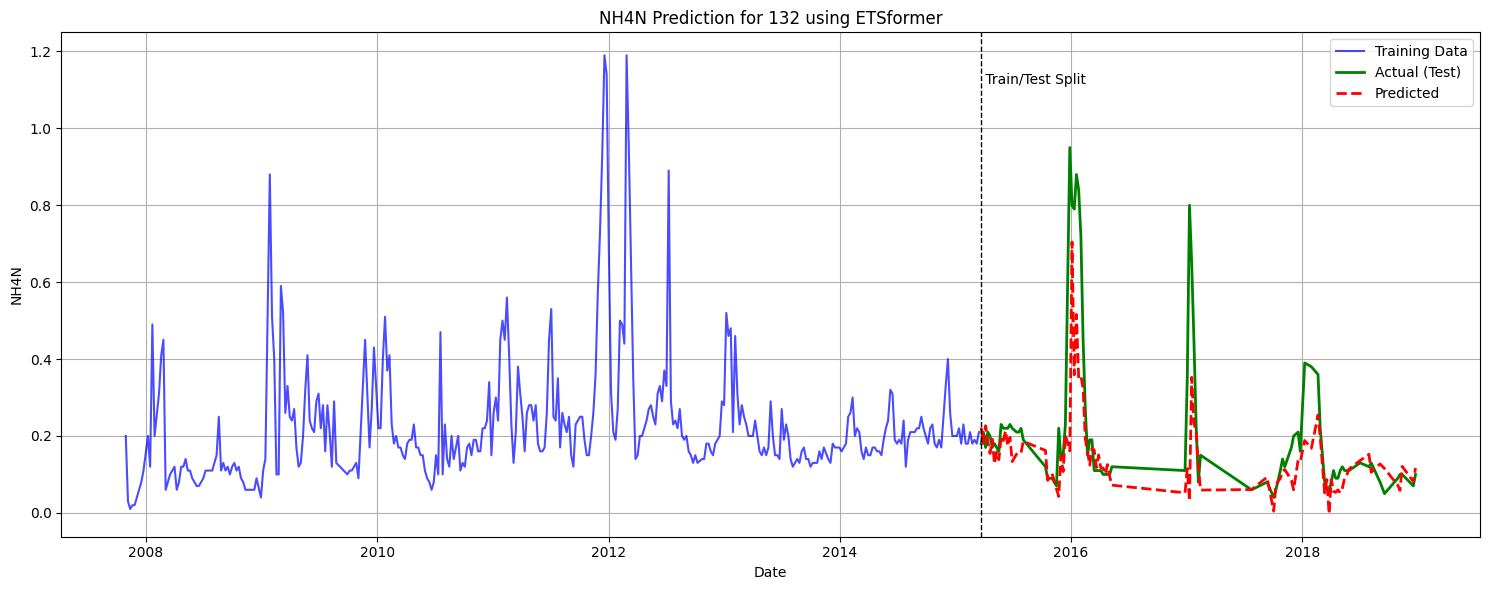

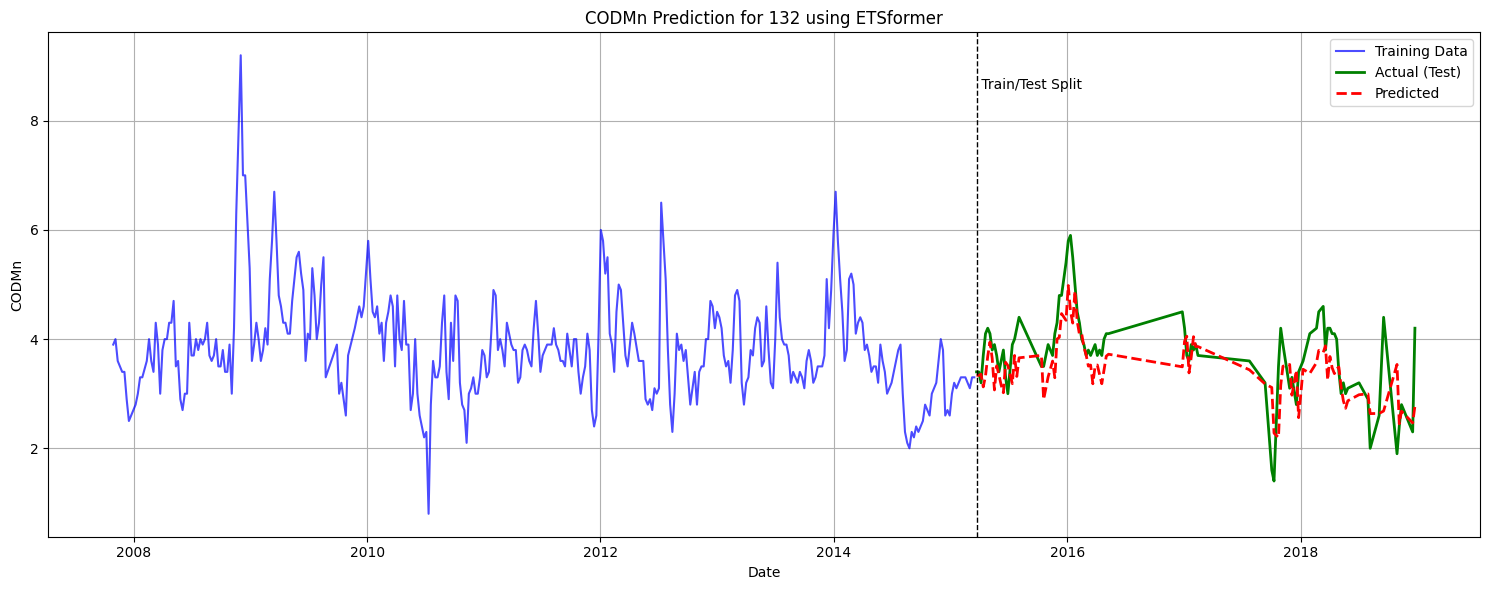

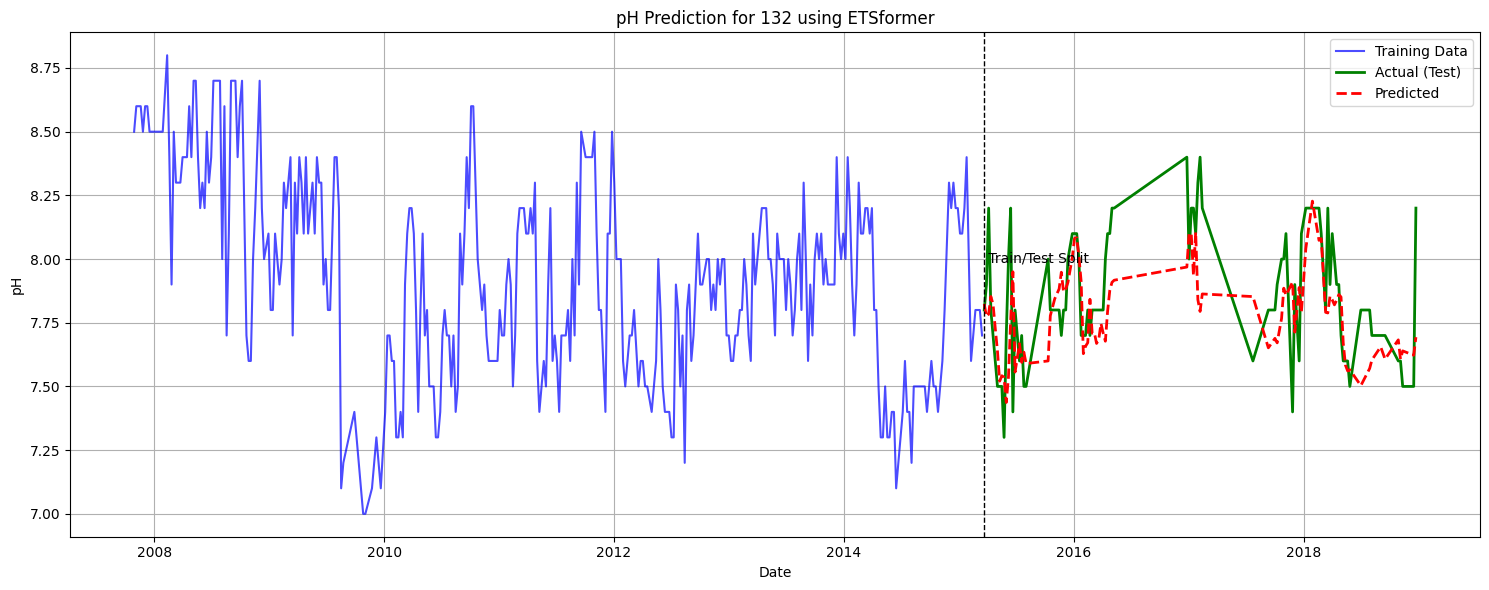

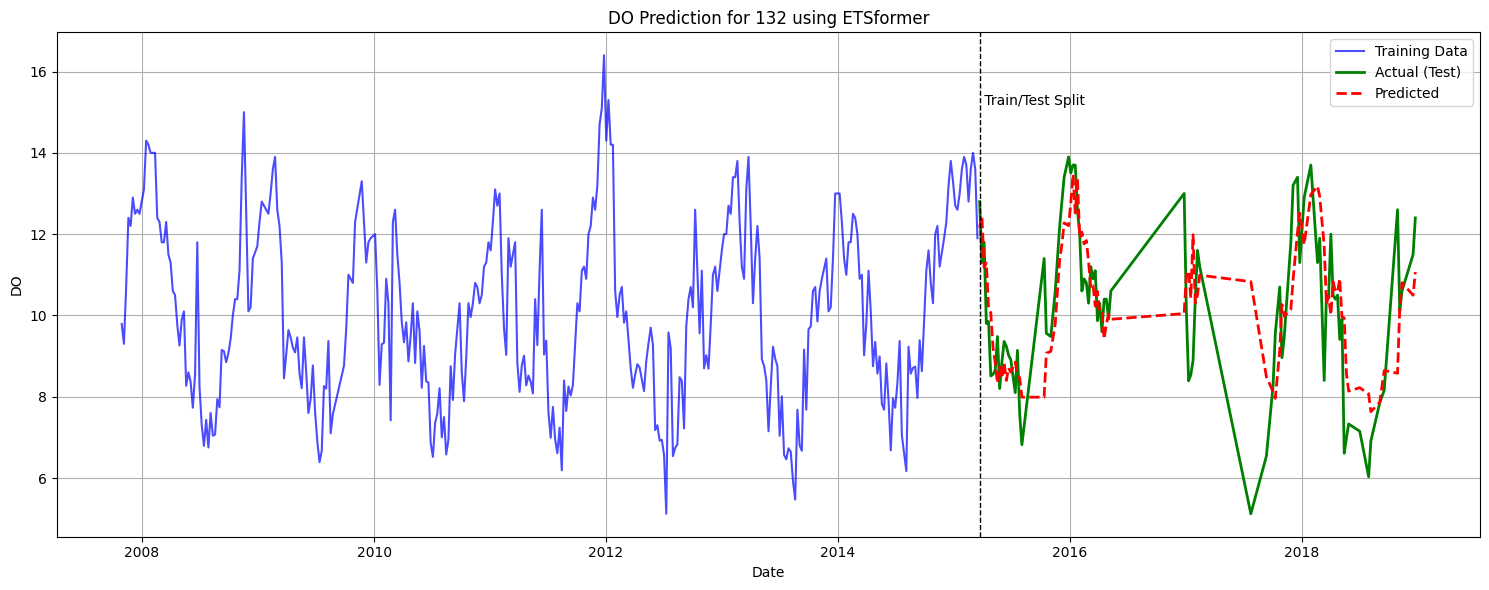

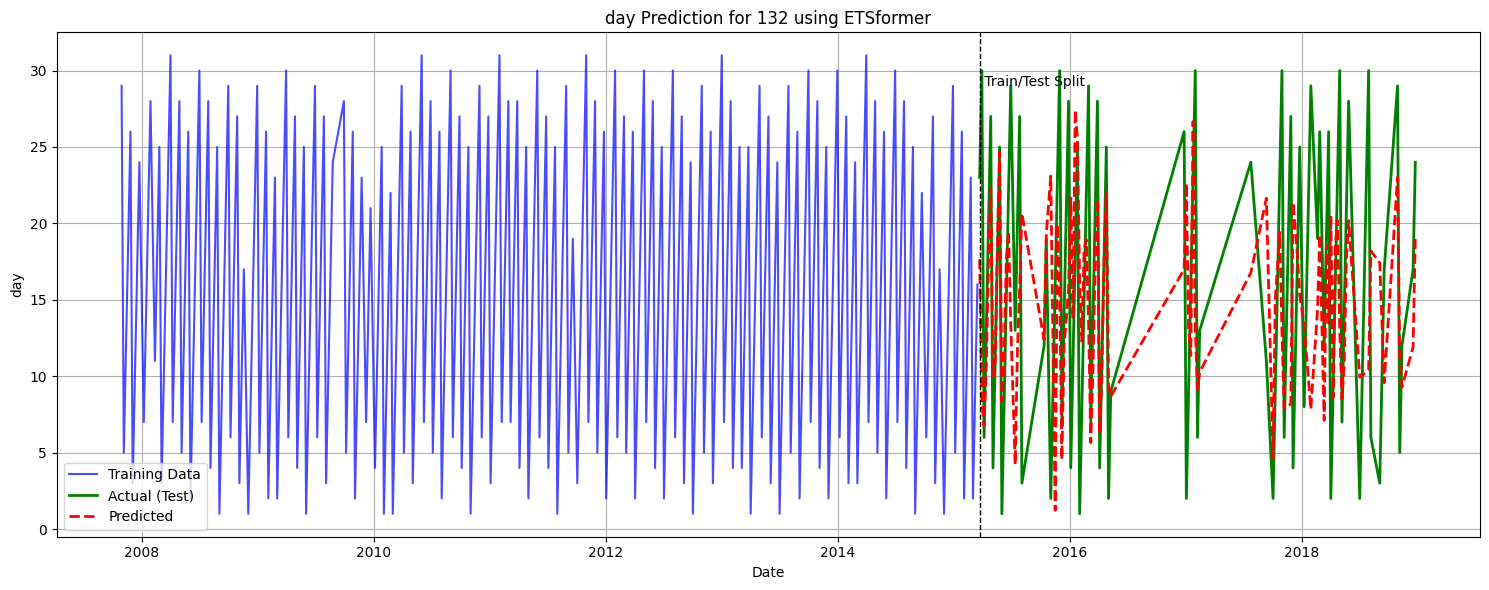

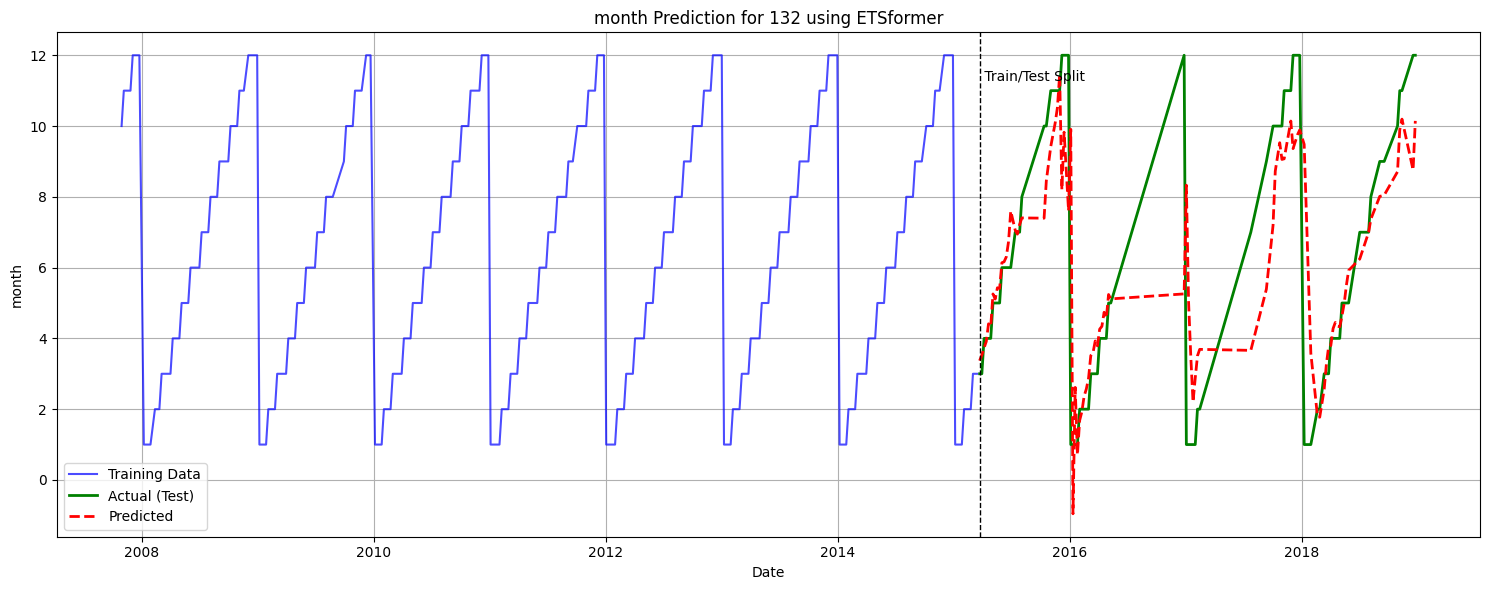

<ipython-input-7-f0cf2f07a8bb>:244: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


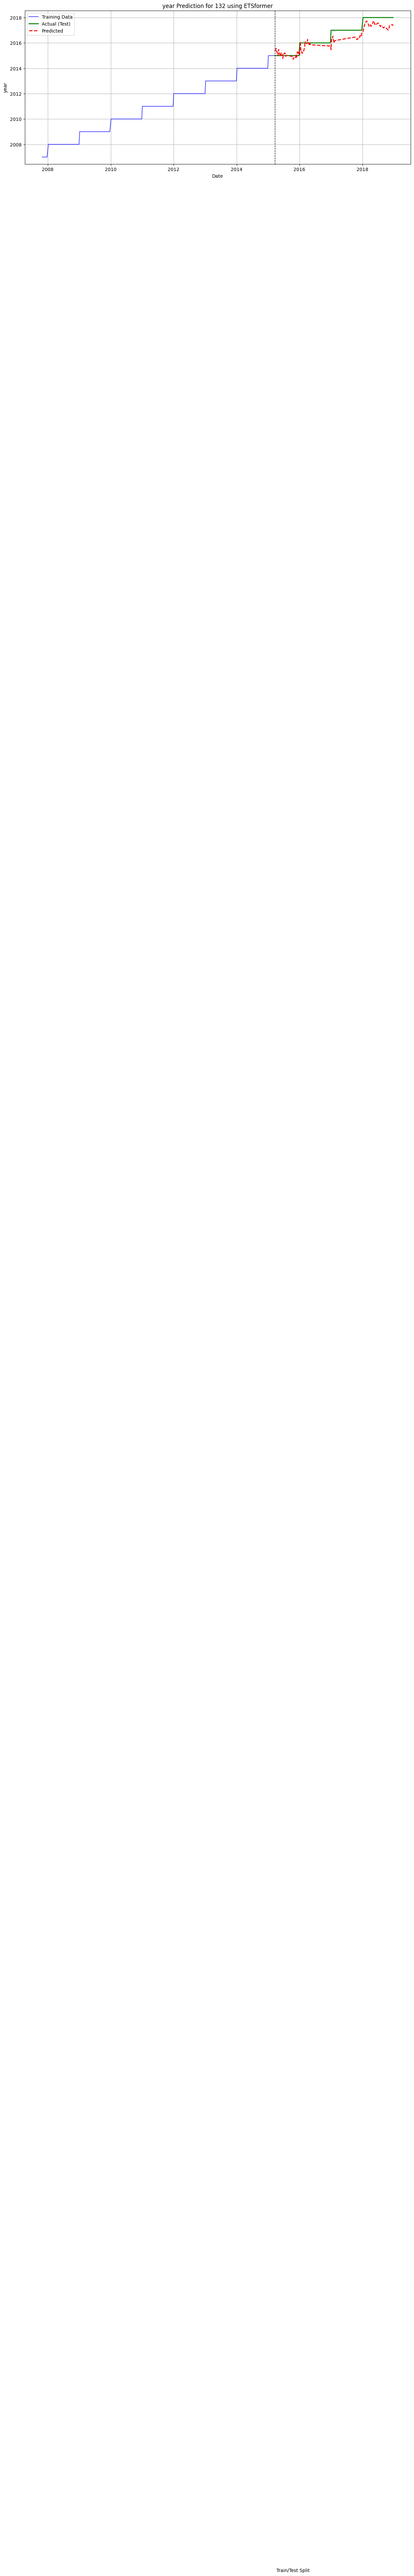

In [ ]:
# Define your features
features = ['NH4N', 'CODMn', 'pH', 'DO']

# Run the training and evaluation
results = train_etsformer_multivariate(pivot_df, features, seq_length=4, pred_length=1, epochs=120)

Modified ETSFormer

In [ ]:
import torch
import torch.nn as nn
from einops import rearrange, reduce, repeat


class DampingLayer(nn.Module):

    def __init__(self, pred_len, nhead, dropout=0.1, output_attention=False):
        super().__init__()
        self.pred_len = pred_len
        self.nhead = nhead
        self.output_attention = output_attention
        self._damping_factor = nn.Parameter(torch.randn(1, nhead))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = repeat(x, 'b 1 d -> b t d', t=self.pred_len)
        b, t, d = x.shape

        powers = torch.arange(self.pred_len).to(self._damping_factor.device) + 1
        powers = powers.view(self.pred_len, 1)
        damping_factors = self.damping_factor ** powers
        damping_factors = damping_factors.cumsum(dim=0)
        x = x.view(b, t, self.nhead, -1)
        x = self.dropout(x) * damping_factors.unsqueeze(-1)
        x = x.view(b, t, d)
        if self.output_attention:
            return x, damping_factors
        return x, None

    @property
    def damping_factor(self):
        return torch.sigmoid(self._damping_factor)


class DecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, c_out, pred_len, dropout=0.1, output_attention=False):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.c_out = c_out
        self.pred_len = pred_len
        self.output_attention = output_attention

        self.growth_damping = DampingLayer(pred_len, nhead, dropout=dropout, output_attention=output_attention)
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, growth, season):
        growth_horizon, growth_damping = self.growth_damping(growth[:, -1:])
        growth_horizon = self.dropout1(growth_horizon)

        seasonal_horizon = season[:, -self.pred_len:]

        if self.output_attention:
            return growth_horizon, seasonal_horizon, growth_damping
        return growth_horizon, seasonal_horizon, None


class Decoder(nn.Module):

    def __init__(self, layers):
        super().__init__()
        self.d_model = layers[0].d_model
        self.c_out = layers[0].c_out
        self.pred_len = layers[0].pred_len
        self.nhead = layers[0].nhead

        self.layers = nn.ModuleList(layers)
        self.pred = nn.Linear(self.d_model, self.c_out)

    def forward(self, growths, seasons):
        growth_repr = []
        season_repr = []
        growth_dampings = []

        for idx, layer in enumerate(self.layers):
            growth_horizon, season_horizon, growth_damping = layer(growths[idx], seasons[idx])
            growth_repr.append(growth_horizon)
            season_repr.append(season_horizon)
            growth_dampings.append(growth_damping)
        growth_repr = sum(growth_repr)
        season_repr = sum(season_repr)
        return self.pred(growth_repr), self.pred(season_repr), growth_dampings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft as fft

import numpy as np
from einops import rearrange, reduce, repeat
import math, random
from typing import List, Tuple, Optional


class GrowthLayer(nn.Module):

    def __init__(self, d_model, nhead, d_head=None, dropout=0.1, output_attention=False):
        super().__init__()
        self.d_head = d_head or (d_model // nhead)
        self.d_model = d_model
        self.nhead = nhead
        self.output_attention = output_attention

        self.z0 = nn.Parameter(torch.randn(self.nhead, self.d_head))
        self.in_proj = nn.Linear(self.d_model, self.d_head * self.nhead)
        self.es = ExponentialSmoothing(self.d_head, self.nhead, dropout=dropout)
        self.out_proj = nn.Linear(self.d_head * self.nhead, self.d_model)

        assert self.d_head * self.nhead == self.d_model, "d_model must be divisible by nhead"

    def forward(self, inputs):
        """
        :param inputs: shape: (batch, seq_len, dim)
        :return: shape: (batch, seq_len, dim)
        """
        b, t, d = inputs.shape
        values = self.in_proj(inputs).view(b, t, self.nhead, -1)
        values = torch.cat([repeat(self.z0, 'h d -> b 1 h d', b=b), values], dim=1)
        values = values[:, 1:] - values[:, :-1]
        out = self.es(values)
        out = torch.cat([repeat(self.es.v0, '1 1 h d -> b 1 h d', b=b), out], dim=1)
        out = rearrange(out, 'b t h d -> b t (h d)')
        out = self.out_proj(out)

        if self.output_attention:
            return out, self.es.get_exponential_weight(t)[1]
        return out, None


class FourierLayer(nn.Module):

    def __init__(self, d_model, pred_len, k=None, low_freq=1, output_attention=False):
        super().__init__()
        self.d_model = d_model
        self.pred_len = pred_len
        self.k = k
        self.low_freq = low_freq
        self.output_attention = output_attention

    def forward(self, x):
        """x: (b, t, d)"""

        if self.output_attention:
            return self.dft_forward(x)

        b, t, d = x.shape
        x_freq = fft.rfft(x, dim=1)

        if t % 2 == 0:
            x_freq = x_freq[:, self.low_freq:-1]
            f = fft.rfftfreq(t)[self.low_freq:-1]
        else:
            x_freq = x_freq[:, self.low_freq:]
            f = fft.rfftfreq(t)[self.low_freq:]

        x_freq, index_tuple = self.topk_freq(x_freq)
        f = repeat(f, 'f -> b f d', b=x_freq.size(0), d=x_freq.size(2))
        f = rearrange(f[index_tuple], 'b f d -> b f () d').to(x_freq.device)

        return self.extrapolate(x_freq, f, t), None

    def extrapolate(self, x_freq, f, t):
        x_freq = torch.cat([x_freq, x_freq.conj()], dim=1)
        f = torch.cat([f, -f], dim=1)
        t_val = rearrange(torch.arange(t + self.pred_len, dtype=torch.float),
                      't -> () () t ()').to(x_freq.device)

        amp = rearrange(x_freq.abs() / t, 'b f d -> b f () d')
        phase = rearrange(x_freq.angle(), 'b f d -> b f () d')

        x_time = amp * torch.cos(2 * math.pi * f * t_val + phase)

        return reduce(x_time, 'b f t d -> b t d', 'sum')

    def topk_freq(self, x_freq):
        values, indices = torch.topk(x_freq.abs(), self.k, dim=1, largest=True, sorted=True)
        mesh_a, mesh_b = torch.meshgrid(torch.arange(x_freq.size(0)), torch.arange(x_freq.size(2)))
        index_tuple = (mesh_a.unsqueeze(1), indices, mesh_b.unsqueeze(1))
        x_freq = x_freq[index_tuple]

        return x_freq, index_tuple

    def dft_forward(self, x):
        T = x.size(1)

        dft_mat = fft.fft(torch.eye(T))
        i, j = torch.meshgrid(torch.arange(self.pred_len + T), torch.arange(T))
        omega = np.exp(2 * math.pi * 1j / T)
        idft_mat = (np.power(omega, i * j) / T).cfloat()

        x_freq = torch.einsum('ft,btd->bfd', [dft_mat, x.cfloat()])

        if T % 2 == 0:
            x_freq = x_freq[:, self.low_freq:T // 2]
        else:
            x_freq = x_freq[:, self.low_freq:T // 2 + 1]

        _, indices = torch.topk(x_freq.abs(), self.k, dim=1, largest=True, sorted=True)
        indices = indices + self.low_freq
        indices = torch.cat([indices, -indices], dim=1)

        dft_mat = repeat(dft_mat, 'f t -> b f t d', b=x.shape[0], d=x.shape[-1])
        idft_mat = repeat(idft_mat, 't f -> b t f d', b=x.shape[0], d=x.shape[-1])

        mesh_a, mesh_b = torch.meshgrid(torch.arange(x.size(0)), torch.arange(x.size(2)))

        dft_mask = torch.zeros_like(dft_mat)
        dft_mask[mesh_a, indices, :, mesh_b] = 1
        dft_mat = dft_mat * dft_mask

        idft_mask = torch.zeros_like(idft_mat)
        idft_mask[mesh_a, :, indices, mesh_b] = 1
        idft_mat = idft_mat * idft_mask

        attn = torch.einsum('bofd,bftd->botd', [idft_mat, dft_mat]).real
        return torch.einsum('botd,btd->bod', [attn, x]), rearrange(attn, 'b o t d -> b d o t')


class LevelLayer(nn.Module):

    def __init__(self, d_model, c_out, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.c_out = c_out

        self.es = ExponentialSmoothing(1, self.c_out, dropout=dropout, aux=True)
        self.growth_pred = nn.Linear(self.d_model, self.c_out)
        self.season_pred = nn.Linear(self.d_model, self.c_out)

    def forward(self, level, growth, season):
        b, t, _ = level.shape
        growth = self.growth_pred(growth).view(b, t, self.c_out, 1)
        season = self.season_pred(season).view(b, t, self.c_out, 1)
        growth = growth.view(b, t, self.c_out, 1)
        season = season.view(b, t, self.c_out, 1)
        level = level.view(b, t, self.c_out, 1)
        out = self.es(level - season, aux_values=growth)
        out = rearrange(out, 'b t h d -> b t (h d)')
        return out

class EncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, c_out, seq_len, pred_len, k, dim_feedforward=None, dropout=0.1,
                 activation='sigmoid', layer_norm_eps=1e-5, output_attention=False):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.c_out = c_out
        self.seq_len = seq_len
        self.pred_len = pred_len
        dim_feedforward = dim_feedforward or 4 * d_model
        self.dim_feedforward = dim_feedforward
        self.output_attention = output_attention # Store output_attention flag

        self.growth_layer = GrowthLayer(d_model, nhead, dropout=dropout, output_attention=output_attention)
        self.seasonal_layer = FourierLayer(d_model, pred_len, k=k, output_attention=output_attention)
        self.level_layer = LevelLayer(d_model, c_out, dropout=dropout)

        # Implementation of Feedforward model
        self.ff = Feedforward(d_model, dim_feedforward, dropout=dropout, activation=activation)
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, res, level, attn_mask=None):
        # Make copies or ensure operations don't modify inputs in-place if shared across heads
        res_copy = res.clone() # Use clone if layers modify res in-place before all uses
        level_copy = level.clone() # Use clone if layers modify level in-place

        season, season_attn = self._season_block(res_copy)
        # Adjust slicing for season based on whether pred_len is included
        res_for_growth = res_copy - season[:, :-self.pred_len] # Original logic

        growth, growth_attn = self._growth_block(res_for_growth)
        # Adjust slicing for growth based on whether the initial z0 state is included
        res_after_growth = self.norm1(res_for_growth - growth[:, 1:]) # Original logic

        res_ff = self.norm2(res_after_growth + self.ff(res_after_growth))

        # Level layer uses original level input, growth, and season components
        # Ensure correct slicing for growth and season inputs to LevelLayer
        level_out = self.level_layer(level_copy, growth[:, :-1], season[:, :-self.pred_len]) # Original logic

        # Return the final residual (res_ff), updated level, and components
        return res_ff, level_out, growth, season, season_attn, growth_attn

    def _growth_block(self, x):
        x_out, growth_attn = self.growth_layer(x)
        return self.dropout1(x_out), growth_attn

    def _season_block(self, x):
        x_out, season_attn = self.seasonal_layer(x)
        return self.dropout2(x_out), season_attn


class Encoder(nn.Module):

    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, res, level, attn_mask=None):
        growths = []
        seasons = []
        season_attns = []
        growth_attns = []
        for layer in self.layers:
            res, level, growth, season, season_attn, growth_attn = layer(res, level, attn_mask=None)
            growths.append(growth)
            seasons.append(season)
            season_attns.append(season_attn)
            growth_attns.append(growth_attn)

        return level, growths, seasons, season_attns, growth_attns
        import math

import torch
import torch.nn as nn
import torch.fft as fft

from einops import rearrange, reduce, repeat
from scipy.fftpack import next_fast_len


def conv1d_fft(f, g, dim=-1):
    N = f.size(dim)
    M = g.size(dim)

    fast_len = next_fast_len(N + M - 1)

    F_f = fft.rfft(f, fast_len, dim=dim)
    F_g = fft.rfft(g, fast_len, dim=dim)

    F_fg = F_f * F_g.conj()
    out = fft.irfft(F_fg, fast_len, dim=dim)
    out = out.roll((-1,), dims=(dim,))
    idx = torch.as_tensor(range(fast_len - N, fast_len)).to(out.device)
    out = out.index_select(dim, idx)

    return out


class ExponentialSmoothing(nn.Module):

    def __init__(self, dim, nhead, dropout=0.1, aux=False):
        super().__init__()
        self._smoothing_weight = nn.Parameter(torch.randn(nhead, 1))
        self.v0 = nn.Parameter(torch.randn(1, 1, nhead, dim))
        self.dropout = nn.Dropout(dropout)
        if aux:
            self.aux_dropout = nn.Dropout(dropout)

    def forward(self, values, aux_values=None):
        b, t, h, d = values.shape

        init_weight, weight = self.get_exponential_weight(t)
        output = conv1d_fft(self.dropout(values), weight, dim=1)
        output = init_weight * self.v0 + output

        if aux_values is not None:
            aux_weight = weight / (1 - self.weight) * self.weight
            aux_output = conv1d_fft(self.aux_dropout(aux_values), aux_weight)
            output = output + aux_output

        return output

    def get_exponential_weight(self, T):
        # Generate array [0, 1, ..., T-1]
        powers = torch.arange(T, dtype=torch.float, device=self.weight.device)

        # (1 - \alpha) * \alpha^t, for all t = T-1, T-2, ..., 0]
        weight = (1 - self.weight) * (self.weight ** torch.flip(powers, dims=(0,)))

        # \alpha^t for all t = 1, 2, ..., T
        init_weight = self.weight ** (powers + 1)

        return rearrange(init_weight, 'h t -> 1 t h 1'), \
               rearrange(weight, 'h t -> 1 t h 1')

    @property
    def weight(self):
        return torch.sigmoid(self._smoothing_weight)
import torch
import torch.nn as nn
from einops import reduce

class Transform:
    def __init__(self, sigma):
        self.sigma = sigma

    @torch.no_grad()
    def transform(self, x):
        return self.jitter(self.shift(self.scale(x)))

    def jitter(self, x):
        return x + (torch.randn(x.shape).to(x.device) * self.sigma)

    def scale(self, x):
        return x * (torch.randn(x.size(-1)).to(x.device) * self.sigma + 1)

    def shift(self, x):
        return x + (torch.randn(x.size(-1)).to(x.device) * self.sigma)


# --- New MultiHeadEncoder ---
class MultiHeadEncoder(nn.Module):
    """
    Encoder that processes inputs in parallel across multiple 'heads',
    where each head is an instance of the original EncoderLayer.
    Outputs are aggregated.
    """
    def __init__(self, layers: List[EncoderLayer]):
        super().__init__()
        if not layers:
            raise ValueError("MultiHeadEncoder requires at least one EncoderLayer.")
        self.heads = nn.ModuleList(layers)
        self.num_heads = len(layers)
        # Store output_attention flag from the first layer (assuming it's consistent)
        self.output_attention = layers[0].output_attention

    def forward(self, res: torch.Tensor, level: torch.Tensor, attn_mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, List[torch.Tensor], List[torch.Tensor], List[Optional[torch.Tensor]], List[Optional[torch.Tensor]]]:
        """
        Forward pass for the MultiHeadEncoder.

        Args:
            res: Residual tensor from embedding (batch, seq_len, d_model).
            level: Initial level tensor, usually the raw input (batch, seq_len, c_out).
                   Passed to each head's LevelLayer.
            attn_mask: Optional attention mask (not used by ETSformer layers).

        Returns:
            final_level: Aggregated (averaged) level tensor from all heads.
            all_growths: List of growth tensors from each head.
            all_seasons: List of season tensors from each head.
            all_season_attns: List of season attention tensors from each head (if output_attention=True).
            all_growth_attns: List of growth attention tensors from each head (if output_attention=True).
        """
        all_levels = []
        all_growths = []
        all_seasons = []
        all_season_attns = []
        all_growth_attns = []

        # Process each head in parallel on the *same* initial input
        for head_layer in self.heads:
            # Each layer takes the *original* res and level.
            # The EncoderLayer's forward should handle internal operations correctly.
            # It returns: res_ff, level_out, growth, season, season_attn, growth_attn
            _res_head, level_head, growth_head, season_head, season_attn_head, growth_attn_head = head_layer(res, level, attn_mask=attn_mask)

            # Collect outputs from this head
            all_levels.append(level_head)
            all_growths.append(growth_head)
            all_seasons.append(season_head)
            if self.output_attention:
                 all_season_attns.append(season_attn_head)
                 all_growth_attns.append(growth_attn_head)
            else:
                 all_season_attns.append(None)
                 all_growth_attns.append(None)
            # We don't need the aggregated residual (_res_head) for the final output signature

        # Aggregate the level outputs from all heads by averaging
        final_level = torch.stack(all_levels).mean(dim=0)

        # The growths, seasons, and attentions remain as lists, one item per head.
        # This matches the input structure expected by the original Decoder.
        return final_level, all_growths, all_seasons, all_season_attns, all_growth_attns


# --- Modified ETSformer ---
class ETSformer(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len

        self.configs = configs

        # Note: The original code asserted e_layers == d_layers.
        # This might still be relevant depending on how you interpret the layers.
        # If e_layers now means "number of heads", it doesn't need to equal d_layers.
        # assert configs.e_layers == configs.d_layers, "Encoder and decoder layers must be equal"
        # Let's keep the assertion commented out or remove it if e_layers now means num_heads.

        # Embedding
        self.enc_embedding = ETSEmbedding(configs.enc_in, configs.d_model, dropout=configs.dropout)

        # --- Encoder Modification ---
        # Create a list of EncoderLayer instances (these will be the "heads")
        encoder_layers = [
            EncoderLayer(
                configs.d_model, configs.n_heads, configs.c_out, configs.seq_len, configs.pred_len, configs.K,
                dim_feedforward=configs.d_ff,
                dropout=configs.dropout,
                activation=configs.activation,
                output_attention=configs.output_attention,
            ) for _ in range(configs.e_layers) # configs.e_layers now defines the number of heads
        ]
        # Use the new MultiHeadEncoder
        self.encoder = MultiHeadEncoder(encoder_layers)
        # --- End Encoder Modification ---

        # Decoder (Unchanged, it expects lists of growths/seasons)
        self.decoder = Decoder(
            [
                DecoderLayer(
                    configs.d_model, configs.n_heads, configs.c_out, configs.pred_len,
                    dropout=configs.dropout,
                    output_attention=configs.output_attention,
                ) for _ in range(configs.d_layers) # d_layers determines decoder depth
            ],
        )

        self.transform = Transform(sigma=self.configs.std)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None,
                decomposed=False, attention=False):
        with torch.no_grad():
            if self.training:
                x_enc = self.transform.transform(x_enc)

        res = self.enc_embedding(x_enc)

        # Call the MultiHeadEncoder. It returns the aggregated level and lists of components.
        # The input 'level' to the encoder is the raw x_enc.
        level, growths, seasons, season_attns, growth_attns = self.encoder(res, x_enc, attn_mask=enc_self_mask)
        # Note: The 'level' returned here is the *aggregated* level from the encoder heads.

        # The Decoder expects lists of growths and seasons, which is what MultiHeadEncoder provides.
        # However, the number of items in these lists now corresponds to e_layers (num_heads),
        # while the number of layers in the Decoder corresponds to d_layers.
        # We need to ensure this mismatch is handled correctly. The original Decoder sums the outputs
        # from its layers. If e_layers != d_layers, the Decoder needs adjustment or clarification.

        # --- Potential Issue & Solution ---
        # If e_layers (num heads) != d_layers (decoder layers), the original Decoder won't work directly
        # as it expects len(growths) == len(decoder.layers).
        # Option 1: Assert e_layers == d_layers. Simplest.
        # Option 2: Modify Decoder to handle mismatched lengths (e.g., average growths/seasons before passing to Decoder layers, or use only the first d_layers items).
        # Option 3: Redesign Decoder.

        # Assuming Option 1 (e_layers == d_layers) for now, as per the original code's assertion.
        if len(growths) != len(self.decoder.layers):
             raise ValueError(f"Number of encoder heads ({len(growths)}) must match number of decoder layers ({len(self.decoder.layers)}) for the current Decoder implementation.")

        growth, season, growth_dampings = self.decoder(growths, seasons) # Pass lists directly

        # Use the *final aggregated level* from the encoder for the prediction.
        # The original code used level[:, -1:], implying the level tensor had a time dimension.
        # Our aggregated level should also have this time dimension.
        final_encoder_level = level[:, -1:] # Take the last time step of the aggregated level

        if decomposed:
            return final_encoder_level, growth, season

        preds = final_encoder_level + growth + season # Combine aggregated level with decoded growth/season

        # --- Attention Output Handling (Needs Adjustment) ---
        if attention:
            # The original attention calculation assumed sequential layers.
            # With parallel heads, how should attention be combined?
            # Option A: Average attention across heads.
            # Option B: Return attention for each head separately (more complex).

            # Let's try averaging across heads (dim=0 of the stacked tensors)
            # Ensure attention tensors are not None before stacking/reducing
            valid_season_attns = [attn for attn in season_attns if attn is not None]
            valid_growth_attns = [attn for attn in growth_attns if attn is not None]
            valid_growth_dampings = [damp for damp in growth_dampings if damp is not None]

            if not valid_season_attns or not valid_growth_attns or not valid_growth_dampings:
                 # Handle case where attention is not computed or output_attention=False
                 # Maybe return None or raise error? Returning None for simplicity.
                 print("Warning: Attention requested but not available from all components.")
                 return preds, None, None # Or handle as appropriate

            # Calculate decoder_growth_attns per head
            decoder_growth_attns_per_head = []
            # Ensure growth_attns and growth_dampings lists have the same length (should match e_layers/d_layers)
            for growth_attn_head, growth_damping_head in zip(valid_growth_attns, valid_growth_dampings):
                 # Original einsum: 'bth,oh->bhot' (assuming growth_attn is [b, t, h] and damping is [o, h])
                 # Check shapes: growth_attn might be [b, d, t] or similar from FourierLayer/GrowthLayer output_attention
                 # Need to verify the exact shapes returned by _season_block and _growth_block when output_attention=True
                 # Assuming growth_attn is [b, t, nhead] and damping is [pred_len, nhead] -> [b, nhead, pred_len, t]?
                 # Let's assume the original einsum logic is adaptable per head.
                 # Placeholder: Adjust einsum based on actual shapes if needed.
                 # If growth_attn is (b, t, h_dim) and damping is (pred_len, h_dim)
                 # We might need 'b t h, p h -> b p t' (p=pred_len)
                 # The original code had squeeze(-1) suggesting attn was (b, t, h, 1)?
                 # Let's stick to the original einsum for now, assuming shapes align per head.
                 # Ensure growth_attn_head is not None
                 if growth_attn_head is not None and growth_damping_head is not None:
                    decoder_growth_attns_per_head.append(torch.einsum('bth,oh->bhot', [growth_attn_head.squeeze(-1), growth_damping_head]))
                 else:
                    decoder_growth_attns_per_head.append(None) # Append None if attention missing for a head

            # Filter out None values before stacking
            valid_decoder_growth_attns = [attn for attn in decoder_growth_attns_per_head if attn is not None]
            if not valid_decoder_growth_attns:
                 print("Warning: Decoder growth attention could not be computed.")
                 return preds, None, None

            # Stack attentions from different heads along a new dimension (dim=0)
            stacked_season_attns = torch.stack(valid_season_attns, dim=0) # Shape: [num_heads, b, d, o, t] or similar
            stacked_decoder_growth_attns = torch.stack(valid_decoder_growth_attns, dim=0) # Shape: [num_heads, b, h, o, t] or similar

            # Average across the heads (dim=0) and select the prediction length
            # Adjust slicing/reduction based on actual attention shapes
            avg_season_attns = reduce(stacked_season_attns, 'h b d o t -> b o t', reduction='mean')[:, -self.pred_len:] # Example reduction
            avg_decoder_growth_attns = reduce(stacked_decoder_growth_attns, 'h b d o t -> b o t', reduction='mean')[:, -self.pred_len:] # Example reduction

            # Ensure the reduction dimensions and slicing are correct for your attention shapes
            # The original code reduced 'l b d o t -> b o t' where l was the sequential layer index.
            # Here, the first dimension 'h' is the head index.

            return preds, avg_season_attns, avg_decoder_growth_attns # Return averaged attentions

        return preds # Return predictions only
import torch.nn as nn
import torch.nn.functional as F


class ETSEmbedding(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                              kernel_size=3, padding=1, bias=False)
        self.dropout = nn.Dropout(p=dropout)
        nn.init.kaiming_normal_(self.conv.weight)

    def forward(self, x,):
        x = self.conv(x.permute(0,2,1))[..., :-2]
        return self.dropout(x.transpose(1,2))


class Feedforward(nn.Module):
    def __init__(self, d_model, dim_feedforward, dropout=0.1, activation='sigmoid'):
        # Implementation of Feedforward model
        super().__init__()
        self.linear1 = nn.Linear(d_model, dim_feedforward, bias=False)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, bias=False)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = getattr(F, activation)

    def forward(self, x):
        x = self.linear2(self.dropout1(self.activation(self.linear1(x))))
        return self.dropout2(x)

In [ ]:
# Define your features
features = ['NH4N', 'CODMn', 'pH', 'DO']

# Run the training and evaluation
results = train_etsformer_multivariate(pivot_df, features, seq_length=7, pred_length=1, epochs=120)

NameError: name 'train_etsformer_multivariate' is not defined

2 stack multihead attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft as fft

import numpy as np
from einops import rearrange, reduce, repeat
import math, random
from typing import List, Tuple, Optional
from scipy.fftpack import next_fast_len
from einops import rearrange, reduce, repeat
import torch.fft as fft

from einops import rearrange, reduce, repeat
from scipy.fftpack import next_fast_len

class Transform:
    def __init__(self, sigma):
        self.sigma = sigma

    @torch.no_grad()
    def transform(self, x):
        return self.jitter(self.shift(self.scale(x)))

    def jitter(self, x):
        return x + (torch.randn(x.shape).to(x.device) * self.sigma)

    def scale(self, x):
        return x * (torch.randn(x.size(-1)).to(x.device) * self.sigma + 1)

    def shift(self, x):
        return x + (torch.randn(x.size(-1)).to(x.device) * self.sigma)


def conv1d_fft(f, g, dim=-1):
    N = f.size(dim)
    M = g.size(dim)

    fast_len = next_fast_len(N + M - 1)

    F_f = fft.rfft(f, fast_len, dim=dim)
    F_g = fft.rfft(g, fast_len, dim=dim)

    F_fg = F_f * F_g.conj()
    out = fft.irfft(F_fg, fast_len, dim=dim)
    out = out.roll((-1,), dims=(dim,))
    idx = torch.as_tensor(range(fast_len - N, fast_len)).to(out.device)
    out = out.index_select(dim, idx)

    return out


class ExponentialSmoothing(nn.Module):

    def __init__(self, dim, nhead, dropout=0.1, aux=False):
        super().__init__()
        self._smoothing_weight = nn.Parameter(torch.randn(nhead, 1))
        self.v0 = nn.Parameter(torch.randn(1, 1, nhead, dim))
        self.dropout = nn.Dropout(dropout)
        if aux:
            self.aux_dropout = nn.Dropout(dropout)

    def forward(self, values, aux_values=None):
        b, t, h, d = values.shape

        init_weight, weight = self.get_exponential_weight(t)
        output = conv1d_fft(self.dropout(values), weight, dim=1)
        output = init_weight * self.v0 + output

        if aux_values is not None:
            aux_weight = weight / (1 - self.weight) * self.weight
            aux_output = conv1d_fft(self.aux_dropout(aux_values), aux_weight)
            output = output + aux_output

        return output

    def get_exponential_weight(self, T):
        # Generate array [0, 1, ..., T-1]
        powers = torch.arange(T, dtype=torch.float, device=self.weight.device)

        # (1 - \alpha) * \alpha^t, for all t = T-1, T-2, ..., 0]
        weight = (1 - self.weight) * (self.weight ** torch.flip(powers, dims=(0,)))

        # \alpha^t for all t = 1, 2, ..., T
        init_weight = self.weight ** (powers + 1)

        return rearrange(init_weight, 'h t -> 1 t h 1'), \
               rearrange(weight, 'h t -> 1 t h 1')

    @property
    def weight(self):
        return torch.sigmoid(self._smoothing_weight)

class ETSEmbedding(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super().__init__()
        kernel_size = 3
        # Calculate padding to maintain sequence length: (kernel_size - 1) // 2
        padding = 1 # For kernel=3, padding=2
        self.conv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                              kernel_size=kernel_size, padding=padding, bias=False)
        self.dropout = nn.Dropout(p=dropout)
        nn.init.kaiming_normal_(self.conv.weight)

    def forward(self, x):
        # x shape: (batch, seq_len, c_in)
        x = x.permute(0, 2, 1) # Shape: (batch, c_in, seq_len)
        # Conv1d output with correct padding should have same length as input
        x = self.conv(x) # Shape: (batch, d_model, seq_len)
        # --- REMOVE THE SLICING ---
        # x = x[..., :-2] # <--- REMOVE THIS LINE
        # --- END REMOVAL ---
        x = x.transpose(1, 2) # Shape: (batch, seq_len, d_model)
        return self.dropout(x)


class Feedforward(nn.Module):
    def __init__(self, d_model, dim_feedforward, dropout=0.1, activation='sigmoid'):
        # Implementation of Feedforward model
        super().__init__()
        self.linear1 = nn.Linear(d_model, dim_feedforward, bias=False)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, bias=False)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = getattr(F, activation)

    def forward(self, x):
        x = self.linear2(self.dropout1(self.activation(self.linear1(x))))
        return self.dropout2(x)

class ExponentialSmoothing(nn.Module):
    def __init__(self, dim, nhead, dropout=0.1, aux=False, identifier=""): # Added identifier
        super().__init__()
        self.nhead = max(1, nhead)
        self.dim = dim # Dimension PER HEAD
        self.identifier = identifier # Store identifier

        # --- CORRECTED INITIALIZATION ---
        self.v0 = nn.Parameter(torch.randn(1, 1, self.nhead, self.dim))
        # --- END CORRECTION ---

        # --- DEBUG PRINT ---
        # print(f"ES Init ({self.identifier}): nhead={self.nhead}, dim={self.dim}, Requested v0 last dim={self.dim}, Actual v0 shape={self.v0.shape}")
        # --- END DEBUG ---

        self._smoothing_weight = nn.Parameter(torch.randn(self.nhead, 1))
        self.dropout = nn.Dropout(dropout)
        self.aux = aux
        if aux:
            self.aux_dropout = nn.Dropout(dropout)

    def forward(self, values, aux_values=None):
        # values shape: (b, t, h, d) where d should == self.dim
        b, t, h, d = values.shape

        # --- DEBUG PRINT ---
        # print(f"ES Forward ({self.identifier}): Instance dim={self.dim}, Input values last dim (d)={d}, v0 shape={self.v0.shape}")
        if d != self.dim:
             print(f"----> ERROR: Instance dim ({self.dim}) != Input values last dim ({d}) <----")
             # This check should ideally prevent the crash later if it fails
             # raise ValueError(f"Input dimension d ({d}) does not match self.dim ({self.dim})") # Or just print
        # --- END DEBUG ---


        if d != self.dim:
             # If the check above fails, maybe return zeros to avoid crash, although the root cause needs fixing
             # print(f"----> WARNING: Dimension mismatch detected in ES ({self.identifier}). Returning zeros. <----")
             return torch.zeros_like(values)


        init_weight, weight = self.get_exponential_weight(t) # Shape: [1, t, h, 1]

        values_dropped = self.dropout(values)
        output = conv1d_fft(values_dropped, weight, dim=1) # Shape: (b, t, h, d)

        # --- DEBUG PRINT ---
        term_a = init_weight * self.v0
        # print(f"ES Forward ({self.identifier}) - Before Add: init_weight*v0 shape={term_a.shape}, output shape={output.shape}")
        # --- END DEBUG ---


        # v0 shape (1, 1, h, d), init_weight shape (1, t, h, 1)
        # init_weight * v0 broadcasts to (1, t, h, d)
        # output shape (b, t, h, d)
        output = term_a + output # Error occurs here if shapes mismatch

        if self.aux and aux_values is not None:
            # ... (auxiliary calculation part) ...
            if aux_values.shape != values.shape:
                 # This check might be important if LevelLayer's ES is somehow getting wrong aux shapes
                 print(f"----> WARNING: Aux values shape mismatch in ES ({self.identifier}) <----")
                 # raise ValueError(f"aux_values shape {aux_values.shape} must match values shape {values.shape}")
            else:
                 alpha = torch.sigmoid(self._smoothing_weight).view(1, 1, h, 1)
                 safe_denom = torch.clamp(1 - alpha, min=1e-6)
                 aux_weight = weight / safe_denom * alpha
                 aux_values_dropped = self.aux_dropout(aux_values)
                 aux_output = conv1d_fft(aux_values_dropped, aux_weight, dim=1)
                 output = output + aux_output # Add aux component
        return output

    # get_exponential_weight and weight property remain the same
    def get_exponential_weight(self, T):
        powers = torch.arange(T, dtype=torch.float, device=self.weight.device)
        init_weight = self.weight ** (powers + 1)
        weight = (1 - self.weight) * (self.weight ** torch.flip(powers, dims=(0,)))
        return rearrange(init_weight, 'h t -> 1 t h 1'), \
               rearrange(weight, 'h t -> 1 t h 1')

    @property
    def weight(self):
        return torch.sigmoid(self._smoothing_weight)

class GrowthLayer(nn.Module):
    def __init__(self, d_model, nhead, d_head=None, dropout=0.1, output_attention=False):
        super().__init__()
        # ... (other initializations) ...
        self.nhead = nhead
        self.d_head = d_head or (d_model // max(1, nhead))
        self.d_model = d_model
        # ... (value checks) ...
        self.z0 = nn.Parameter(torch.randn(self.nhead, self.d_head))
        self.in_proj = nn.Linear(self.d_model, self.d_head * self.nhead)
        self.output_attention = output_attention
        # Pass d_head as dim and an identifier
        self.es = ExponentialSmoothing(self.d_head, self.nhead, dropout=dropout, identifier="GrowthLayer_ES") # Added identifier
        self.out_proj = nn.Linear(self.d_head * self.nhead, self.d_model)
    # ... (forward method) ...
    def forward(self, inputs):
        b, t, _ = inputs.shape
        values = self.in_proj(inputs).view(b, t, self.nhead, self.d_head)
        z0_repeated = repeat(self.z0, 'h d -> b 1 h d', b=b)
        values_with_z0 = torch.cat([z0_repeated, values], dim=1)
        diffs = values_with_z0[:, 1:] - values_with_z0[:, :-1] # Shape: (b, t, h, d_head)
        smoothed_diffs = self.es(diffs) # Call ES forward
        v0_repeated = repeat(self.es.v0, '1 1 h d -> b 1 h d', b=b) # v0 now has d_head in last dim
        out_with_v0 = torch.cat([v0_repeated, smoothed_diffs], dim=1) # Shape: (b, t+1, h, d_head)
        out_reshaped = rearrange(out_with_v0, 'b time h d -> b time (h d)')
        out_final = self.out_proj(out_reshaped) # Shape: (b, t+1, d_model)

        if self.output_attention:
            _, attn_weights = self.es.get_exponential_weight(t) # Shape: [1, t, h, 1]
            attn = repeat(attn_weights, '1 t h 1 -> b t h 1', b=b)
            return out_final, attn
        return out_final, None


class LevelLayer(nn.Module):
    def __init__(self, d_model, c_out, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.c_out = c_out

        self.es = ExponentialSmoothing(dim=1, nhead=self.c_out, dropout=dropout, aux=True, identifier="LevelLayer_ES") # Added identifier
        self.growth_pred = nn.Linear(self.d_model, self.c_out)
        self.season_pred = nn.Linear(self.d_model, self.c_out)
    # ... (forward method) ...
    def forward(self, level, growth, season):
        b, t_level, _ = level.shape # level is (b, t, c_out)
        common_t = t_level

        growth_sliced = growth[:, 1:common_t+1, :]
        season_sliced = season[:, :common_t, :]

        growth_proj = self.growth_pred(growth_sliced)
        season_proj = self.season_pred(season_sliced)

        level_reshaped = rearrange(level, 'b t h -> b t h 1')
        season_reshaped = rearrange(season_proj, 'b t h -> b t h 1')
        growth_reshaped = rearrange(growth_proj, 'b t h -> b t h 1')

        es_input = level_reshaped - season_reshaped
        level_output_reshaped = self.es(es_input, aux_values=growth_reshaped) # Call ES forward
        level_output = rearrange(level_output_reshaped, 'b t h 1 -> b t h')
        return level_output

# --- Fourier Layer (Seasonal) ---
class FourierLayer(nn.Module):
    def __init__(self, d_model, pred_len, k=None, low_freq=1, output_attention=False):
        super().__init__()
        self.d_model = d_model
        self.pred_len = pred_len
        self.k = k
        self.low_freq = low_freq
        self.output_attention = output_attention

    def forward(self, x):
        """x: (b, t, d)"""
        b, t, d = x.shape

        if self.k is None or self.k >= t // 2:
             # Avoid issues if k is too large or None; use all frequencies
            if t % 2 == 0:
                k_ = t//2 - self.low_freq -1 # Max possible k excluding DC and
            else:
                k_ = t//2 - self.low_freq # Max possible k excluding DC
            k_ = max(1, k_) # Ensure k is at least 1
            # print(f"Warning: k adjusted from {self.k} to {k_} for FourierLayer (t={t}, low_freq={self.low_freq})")
        else:
            k_ = self.k

        # Compute FFT
        x_freq = fft.rfft(x, dim=1)

        # Select frequency range (excluding low_freq components)
        if t % 2 == 0:
            # Exclude DC to low_freq-1, and Nyquist frequency at -1
            x_freq_high = x_freq[:, self.low_freq:-1]
            frequencies = fft.rfftfreq(t)[self.low_freq:-1]
        else:
            # Exclude DC to low_freq-1
            x_freq_high = x_freq[:, self.low_freq:]
            frequencies = fft.rfftfreq(t)[self.low_freq:]

        # Keep top K frequencies
        # Check if k_ exceeds available frequencies
        if k_ > x_freq_high.shape[1]:
             # print(f"Warning: k_ ({k_}) exceeds available high frequencies ({x_freq_high.shape[1]}). Using all available.")
             k_ = x_freq_high.shape[1]

        if k_ <= 0:
             # print(f"Warning: No frequencies to select (k_={k_}). Returning zero tensor.")
             # Return zero tensor with the expected extrapolated shape
             return torch.zeros((b, t + self.pred_len, d), device=x.device), None


        values, indices = torch.topk(x_freq_high.abs(), k_, dim=1, largest=True, sorted=True)

        # Create mask to select top K frequencies from the original x_freq
        mask = torch.zeros_like(x_freq, dtype=torch.bool)
        # Apply indices offset by low_freq to the mask
        # indices shape: (b, k_, d). Need to map back to x_freq indices.
        top_k_indices_in_x_freq = indices + self.low_freq
        # Use scatter or advanced indexing to set mask
        # Need batch and dim indices aligned with top_k_indices_in_x_freq
        batch_indices = torch.arange(b, device=x.device).view(b, 1, 1).expand(-1, k_, d)
        dim_indices = torch.arange(d, device=x.device).view(1, 1, d).expand(b, k_, -1)
        mask.scatter_(1, top_k_indices_in_x_freq, True) # This might not work if indices are not unique across dim d?

        # Simpler masking: Create full index tuple
        # mesh_b, mesh_d = torch.meshgrid(torch.arange(b), torch.arange(d), indexing='ij')
        # index_tuple = (mesh_b.unsqueeze(1), top_k_indices_in_x_freq, mesh_d.unsqueeze(1)) # Might be complex shape-wise
        # Let's try scatter again carefully:
        mask = torch.zeros_like(x_freq, dtype=torch.bool)
        batch_idx = torch.arange(b, device=x.device)[:, None, None]
        dim_idx = torch.arange(d, device=x.device)[None, None, :]
        mask.scatter_(1, top_k_indices_in_x_freq, True) # Scatter True at the top-k indices for each batch/dim


        # Apply mask
        x_freq_filtered = torch.zeros_like(x_freq)
        x_freq_filtered[mask] = x_freq[mask]

        # Select corresponding frequencies
        # frequencies shape: (num_freqs,). Need to select based on top_k_indices_in_x_freq
        # This is complex as indices are per batch/dim.
        # Alternative: Extrapolate using only the selected top-k components directly.

        # --- Extrapolation using selected components ---
        # Get the actual complex values and frequencies for the top K
        # Need to gather these values using the indices.
        x_freq_topk = torch.gather(x_freq, 1, top_k_indices_in_x_freq) # Shape: (b, k_, d)
        # Gather corresponding frequencies
        freq_indices_in_rfftfreq = top_k_indices_in_x_freq # Indices into the rfft output
        # Need the actual frequency values. rfftfreq depends only on t.
        all_rfft_freqs = fft.rfftfreq(t, device=x.device) # Shape: (t//2 + 1,)
        # Gather frequencies using the indices. Indices are (b, k_, d). Need broadcasting.
        topk_freq_values = torch.gather(all_rfft_freqs.view(1, -1, 1).expand(b, -1, d), 1, freq_indices_in_rfftfreq) # Shape: (b, k_, d)

        # Prepare for extrapolation calculation
        x_freq_extrap = torch.cat([x_freq_topk, x_freq_topk.conj()], dim=1) # Shape: (b, 2*k_, d)
        f_extrap = torch.cat([topk_freq_values, -topk_freq_values], dim=1) # Shape: (b, 2*k_, d)

        # Time values for extrapolation (past + future)
        t_val = torch.arange(t + self.pred_len, dtype=torch.float, device=x.device) # Shape: (T_new,)
        t_val = rearrange(t_val, 'time -> 1 1 time 1') # Shape: (1, 1, T_new, 1)

        # Amplitude and Phase
        amp = rearrange(x_freq_extrap.abs() / t, 'b f d -> b f 1 d') # Shape: (b, 2*k_, 1, d)
        phase = rearrange(x_freq_extrap.angle(), 'b f d -> b f 1 d') # Shape: (b, 2*k_, 1, d)

        # Reshape frequencies for broadcasting with time
        f_extrap_reshaped = rearrange(f_extrap, 'b f d -> b f 1 d') # Shape: (b, 2*k_, 1, d)

        # Calculate time domain signal: amp * cos(2*pi*f*t + phase)
        # Broadcasting: (b,2k,1,d) * cos( (b,2k,1,d) * (1,1,T_new,1) + (b,2k,1,d) )
        x_time = amp * torch.cos(2 * math.pi * f_extrap_reshaped * t_val + phase) # Shape: (b, 2*k_, T_new, d)

        # Sum across frequencies
        x_reconstructed = reduce(x_time, 'b f time d -> b time d', 'sum') # Shape: (b, T_new, d)

        # --- Attention Output ---
        # The original implementation's attention was complex. Let's simplify.
        # We can return the indices of the top-k frequencies as a proxy for attention.
        # Or, return the magnitude of the frequencies.
        # Returning the magnitude seems more informative.
        # values shape: (b, k_, d)
        season_attn = values # Use top-k magnitudes as attention proxy

        if self.output_attention:
             # Maybe return magnitudes reshaped or padded? Let's return as is for now.
            return x_reconstructed, season_attn # (b, t+pred_len, d), (b, k, d)
        else:
            return x_reconstructed, None


# --- Encoder Layer (Processes one "head" input) ---
class EncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, c_out, seq_len, pred_len, k, dim_feedforward=None, dropout=0.1,
                 activation='relu', layer_norm_eps=1e-5, output_attention=False):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead # nhead for internal GrowthLayer/DampingLayer head splitting
        self.c_out = c_out
        self.seq_len = seq_len
        self.pred_len = pred_len
        dim_feedforward = dim_feedforward or 4 * d_model
        self.output_attention = output_attention

        self.growth_layer = GrowthLayer(d_model, nhead, dropout=dropout, output_attention=output_attention)
        # Pass pred_len and k to FourierLayer
        self.seasonal_layer = FourierLayer(d_model, pred_len, k=k, output_attention=output_attention)
        # Pass d_model and c_out to LevelLayer
        self.level_layer = LevelLayer(d_model, c_out, dropout=dropout)

        # Feedforward and Normalization
        self.ff = Feedforward(d_model, dim_feedforward, dropout=dropout, activation=activation)
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, res, level, attn_mask=None):
        # res: (b, t, d_model) - Residual from embedding/previous layer
        # level: (b, t, c_out) - Level component (raw input initially)

        # Ensure inputs are not modified if shared across parallel heads
        res_copy = res # .clone() might be needed if layers modify in-place
        level_copy = level # .clone()

        # 1. Seasonal Block
        # Input: res_copy (b, t, d_model)
        # Output: season (b, t+pred_len, d_model), season_attn
        season, season_attn = self._season_block(res_copy)
        # Residual connection: Subtract season from original seq length part of res
        # Need to slice season: [:, :self.seq_len, :]
        res_after_season = res_copy - season[:, :self.seq_len, :]

        # 2. Growth Block
        # Input: res_after_season (b, t, d_model)
        # Output: growth (b, t+1, d_model), growth_attn
        growth, growth_attn = self._growth_block(res_after_season)
        # Residual connection: Subtract growth from res_after_season
        # Need to slice growth: [:, 1:, :] to match time dimension t and exclude initial state v0
        res_after_growth = res_after_season - growth[:, 1:self.seq_len+1, :] # Match (b,t,d)
        # Normalize before FF
        res_norm1 = self.norm1(res_after_growth) # Apply norm on (res - season - growth)


        # 3. Feedforward Block
        res_ff = self.ff(res_norm1)
        # Add & Norm
        res_final = self.norm2(res_norm1 + res_ff)

        # 4. Level Block (Update Level)
        # Input: level_copy (b, t, c_out)
        # Input: growth (b, t+1, d_model) -> slice -> (b, t, d_model) needed? Check LevelLayer internal slicing
        # Input: season (b, t+pred_len, d_model) -> slice -> (b, t, d_model) needed? Check LevelLayer internal slicing
        level_updated = self.level_layer(level_copy, growth, season) # Let LevelLayer handle slicing

        # Return:
        # res_final: Updated residual for next layer/encoder output (if sequential) - Shape (b, t, d_model)
        # level_updated: Updated level component - Shape (b, t, c_out)
        # growth: Full growth component (incl. initial state) - Shape (b, t+1, d_model)
        # season: Full seasonal component (incl. prediction) - Shape (b, t+pred_len, d_model)
        # season_attn, growth_attn: Attention weights if output_attention=True
        return res_final, level_updated, growth, season, season_attn, growth_attn

    def _growth_block(self, x):
        # Growth layer expects (b, t, d_model), returns (b, t+1, d_model)
        x_out, growth_attn = self.growth_layer(x)
        # Apply dropout to the output (excluding initial state?)
        # Let's apply dropout to the whole output sequence including v0 for simplicity
        return self.dropout1(x_out), growth_attn

    def _season_block(self, x):
        # Seasonal layer expects (b, t, d_model), returns (b, t+pred_len, d_model)
        x_out, season_attn = self.seasonal_layer(x)
        return self.dropout2(x_out), season_attn


# --- Parallel Encoder (Replaces original Encoder/MultiHeadEncoder) ---
class ParallelEncoder(nn.Module):
    """
    Encoder that processes inputs in parallel across multiple 'heads',
    where each head is an independent instance of EncoderLayer.
    Assumes the number of heads (num_encoder_layers) matches the number of decoder layers.
    """
    def __init__(self, encoder_layers: List[EncoderLayer]):
        super().__init__()
        if not encoder_layers:
            raise ValueError("ParallelEncoder requires at least one EncoderLayer.")
        self.heads = nn.ModuleList(encoder_layers)
        self.num_heads = len(encoder_layers)
        # Store output_attention flag from the first layer (assuming consistent)
        self.output_attention = encoder_layers[0].output_attention

    def forward(self, res: torch.Tensor, level: torch.Tensor, attn_mask: Optional[torch.Tensor] = None) -> Tuple[List[torch.Tensor], List[torch.Tensor], List[torch.Tensor], List[Optional[torch.Tensor]], List[Optional[torch.Tensor]]]:
        """
        Forward pass for the ParallelEncoder.

        Args:
            res: Residual tensor from embedding (batch, seq_len, d_model).
            level: Initial level tensor, usually raw input (batch, seq_len, c_out).
            attn_mask: Optional attention mask (not used by ETSformer layers).

        Returns:
            all_levels: List of final level tensors [(b, t, c_out)] from each head.
            all_growths: List of growth tensors [(b, t+1, d_model)] from each head.
            all_seasons: List of season tensors [(b, t+pred_len, d_model)] from each head.
            all_season_attns: List of season attention tensors from each head.
            all_growth_attns: List of growth attention tensors from each head.
        """
        all_levels = []
        all_growths = []
        all_seasons = []
        all_season_attns = []
        all_growth_attns = []

        # Process each head independently on the *same* initial inputs
        for head_layer in self.heads:
            # Each head takes the *original* res and level.
            # EncoderLayer returns: res_final, level_updated, growth, season, season_attn, growth_attn
            # We don't need res_final from the encoder heads here.
            _, level_head, growth_head, season_head, season_attn_head, growth_attn_head = head_layer(
                res, level, attn_mask=attn_mask
            )

            # Collect outputs from this head
            all_levels.append(level_head)
            all_growths.append(growth_head)
            all_seasons.append(season_head)
            all_season_attns.append(season_attn_head) # Will be None if output_attention=False
            all_growth_attns.append(growth_attn_head) # Will be None if output_attention=False

        # Return lists of components, one item per head
        return all_levels, all_growths, all_seasons, all_season_attns, all_growth_attns


# --- Damping Layer (Used by DecoderLayer) ---
class DampingLayer(nn.Module):
    def __init__(self, pred_len, nhead, dropout=0.1):
        super().__init__()
        self.pred_len = pred_len
        self.nhead = max(1, nhead) # Ensure nhead > 0
        self._damping_factor = nn.Parameter(torch.randn(1, self.nhead)) # Shape (1, H)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Input x: (b, 1, d_model) - Typically the last growth value
        b, _, d_model = x.shape
        # d_head calculation must match GrowthLayer's internal split
        d_head = d_model // self.nhead
        if d_head * self.nhead != d_model:
             raise ValueError(f"d_model ({d_model}) not divisible by nhead ({self.nhead}) in DampingLayer")

        # Repeat the last value for the prediction horizon
        x_repeated = repeat(x, 'b 1 d -> b t d', t=self.pred_len) # Shape: (b, pred_len, d_model)

        # Calculate damping factors
        powers = torch.arange(1, self.pred_len + 1, device=self._damping_factor.device) # 1, 2, ..., pred_len
        powers = powers.view(self.pred_len, 1) # Shape: (pred_len, 1)

        # Damping factor: sigmoid(param) -> (0, 1) range. Shape: (1, nhead)
        # Damp factor ^ powers -> Shape: (pred_len, nhead)
        damping_factors = self.damping_factor ** powers
        # Cumulative sum along time dim: Represents the forecasted growth trend contribution
        damping_factors_cumulative = damping_factors.cumsum(dim=0) # Shape: (pred_len, nhead)

        # Reshape input to align with heads: (b, pred_len, nhead, d_head)
        x_reshaped = x_repeated.view(b, self.pred_len, self.nhead, d_head)

        # Apply dropout
        x_dropped = self.dropout(x_reshaped)

        # Apply damping: Needs broadcasting (b, t, h, d) * (t, h) ->unsqueeze-> (b, t, h, d) * (t, h, 1)
        damped_x = x_dropped * damping_factors_cumulative.unsqueeze(0).unsqueeze(-1) # Shapes: (b,t,h,d) * (1,t,h,1)

        # Reshape back to (b, pred_len, d_model)
        output = damped_x.view(b, self.pred_len, d_model)

        # Return damped output and the cumulative factors for potential attention visualization
        # damping_factors_cumulative shape: (pred_len, nhead)
        return output, damping_factors_cumulative

    @property
    def damping_factor(self):
        return torch.sigmoid(self._damping_factor)


# --- Decoder Layer (Processes one head's growth/season) ---
class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, c_out, pred_len, dropout=0.1, output_attention=False):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead # nhead for DampingLayer's internal splitting
        self.c_out = c_out
        self.pred_len = pred_len
        self.output_attention = output_attention

        # DampingLayer applies damped trend to the last growth component
        self.growth_damping = DampingLayer(pred_len, nhead, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, growth, season):
        # growth: (b, t+1, d_model) - From the corresponding encoder head's GrowthLayer
        # season: (b, t+pred_len, d_model) - From the corresponding encoder head's FourierLayer

        # 1. Growth Horizon Forecast
        # Take the last value of the growth component (represents final trend magnitude)
        last_growth_val = growth[:, -1:, :] # Shape: (b, 1, d_model)
        # Apply damping to extrapolate trend over prediction horizon
        growth_horizon, growth_damping_factors = self.growth_damping(last_growth_val) # Shapes: (b, pred_len, d_model), (pred_len, nhead)
        growth_horizon = self.dropout1(growth_horizon) # Apply dropout

        # 2. Seasonal Horizon Forecast
        # Take the predicted part of the seasonal component
        seasonal_horizon = season[:, -self.pred_len:, :] # Shape: (b, pred_len, d_model)

        # Return horizon components and damping factors
        # Note: growth_damping_factors are returned directly (not attn weights derived from them yet)
        if self.output_attention:
            return growth_horizon, seasonal_horizon, growth_damping_factors
        return growth_horizon, seasonal_horizon, None


# --- Decoder (Aggregates results from Decoder Layers) ---
class Decoder(nn.Module):
    def __init__(self, decoder_layers: List[DecoderLayer]):
        super().__init__()
        if not decoder_layers:
             raise ValueError("Decoder requires at least one DecoderLayer.")
        # Assuming all layers have consistent attributes
        self.d_model = decoder_layers[0].d_model
        self.c_out = decoder_layers[0].c_out
        self.pred_len = decoder_layers[0].pred_len
        self.nhead = decoder_layers[0].nhead # nhead used internally in layers

        self.layers = nn.ModuleList(decoder_layers)
        # Final projection from d_model to output channels (c_out)
        self.pred = nn.Linear(self.d_model, self.c_out)
        self.num_layers = len(decoder_layers) # Should match num_encoder_heads

    def forward(self, growths: List[torch.Tensor], seasons: List[torch.Tensor]):
        # growths: List [(b, t+1, d_model)] from ParallelEncoder heads
        # seasons: List [(b, t+pred_len, d_model)] from ParallelEncoder heads

        if len(growths) != self.num_layers or len(seasons) != self.num_layers:
            raise ValueError(f"Number of growths ({len(growths)}) and seasons ({len(seasons)})"
                             f" must match number of decoder layers ({self.num_layers})")

        growth_repr_list = []
        season_repr_list = []
        growth_dampings_list = [] # Collect damping factors from each layer/head

        # Process each head's output through the corresponding decoder layer
        for idx, layer in enumerate(self.layers):
            growth_horizon, season_horizon, growth_damping = layer(growths[idx], seasons[idx])
            growth_repr_list.append(growth_horizon)
            season_repr_list.append(season_horizon)
            growth_dampings_list.append(growth_damping) # Store factors (pred_len, nhead) or None

        # Aggregate results across heads/layers by summing
        # Summing assumes each head contributes additively to the final forecast
        growth_repr_sum = sum(growth_repr_list) # Shape: (b, pred_len, d_model)
        season_repr_sum = sum(season_repr_list) # Shape: (b, pred_len, d_model)

        # Project aggregated representations to the final output dimension (c_out)
        growth_final = self.pred(growth_repr_sum) # Shape: (b, pred_len, c_out)
        season_final = self.pred(season_repr_sum) # Shape: (b, pred_len, c_out)

        # Return final growth/season components and the list of damping factors
        # growth_dampings_list contains (pred_len, nhead) tensors or Nones
        return growth_final, season_final, growth_dampings_list


# --- Modified ETSformer ---
class ETSformer(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len # Not used in forward? Keep for consistency.
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention
        self.configs = configs # Store configs for potential use

        # Ensure e_layers (num parallel encoder heads) matches d_layers (num decoder layers)
        if configs.e_layers != configs.d_layers:
            raise ValueError(f"Number of encoder heads (e_layers={configs.e_layers}) "
                             f"must match number of decoder layers (d_layers={configs.d_layers}) "
                             f"for this implementation.")
        self.num_heads = configs.e_layers # Or configs.d_layers

        # Embedding
        self.enc_embedding = ETSEmbedding(configs.enc_in, configs.d_model, dropout=configs.dropout)

        # Parallel Encoder: Create num_heads independent EncoderLayer instances
        self.encoder = ParallelEncoder(
            [
                EncoderLayer(
                    configs.d_model, configs.n_heads, configs.c_out, configs.seq_len, configs.pred_len, configs.K,
                    dim_feedforward=configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation,
                    layer_norm_eps=getattr(configs, 'layer_norm_eps', 1e-5), # Add default if needed
                    output_attention=configs.output_attention,
                ) for _ in range(self.num_heads)
            ]
        )

        # Decoder: Create num_heads independent DecoderLayer instances
        self.decoder = Decoder(
            [
                DecoderLayer(
                    configs.d_model, configs.n_heads, configs.c_out, configs.pred_len,
                    dropout=configs.dropout,
                    output_attention=configs.output_attention,
                ) for _ in range(self.num_heads)
            ],
        )

        # Optional Data Transformation (like Noisy Linear)
        if hasattr(configs, 'std') and configs.std > 0:
             self.transform = Transform(sigma=configs.std)
        else:
             self.transform = None # Or a no-op transform

    def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None, # Keep signature consistent
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None,
                decomposed=False):
        # x_enc: (batch, seq_len, enc_in) - Input sequence
        # level (initial): Use x_enc directly if c_out == enc_in, otherwise need projection?
        # Let's assume c_out matches the feature dim we want to forecast, potentially a subset/projection of enc_in.
        # For simplicity, assume level input to encoder uses the raw x_enc features intended for output (c_out).
        # This requires c_out <= enc_in. If c_out != enc_in, a projection might be needed.
        # Let's assume x_enc already has shape (batch, seq_len, c_out) for the level input pathway.
        # OR modify LevelLayer to take enc_in and project internally? No, keep LevelLayer c_out focused.
        # --> We need initial level of shape (b, t, c_out). Let's use the target features from x_enc.
        # This assumes the features to be forecast (c_out) are present in x_enc.

        if x_enc.shape[-1] != self.configs.c_out:
             # print(f"Warning: x_enc features ({x_enc.shape[-1]}) != c_out ({self.configs.c_out}). Using first c_out features as initial level.")
             level_input = x_enc[:, :, :self.configs.c_out]
             if level_input.shape[-1] != self.configs.c_out:
                  raise ValueError(f"Cannot extract c_out={self.configs.c_out} features from x_enc shape {x_enc.shape}")
        else:
             level_input = x_enc # Shape: (b, t, c_out)


        # Apply transform if training and configured
        if self.training and self.transform is not None:
            x_enc_transformed = self.transform.transform(x_enc)
        else:
            x_enc_transformed = x_enc

        # 1. Embedding: (b, t, enc_in) -> (b, t, d_model)
        res = self.enc_embedding(x_enc_transformed)

        # 2. Parallel Encoder
        # Input: res (b, t, d_model), level_input (b, t, c_out)
        # Output: Lists (length num_heads) of levels, growths, seasons, attentions
        all_levels, all_growths, all_seasons, all_season_attns, all_growth_attns = self.encoder(
            res, level_input, attn_mask=enc_self_mask
        )

        # 3. Decoder
        # Input: Lists of growths, seasons
        # Output: final growth (b, pred, c_out), final season (b, pred, c_out), list of dampings
        growth_pred, season_pred, growth_dampings_list = self.decoder(all_growths, all_seasons)

        # 4. Final Prediction: Level + Growth + Season
        # We need the level component forecast. The encoder outputs updated levels (b, t, c_out) for each head.
        # How to get the final level value or forecast?
        # Option A: Average the final level value across heads: avg(levels[h][:, -1:, :])
        # Option B: Assume level persists: Use the average of the last *input* level value.
        # Option C: Use the Exponential Smoothing from LevelLayer to forecast level? (Not directly available)
        # Let's use Option A: Average the last level value from the encoder heads.
        final_levels_across_heads = [level_head[:, -1:, :] for level_head in all_levels] # List of (b, 1, c_out)
        final_level_avg = torch.stack(final_levels_across_heads).mean(dim=0) # Shape: (b, 1, c_out)

        # Combine components: Level component is constant over pred_len horizon
        preds = final_level_avg + growth_pred + season_pred # Shape: (b, pred_len, c_out)

        # --- Output Handling ---
        if decomposed:
             # Return the final components separately
            return final_level_avg.repeat(1, self.pred_len, 1), growth_pred, season_pred

        if self.output_attention:
            # Need to aggregate attention information from the lists returned by encoder/decoder.
            # Average attentions across heads.
            # Ensure tensors exist before stacking/averaging.

            valid_season_attns = [attn for attn in all_season_attns if attn is not None]
            valid_growth_attns = [attn for attn in all_growth_attns if attn is not None]
            valid_growth_dampings = [damp for damp in growth_dampings_list if damp is not None]

            # Placeholder for aggregated attentions - need precise shapes from layers
            avg_season_attn = None
            avg_growth_attn = None # Maybe combine growth_attn and damping factors?

            if valid_season_attns:
                 # Assuming season_attn from FourierLayer is (b, k, d) or similar
                 # How to best aggregate? Stacking and averaging might work if shapes are consistent.
                 try:
                      stacked_season_attns = torch.stack(valid_season_attns, dim=0) # Shape [num_heads, b, k, d] ?
                      avg_season_attn = reduce(stacked_season_attns, 'h ... -> ...', 'mean') # Average over heads
                      # Keep only pred_len relevant part? Season attn relates to input freqs.
                      # Let's return the averaged map as is.
                 except Exception as e:
                      print(f"Warning: Could not stack/average season attentions: {e}")


            # Combine growth attention (from ES weights) and damping factors?
            # growth_attn might be (b, t, h, 1). damping is (pred_len, h).
            # Difficult to combine meaningfully into a single (b, pred_len, seq_len) map.
            # Let's return the averaged growth ES weights for now.
            if valid_growth_attns:
                 try:
                      # Assuming growth_attn from GrowthLayer is (b, t, nhead, 1)
                      stacked_growth_attns = torch.stack(valid_growth_attns, dim=0) # Shape [num_heads, b, t, nhead, 1] ?
                      # Average over encoder heads (dim 0) and internal ES heads (dim 3?)
                      avg_growth_attn = reduce(stacked_growth_attns, 'h b t nh 1 -> b t', 'mean') # Average over all heads?
                      # Select pred_len part? Growth attn refers to input seq.
                      # Let's return the (b, t) map representing input importance.
                 except Exception as e:
                      print(f"Warning: Could not stack/average growth attentions: {e}")


            # Return preds and averaged attentions (or None if unavailable)
            return preds, avg_season_attn, avg_growth_attn

        # Default return: predictions only
        return preds

Using device: cpu
Input features (7): ['NH4N', 'CODMn', 'pH', 'DO', 'day', 'month', 'year']
Output features (4): ['NH4N', 'CODMn', 'pH', 'DO']


<ipython-input-8-30d754bbfbe9>:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.53940483 -1.19123573 -0.3947989   0.40163793  1.19807476 -1.41878911
 -0.62235228  0.17408455  0.97052138 -0.96368235 -0.16724552  0.62919131
  1.42562814 -0.50857559  0.28786124  1.08429807 -1.41878911 -0.62235228
  0.17408455  0.97052138  1.76695821 -0.96368235 -0.16724552  0.62919131
  1.42562814 -1.19123573 -0.3947989   0.40163793  1.19807476 -1.5325658
 -0.73612897  0.06030786  0.85674469  1.65318152 -0.96368235 -0.16724552
  0.62919131  1.42562814 -1.30501242 -0.50857559  0.28786124  1.08429807
 -1.64634249 -0.84990566 -0.05346883  0.742968    1.53940483 -1.07745904
 -0.28102221  0.51541462  1.31185145 -1.41878911 -0.62235228  0.17408455
 -1.64634249 -0.84990566 -0.05346883  1.53940483 -1.19123573 -0.3947989
  0.40163793  1.19807476 -1.5325658  -0.73612897  0.06030786  0.85674469
 -1.5325658  -0.73612897  0.06030786  0.856744

Starting training...
Epoch [1/120], Loss: 1.561167
Epoch [5/120], Loss: 0.794769
Epoch [10/120], Loss: 0.769117
Epoch [15/120], Loss: 0.759254
Epoch [20/120], Loss: 0.763302
Epoch [25/120], Loss: 0.731037
Epoch [30/120], Loss: 0.723377
Epoch [35/120], Loss: 0.712828
Epoch [40/120], Loss: 0.683104
Epoch [45/120], Loss: 0.689522
Epoch [50/120], Loss: 0.679596
Epoch [55/120], Loss: 0.670379
Epoch [60/120], Loss: 0.671171
Epoch [65/120], Loss: 0.657429
Epoch [70/120], Loss: 0.657110
Epoch [75/120], Loss: 0.653572
Epoch [80/120], Loss: 0.658616
Epoch [85/120], Loss: 0.653782
Epoch [90/120], Loss: 0.673702
Epoch [95/120], Loss: 0.679813
Epoch [100/120], Loss: 0.662918
Epoch [105/120], Loss: 0.648612
Epoch [110/120], Loss: 0.652977
Epoch [115/120], Loss: 0.642840
Epoch [120/120], Loss: 0.651163

Starting evaluation...

Evaluating 132...
132 Metrics:
  NH4N: RMSE=0.124, MAE=0.073, R²=0.621, MAPE=0.42%, HRSE=0.689
  CODMn: RMSE=0.547, MAE=0.397, R²=0.497, MAPE=0.12%, HRSE=1.891
  pH: RMSE=0.219

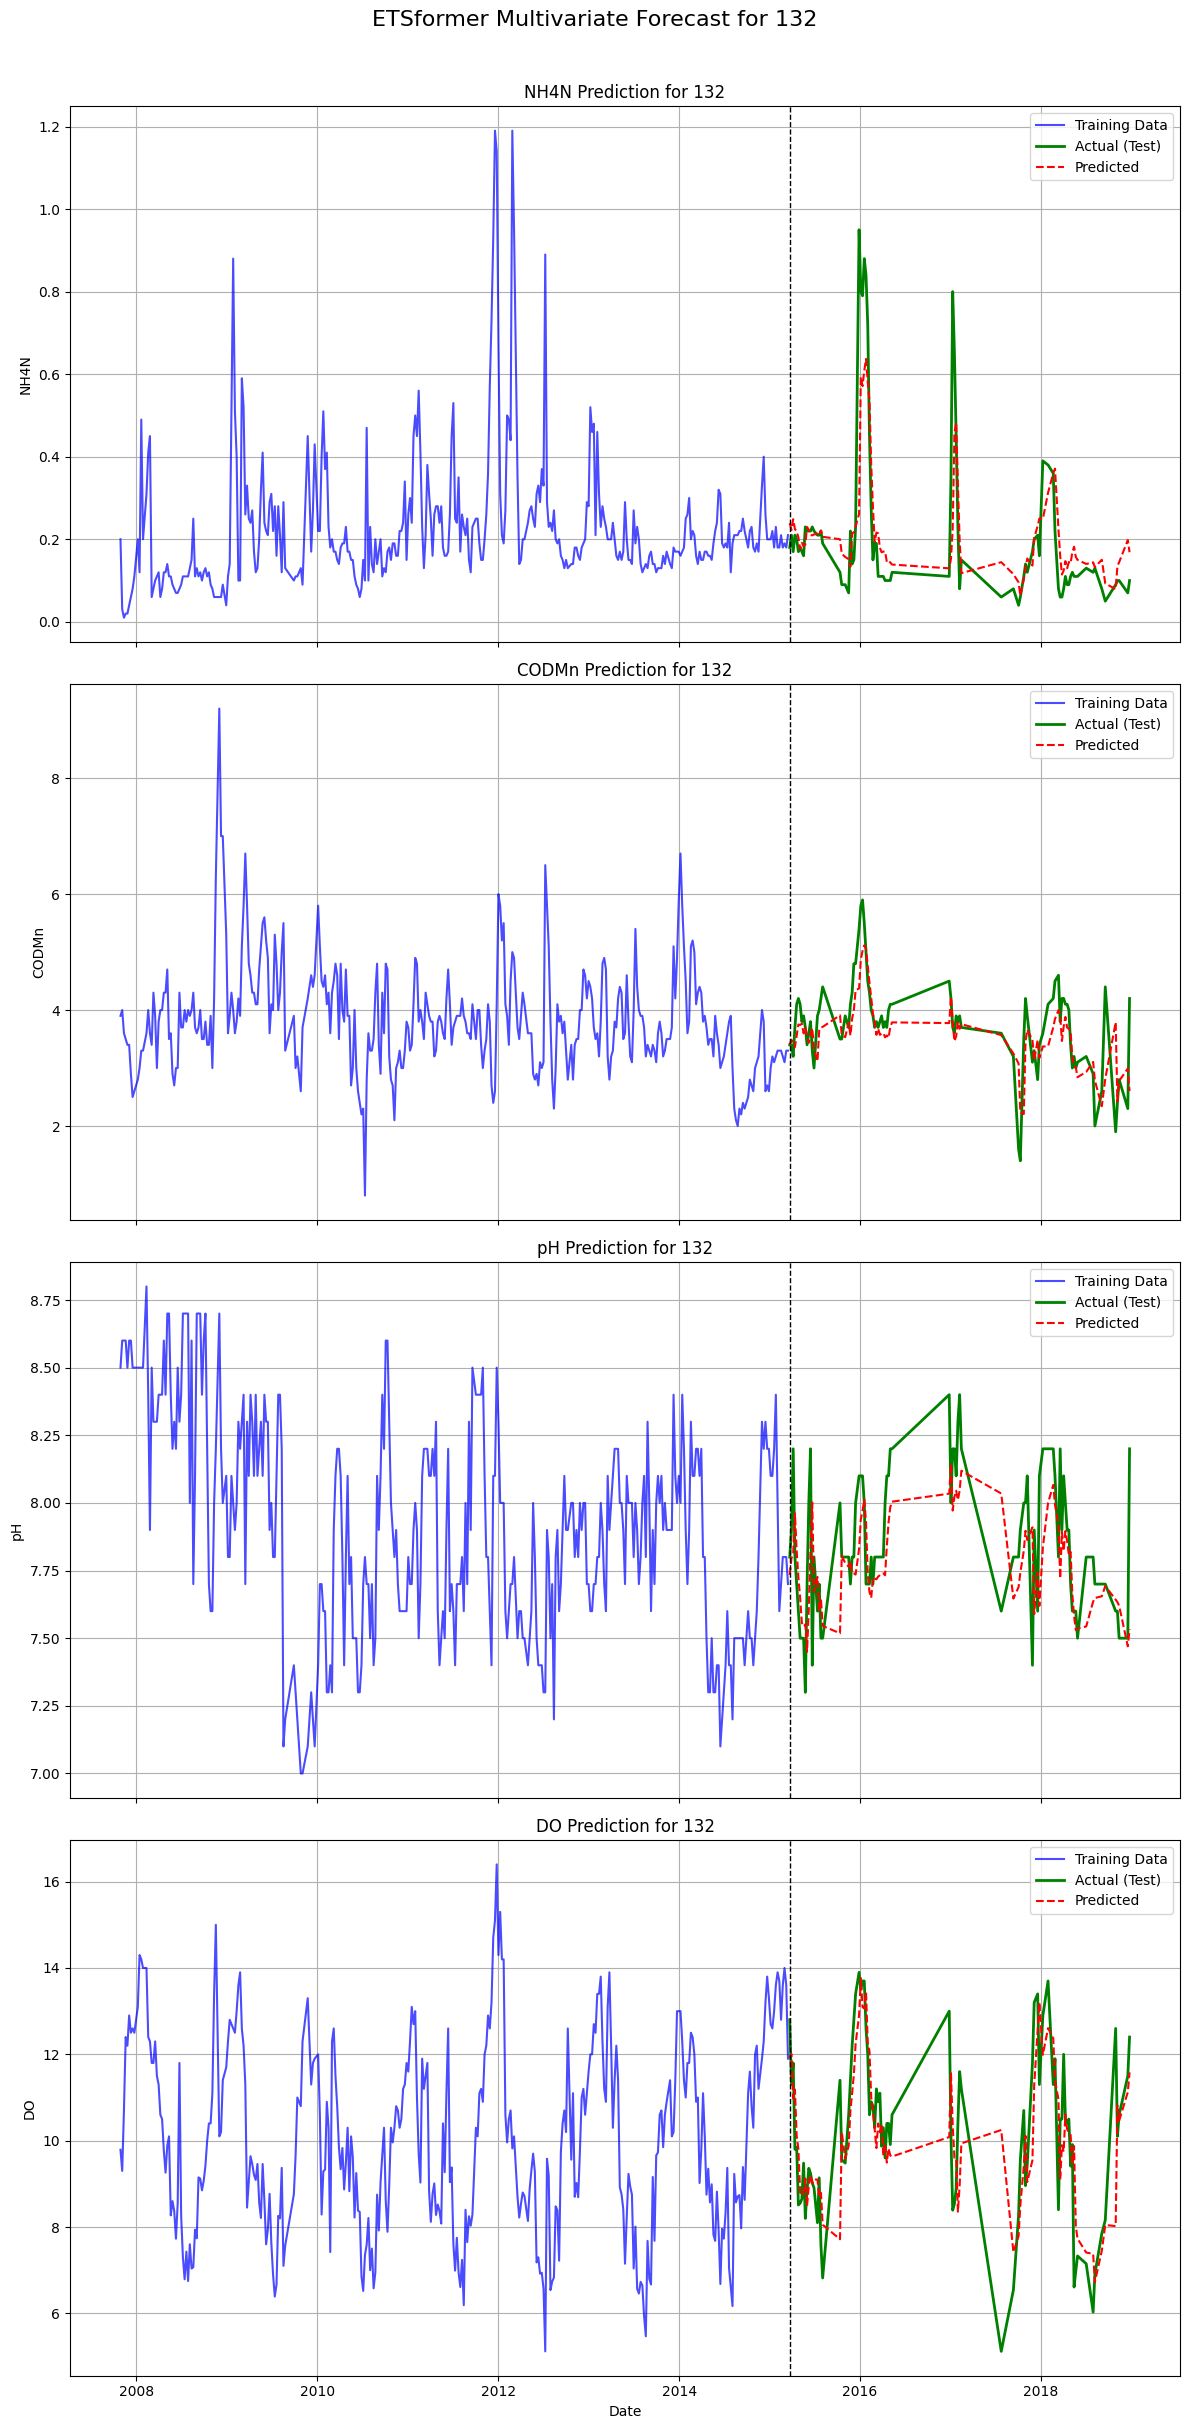

Using device: cpu
Input features (7): ['NH4N', 'CODMn', 'pH', 'DO', 'day', 'month', 'year']
Output features (4): ['NH4N', 'CODMn', 'pH', 'DO']
Starting training...


<ipython-input-8-30d754bbfbe9>:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.53940483 -1.19123573 -0.3947989   0.40163793  1.19807476 -1.41878911
 -0.62235228  0.17408455  0.97052138 -0.96368235 -0.16724552  0.62919131
  1.42562814 -0.50857559  0.28786124  1.08429807 -1.41878911 -0.62235228
  0.17408455  0.97052138  1.76695821 -0.96368235 -0.16724552  0.62919131
  1.42562814 -1.19123573 -0.3947989   0.40163793  1.19807476 -1.5325658
 -0.73612897  0.06030786  0.85674469  1.65318152 -0.96368235 -0.16724552
  0.62919131  1.42562814 -1.30501242 -0.50857559  0.28786124  1.08429807
 -1.64634249 -0.84990566 -0.05346883  0.742968    1.53940483 -1.07745904
 -0.28102221  0.51541462  1.31185145 -1.41878911 -0.62235228  0.17408455
 -1.64634249 -0.84990566 -0.05346883  1.53940483 -1.19123573 -0.3947989
  0.40163793  1.19807476 -1.5325658  -0.73612897  0.06030786  0.85674469
 -1.5325658  -0.73612897  0.06030786  0.856744

Epoch [1/120], Loss: 1.288143
Epoch [5/120], Loss: 0.856600
Epoch [10/120], Loss: 0.768087
Epoch [15/120], Loss: 0.778508
Epoch [20/120], Loss: 0.738742
Epoch [25/120], Loss: 0.747072
Epoch [30/120], Loss: 0.733153
Epoch [35/120], Loss: 0.709637
Epoch [40/120], Loss: 0.692955
Epoch [45/120], Loss: 0.698821
Epoch [50/120], Loss: 0.676508
Epoch [55/120], Loss: 0.690211
Epoch [60/120], Loss: 0.673580
Epoch [65/120], Loss: 0.691816
Epoch [70/120], Loss: 0.657997
Epoch [75/120], Loss: 0.661514
Epoch [80/120], Loss: 0.637715
Epoch [85/120], Loss: 0.632810
Epoch [90/120], Loss: 0.632687
Epoch [95/120], Loss: 0.642094
Epoch [100/120], Loss: 0.636823
Epoch [105/120], Loss: 0.636955
Epoch [110/120], Loss: 0.625978
Epoch [115/120], Loss: 0.635642
Epoch [120/120], Loss: 0.636097

Starting evaluation...

Evaluating 132...
132 Metrics:
  NH4N: RMSE=0.123, MAE=0.072, R²=0.627, MAPE=0.42%, HRSE=0.693
  CODMn: RMSE=0.568, MAE=0.426, R²=0.457, MAPE=0.12%, HRSE=1.667
  pH: RMSE=0.224, MAE=0.173, R²=0.190

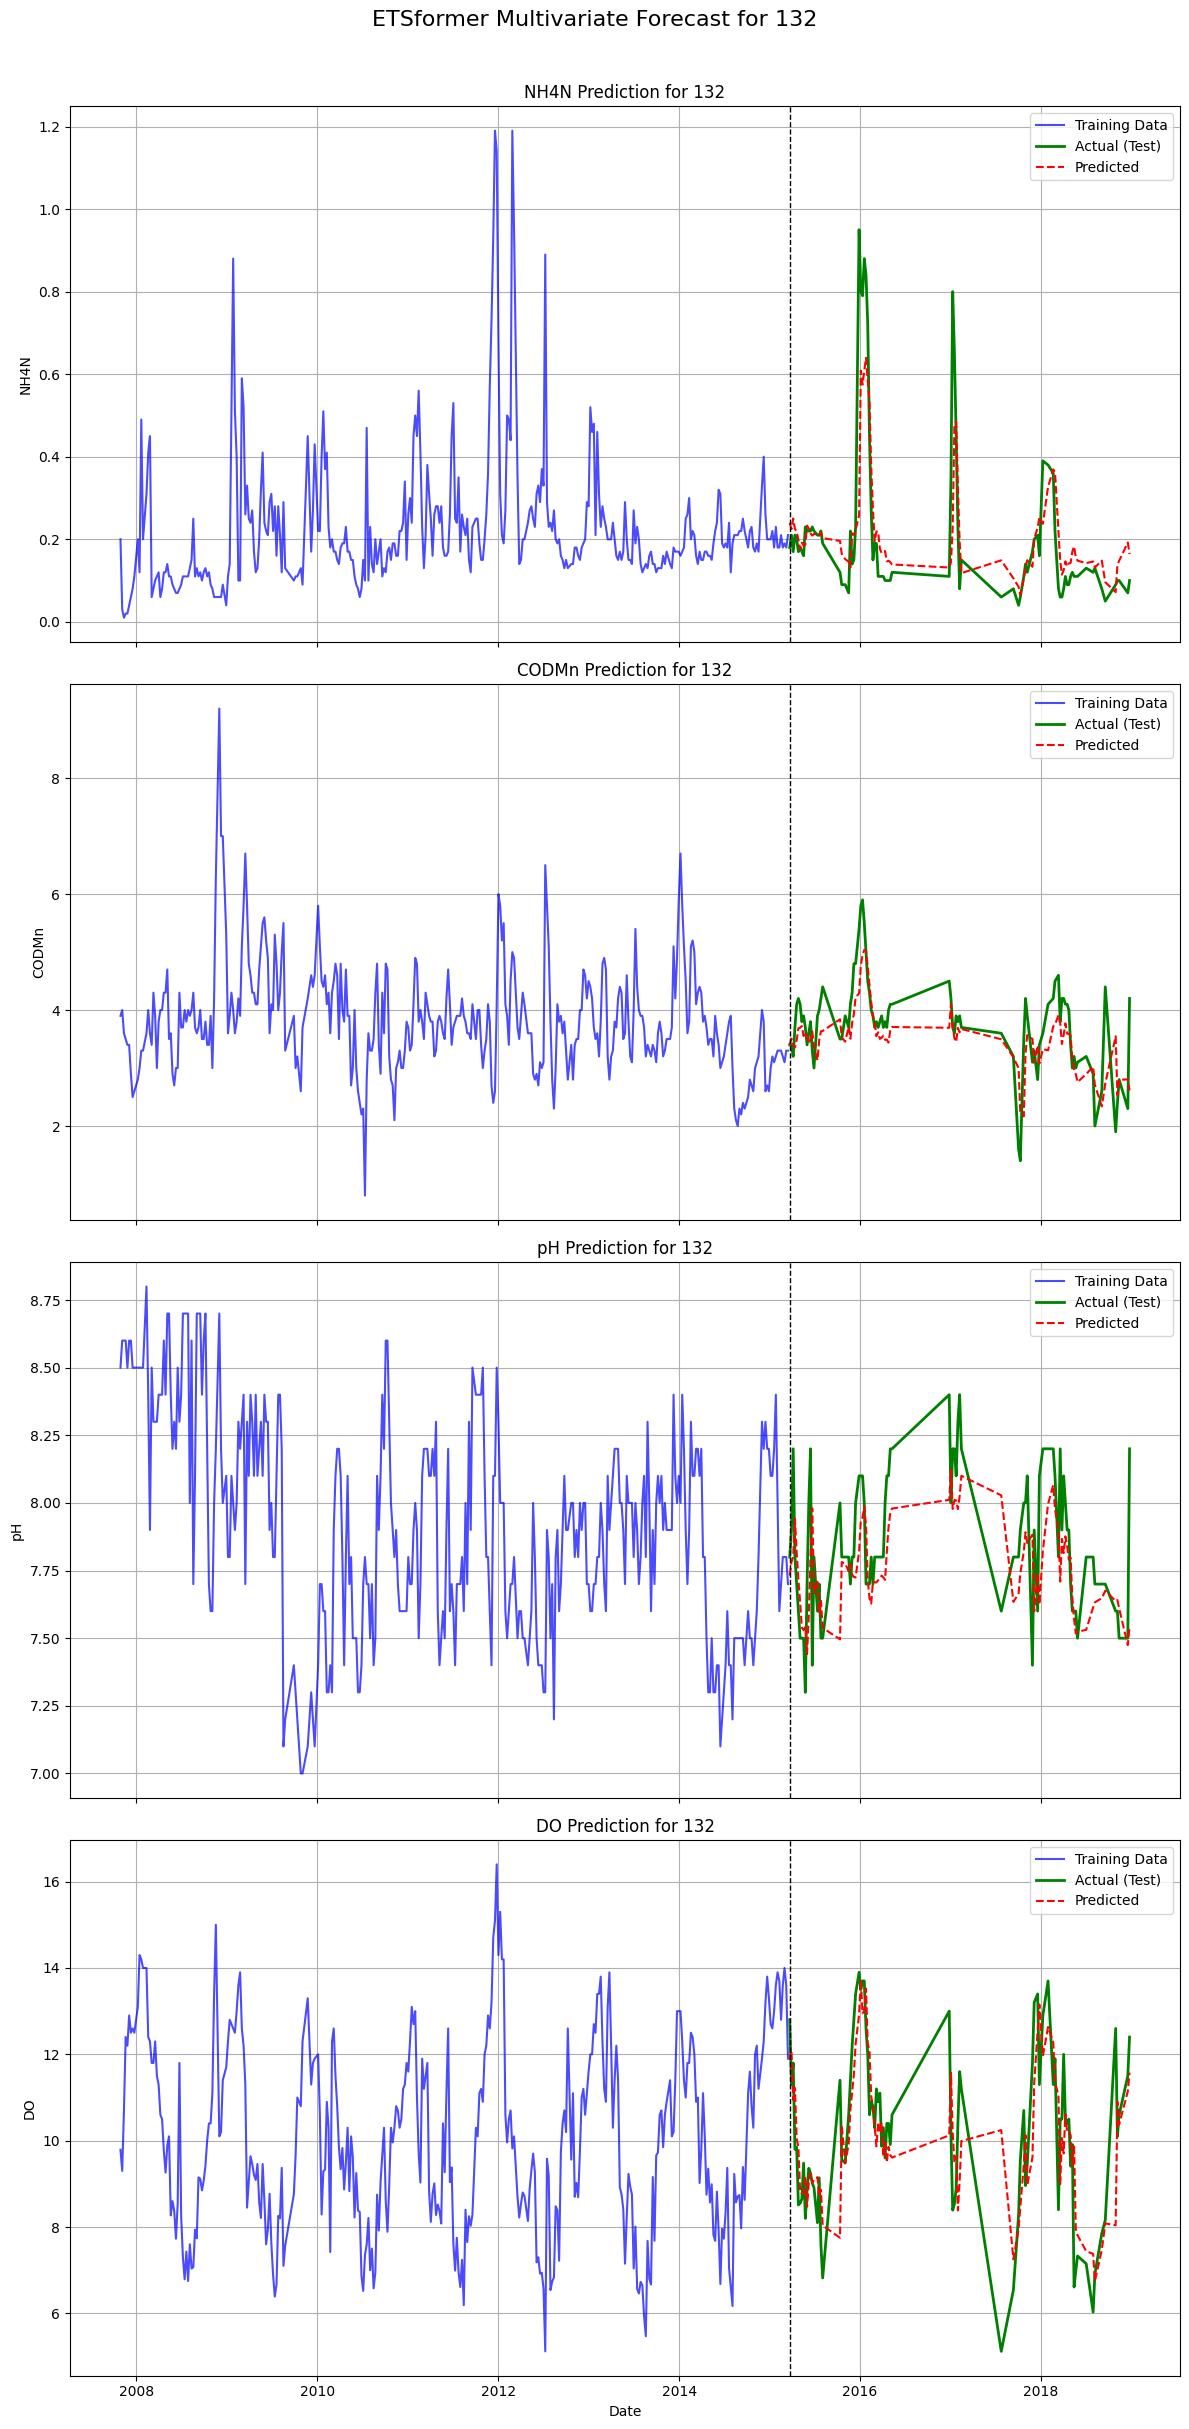

Using device: cpu
Input features (7): ['NH4N', 'CODMn', 'pH', 'DO', 'day', 'month', 'year']
Output features (4): ['NH4N', 'CODMn', 'pH', 'DO']
Starting training...


<ipython-input-8-30d754bbfbe9>:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.53940483 -1.19123573 -0.3947989   0.40163793  1.19807476 -1.41878911
 -0.62235228  0.17408455  0.97052138 -0.96368235 -0.16724552  0.62919131
  1.42562814 -0.50857559  0.28786124  1.08429807 -1.41878911 -0.62235228
  0.17408455  0.97052138  1.76695821 -0.96368235 -0.16724552  0.62919131
  1.42562814 -1.19123573 -0.3947989   0.40163793  1.19807476 -1.5325658
 -0.73612897  0.06030786  0.85674469  1.65318152 -0.96368235 -0.16724552
  0.62919131  1.42562814 -1.30501242 -0.50857559  0.28786124  1.08429807
 -1.64634249 -0.84990566 -0.05346883  0.742968    1.53940483 -1.07745904
 -0.28102221  0.51541462  1.31185145 -1.41878911 -0.62235228  0.17408455
 -1.64634249 -0.84990566 -0.05346883  1.53940483 -1.19123573 -0.3947989
  0.40163793  1.19807476 -1.5325658  -0.73612897  0.06030786  0.85674469
 -1.5325658  -0.73612897  0.06030786  0.856744

Epoch [1/120], Loss: 1.328367
Epoch [5/120], Loss: 0.835275
Epoch [10/120], Loss: 0.771187
Epoch [15/120], Loss: 0.756712
Epoch [20/120], Loss: 0.739483
Epoch [25/120], Loss: 0.748576
Epoch [30/120], Loss: 0.721525
Epoch [35/120], Loss: 0.711803
Epoch [40/120], Loss: 0.704359
Epoch [45/120], Loss: 0.713068
Epoch [50/120], Loss: 0.685605
Epoch [55/120], Loss: 0.681441
Epoch [60/120], Loss: 0.705012
Epoch [65/120], Loss: 0.670725
Epoch [70/120], Loss: 0.670734
Epoch [75/120], Loss: 0.676526
Epoch [80/120], Loss: 0.668573
Epoch [85/120], Loss: 0.685440
Epoch [90/120], Loss: 0.679602
Epoch [95/120], Loss: 0.668981
Epoch [100/120], Loss: 0.689947
Epoch [105/120], Loss: 0.668336
Epoch [110/120], Loss: 0.661850
Epoch [115/120], Loss: 0.655637
Epoch [120/120], Loss: 0.666605

Starting evaluation...

Evaluating 132...
132 Metrics:
  NH4N: RMSE=0.120, MAE=0.069, R²=0.646, MAPE=0.40%, HRSE=0.690
  CODMn: RMSE=0.567, MAE=0.428, R²=0.461, MAPE=0.12%, HRSE=1.665
  pH: RMSE=0.218, MAE=0.165, R²=0.232

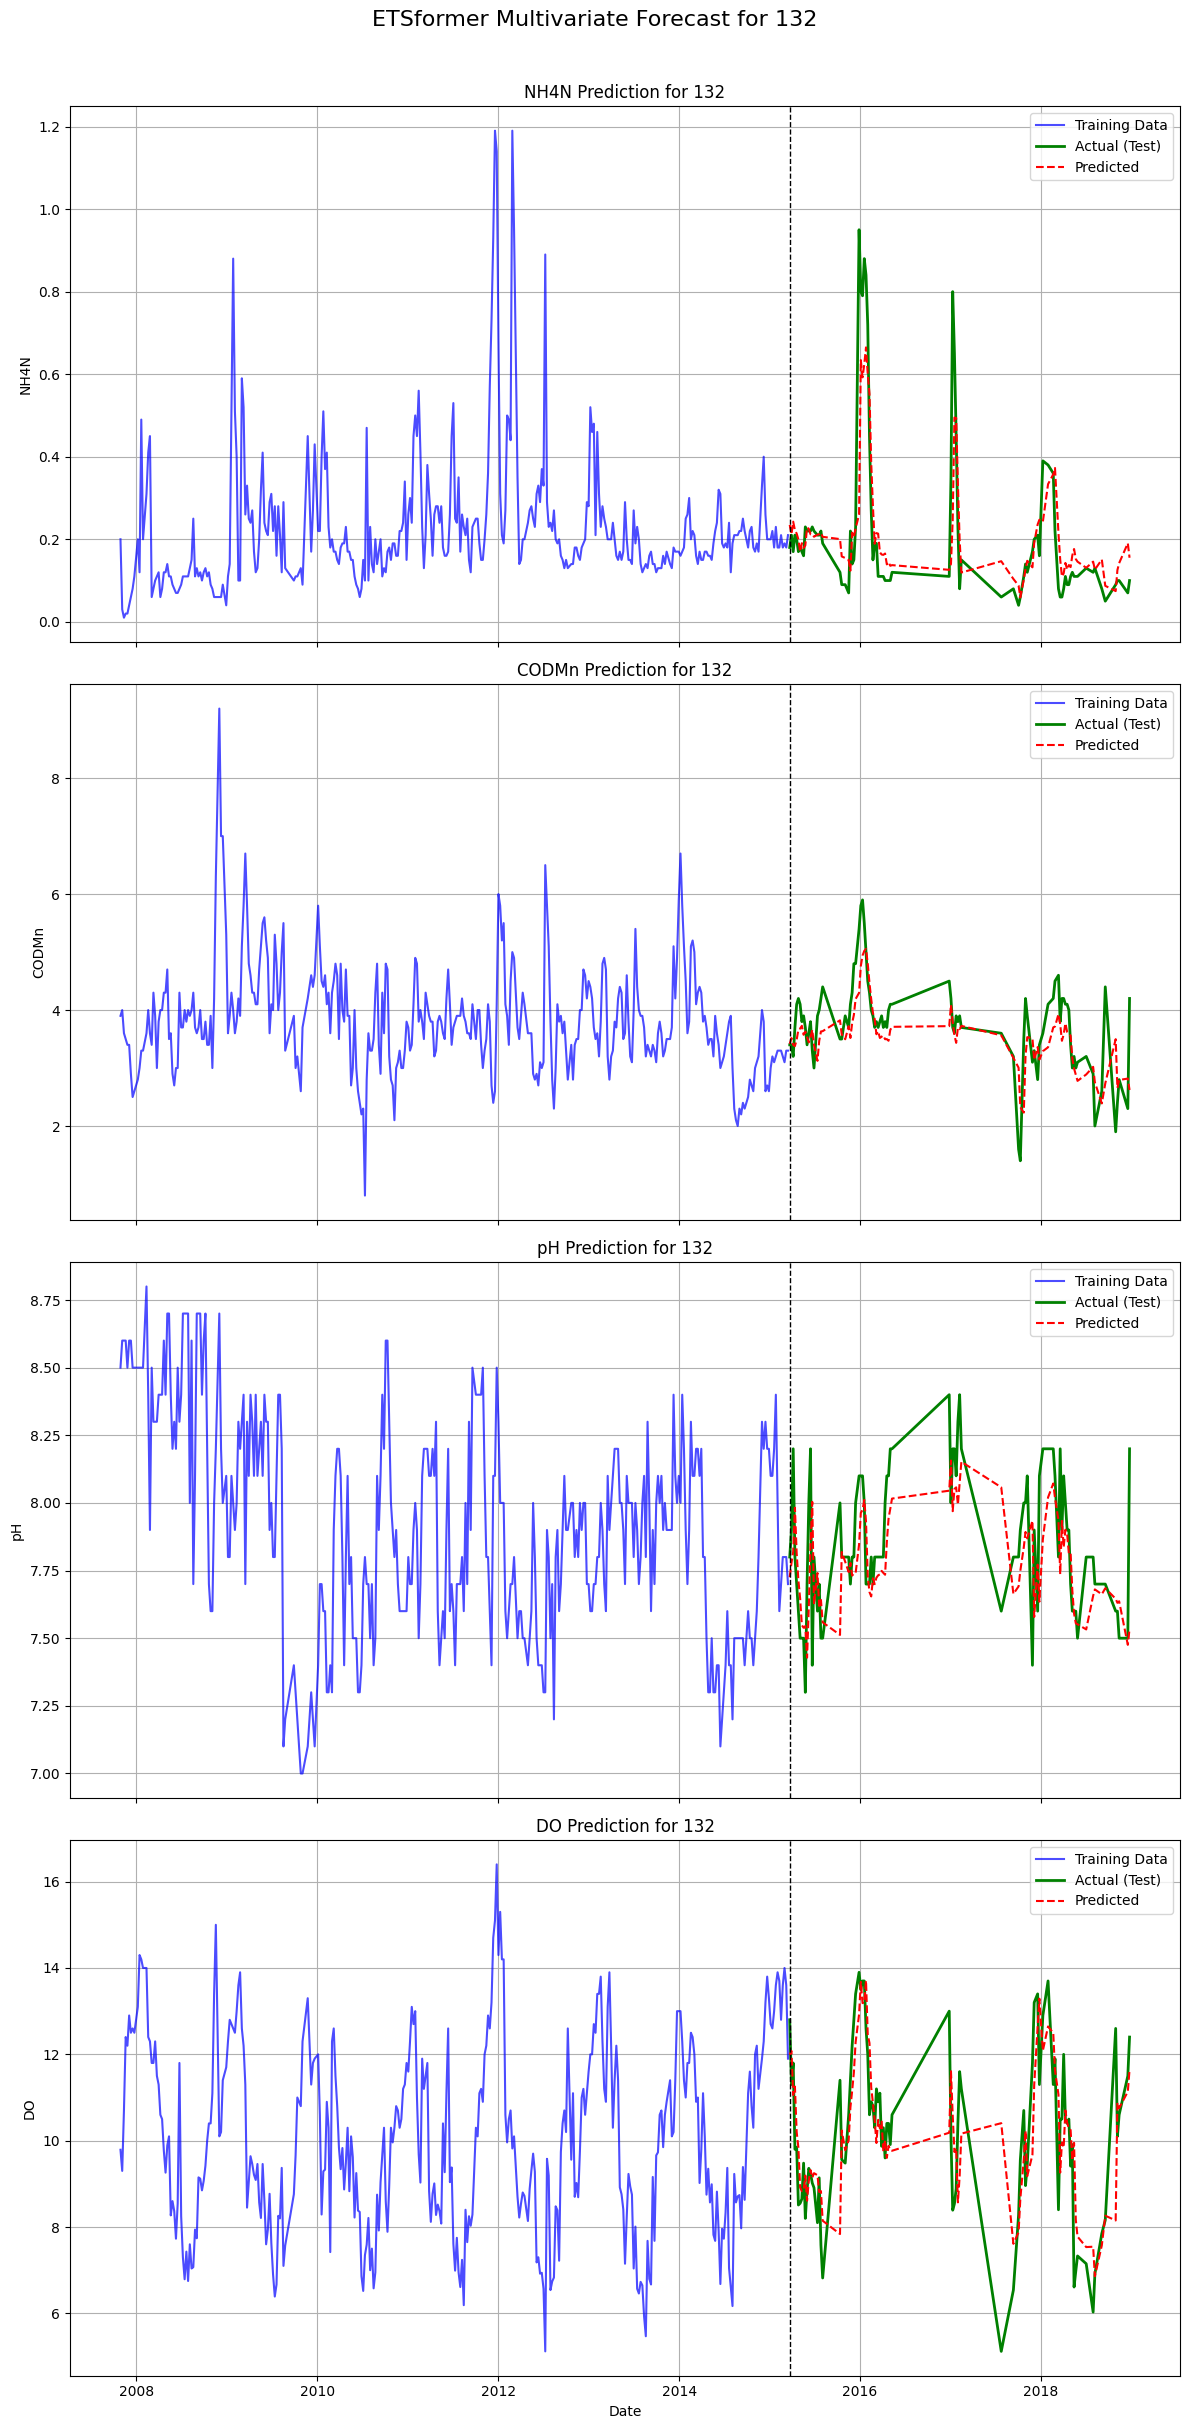


Run-to-run metric statistics for 132:
  Feature: NH4N
    RMSE : Mean=0.1222, Variance=0.000003, StdDev=0.0018
    MAE  : Mean=0.0709, Variance=0.000003, StdDev=0.0017
    R2   : Mean=0.6313, Variance=0.000115, StdDev=0.0107
    MAPE : Mean=0.4120, Variance=0.000138, StdDev=0.0118
    HRSE : Mean=0.6905, Variance=0.000002, StdDev=0.0015
  Feature: CODMn
    RMSE : Mean=0.5606, Variance=0.000093, StdDev=0.0096
    MAE  : Mean=0.4169, Variance=0.000199, StdDev=0.0141
    R2   : Mean=0.4718, Variance=0.000326, StdDev=0.0181
    MAPE : Mean=0.1220, Variance=0.000008, StdDev=0.0027
    HRSE : Mean=1.7409, Variance=0.011204, StdDev=0.1058
  Feature: pH
    RMSE : Mean=0.2203, Variance=0.000006, StdDev=0.0025
    MAE  : Mean=0.1682, Variance=0.000010, StdDev=0.0032
    R2   : Mean=0.2145, Variance=0.000313, StdDev=0.0177
    MAPE : Mean=0.0212, Variance=0.000000, StdDev=0.0004
    HRSE : Mean=0.6630, Variance=0.000015, StdDev=0.0038
  Feature: DO
    RMSE : Mean=1.3541, Variance=0.000005, St

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# --- Config and Loss ---
class Config:
    def __init__(self):
        self.seq_len = 24
        self.label_len = 12 # Not directly used by this ETSformer version
        self.pred_len = 12
        self.enc_in = 7  # NH4N, CODMn, pH, DO + day, month, year
        self.c_out = 4    # NH4N, CODMn, pH, DO (Features to forecast)
        self.d_model = 512
        self.n_heads = 16  # Internal heads within layers
        self.e_layers = 2  # Parallel Encoder Heads
        self.d_layers = 2  # Parallel Decoder Layers (must match e_layers)
        self.d_ff = 2048
        self.K = 3        # Top-k frequencies
        self.dropout = 0.1
        self.activation = 'gelu'
        self.output_attention = False
        self.std = 0.05   # Std dev for Transform
        self.layer_norm_eps=1e-5

configs = Config()

class HuberLogCoshLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        error = y_true - y_pred
        return torch.mean(torch.where(
            torch.abs(error) < self.delta,
            (error ** 2) / 2,  # MSE-like behavior for small errors
            torch.log(torch.cosh(error))  # Log-Cosh behavior for large errors
        ))


# --- Training Function ---
def train_etsformer_multivariate(data, features, seq_length=24, pred_length=12, epochs=100):
    results = {}
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    if 'Place' not in data.columns or 'date' not in data.columns:
        print("Columns 'Place' and 'date' must exist in the dataset.")
        return None

    # --- Prepare Config ---
    configs = Config()
    configs.seq_len = seq_length
    configs.pred_len = pred_length
    original_features = list(features) # Keep track of features to predict
    configs.c_out = len(original_features)

    # Add time features for input
    data = add_time_features(data.copy()) # Work on a copy
    time_features = ['day', 'month', 'year']
    input_features = original_features + time_features # All features for encoder input
    configs.enc_in = len(input_features)
    print(f"Input features ({configs.enc_in}): {input_features}")
    print(f"Output features ({configs.c_out}): {original_features}")


    # --- Data Splitting and Preprocessing ---
    train_data_list = []
    test_data_dict = {}
    scalers_X = {} # Scaler per location (can also use one global scaler)
    scalers_y = {} # Scaler for target variables

    for place, group in data.groupby('Place'):
        group = group.dropna(subset=input_features).sort_values(by='date')

        if group.shape[0] < seq_length + pred_length + 10:
            print(f"Skipping {place} due to insufficient data ({group.shape[0]} rows).")
            continue

        split_idx = int(len(group) * 0.8)
        train_df = group.iloc[:split_idx]
        test_df = group.iloc[split_idx:]

        # Fit scaler ONLY on training data for this place
        scaler_X = StandardScaler()
        train_df.loc[:, input_features] = scaler_X.fit_transform(train_df[input_features])
        scalers_X[place] = scaler_X # Store scaler for this place

        # Scale test data using the fitted scaler
        test_df.loc[:, input_features] = scaler_X.transform(test_df[input_features])

        train_data_list.append(train_df)
        test_data_dict[place] = test_df

    if not train_data_list:
        print("No locations with sufficient data for training.")
        return None

    # Combine all scaled training data
    train_data_combined = pd.concat(train_data_list)
    X_train_scaled = train_data_combined[input_features].values

    # Create sequences for training
    # Target y should only contain the original features (c_out)
    X_train_seq, y_train_seq_all_features = create_sequences(X_train_scaled, seq_length, pred_length)
    # Extract only the target feature columns for y
    feature_indices = [input_features.index(f) for f in original_features]
    y_train_seq = y_train_seq_all_features[:, :, feature_indices]


    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_seq).to(device)
    y_train_tensor = torch.FloatTensor(y_train_seq).to(device)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    # Adjust batch size based on memory
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # Smaller batch size

    # --- Model Initialization ---
    model = ETSformer(configs).float().to(device) # Ensure model is float

    # Loss and optimizer
    criterion = nn.MSELoss() # Using MSE for simplicity, can switch back to Huber
    # criterion = HuberLogCoshLoss(delta=1.0) # Or your custom loss
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)


    # --- Training Loop ---
    print("Starting training...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.float() # Ensure float type
            batch_y = batch_y.float()

            optimizer.zero_grad()

            # Forward pass: model expects x_enc shape (b, t, enc_in)
            # Outputs shape (b, pred_len, c_out)
            outputs = model(batch_X, None, None, None)

            # Loss expects (b, pred_len, c_out) vs (b, pred_len, c_out)
            loss = criterion(outputs, batch_y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss) # Step scheduler based on average epoch loss

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')

    # --- Inference and Evaluation ---
    print("\nStarting evaluation...")

    #Save the model
    model.eval()

    for place, test_data in test_data_dict.items():
        print(f"\nEvaluating {place}...")
        scaler_X = scalers_X[place] # Get the correct scaler for this place
        X_test_scaled = test_data[input_features].values
        test_dates = test_data['date'].values # Dates for plotting

        # Get the last sequence from this place's training data as initial input
        # Find the corresponding train_df
        train_df_place = next(df for df in train_data_list if df['Place'].iloc[0] == place)
        # Take the last seq_length points (already scaled)
        initial_input_scaled = train_df_place[input_features].values[-seq_length:]

        y_pred_list_scaled = [] # Store predictions for this place

        with torch.no_grad():
            current_input_seq = initial_input_scaled.copy() # Start with training data tail

            # Iterate through the test set to make predictions step-by-step
            for i in range(len(X_test_scaled)):
                 # Prepare input tensor (b=1, t=seq_len, f=enc_in)
                 seq_tensor = torch.FloatTensor(current_input_seq).unsqueeze(0).to(device)

                 # Predict `pred_length` steps ahead
                 prediction_scaled = model(seq_tensor, None, None, None) # Shape (1, pred_len, c_out)

                 # Take only the *first* step prediction from the `pred_length` output
                 first_step_pred_scaled = prediction_scaled[0, 0, :].cpu().numpy() # Shape (c_out,)

                 # Store this first step prediction
                 y_pred_list_scaled.append(first_step_pred_scaled)

                 # Get the actual next time step's features (including time features)
                 # This is used to roll the input window for the *next* prediction
                 actual_next_full_features_scaled = X_test_scaled[i, :] # Shape (enc_in,)

                 # Update the input sequence: drop oldest, append actual next step's features
                 current_input_seq = np.vstack((current_input_seq[1:], actual_next_full_features_scaled))


        # Now y_pred_list_scaled contains the 1-step ahead predictions for the entire test period
        y_pred_scaled = np.array(y_pred_list_scaled) # Shape (n_test_steps, c_out)

        # Inverse transform predictions to original scale
        # Create a dummy array with shape (n_test_steps, enc_in) to use the scaler
        dummy_pred_full = np.zeros((len(y_pred_scaled), configs.enc_in))
        # Place the predicted c_out values into the correct columns
        dummy_pred_full[:, feature_indices] = y_pred_scaled
        y_pred = scaler_X.inverse_transform(dummy_pred_full)[:, feature_indices] # Extract only target features

        # Get actual test values (original scale)
        y_test_full = scaler_X.inverse_transform(X_test_scaled) # Inverse transform all features
        y_test = y_test_full[:, feature_indices] # Extract only target features

        # Store results
        results[place] = {
            "model_state_dict": model.state_dict(), # Store state dict for later use
            "test_dates": test_dates[:len(y_pred)], # Align dates with predictions made
            "predictions": y_pred,
            "actual": y_test,
            "scaler": scaler_X, # Store scaler
            "input_features": input_features,
            "original_features": original_features
        }

        # --- Calculate and Print Metrics ---
        print(f"{place} Metrics:")
        metrics_summary = {}
        for i, feature in enumerate(original_features):
            mse = mean_squared_error(y_test[:, i], y_pred[:, i])
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
            r2 = r2_score(y_test[:, i], y_pred[:, i])
            mape = mean_absolute_percentage_error(y_test[:, i], y_pred[:, i])

            se_list = np.sqrt((y_test[:, i]-y_pred[:, i])**2)
            max_se = np.max(se_list)

            metrics = {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "mape": mape,"HRSE":max_se}
            results[place][f'{feature}_metrics'] = metrics
            metrics_summary[feature] = metrics
            print(f"  {feature}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}, MAPE={mape:.2f}%, HRSE={max_se:.3f}")


        # --- Plotting ---
        n_plots = len(original_features)
        fig, axes = plt.subplots(n_plots, 1, figsize=(12, 6 * n_plots), sharex=True)
        if n_plots == 1: axes = [axes] # Make iterable if only one plot

        train_plot_df = scaler_X.inverse_transform(train_df_place[input_features].values)


        for i, feature in enumerate(original_features):
            ax = axes[i]
            feature_idx_in_train = input_features.index(feature)

            # Plot training data (original scale)
            ax.plot(train_df_place['date'].values, train_plot_df[:, feature_idx_in_train],
                     'b-', label='Training Data', alpha=0.7)

            # Plot actual test data
            ax.plot(results[place]['test_dates'], y_test[:, i], 'g-', label='Actual (Test)', linewidth=2)
            # Plot predicted test data
            ax.plot(results[place]['test_dates'], y_pred[:, i], 'r--', label='Predicted', linewidth=1.5)

            # Add vertical line for split
            split_date = results[place]['test_dates'][0]
            ax.axvline(x=split_date, color='k', linestyle='--', linewidth=1)
            # ax.text(split_date, ax.get_ylim()[1]*0.9, ' Train/Test Split', ha='left', va='center')

            ax.set_title(f'{feature} Prediction for {place}')
            ax.set_ylabel(feature)
            ax.legend()
            ax.grid(True)

        axes[-1].set_xlabel('Date') # Add x-label only to the last plot
        plt.suptitle(f'ETSformer Multivariate Forecast for {place}', fontsize=16, y=1.01)
        plt.tight_layout()
        plt.show()

    return results


def create_sequences(data, seq_length, pred_length):
    """Creates sequences for multi-step prediction."""
    X, y = [], []
    # Loop needs to stop early enough to get a full prediction sequence y
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length : i + seq_length + pred_length])
    if not X: # Handle cases where data is too short
        return np.array([]).reshape(0, seq_length, data.shape[1]), \
               np.array([]).reshape(0, pred_length, data.shape[1])
    return np.array(X), np.array(y)

# --- Load Data (Replace with your actual data loading) ---

# --- Define features and Run ---
features = ['NH4N', 'CODMn', 'pH', 'DO'] # Features to predict

# Run the training and evaluation
# Use shorter sequence/prediction lengths and epochs for faster testing
# results = train_etsformer_multivariate(pivot_df, features, seq_length=4, pred_length=4, epochs=120) # Reduced epochs

#Calculate run-to-run variance:
results = []
for i in range (3):
  results.append(train_etsformer_multivariate(pivot_df, features, seq_length=4, pred_length=4, epochs=120))
# Supported metrics to analyze
metrics_to_check = ['rmse', 'mae', 'r2', 'mape', 'HRSE']

# Dictionary to hold results: {place -> {feature -> {metric -> list}}}
from collections import defaultdict
metric_runs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Collect metrics from all runs
for run in results:
    for place, place_results in run.items():
        for feature in features:
            for metric in metrics_to_check:
                value = place_results[f"{feature}_metrics"][metric]
                metric_runs[place][feature][metric].append(value)

# Compute statistics
for place, feature_dict in metric_runs.items():
    print(f"\nRun-to-run metric statistics for {place}:")
    for feature, metric_dict in feature_dict.items():
        print(f"  Feature: {feature}")
        for metric, values in metric_dict.items():
            values_array = np.array(values)
            mean_val = np.mean(values_array)
            var_val = np.var(values_array)
            std_val = np.std(values_array)
            print(f"    {metric.upper():<5}: Mean={mean_val:.4f}, Variance={var_val:.6f}, StdDev={std_val:.4f}")

In [ ]:
PATH = "/content/ETSFormerPlus.zip"
model = torch.load(PATH, weights_only=False)
model.eval()

ETSformer(
  (enc_embedding): ETSEmbedding(
    (conv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ParallelEncoder(
    (heads): ModuleList(
      (0-3): 4 x EncoderLayer(
        (growth_layer): GrowthLayer(
          (in_proj): Linear(in_features=512, out_features=512, bias=True)
          (es): ExponentialSmoothing(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (seasonal_layer): FourierLayer()
        (level_layer): LevelLayer(
          (es): ExponentialSmoothing(
            (dropout): Dropout(p=0.1, inplace=False)
            (aux_dropout): Dropout(p=0.1, inplace=False)
          )
          (growth_pred): Linear(in_features=512, out_features=4, bias=True)
          (season_pred): Linear(in_features=512, out_features=4, bias=True)
        )
        (ff): Feedforward(
          (li

Extra experiement with talking heads

In [ ]:
# Add near other imports
from torch import nn

# --- Talking Heads Communication Layer ---
class HeadCommunicationLayer(nn.Module):
    """
    Applies Talking-Heads style communication across parallel heads.
    Input is expected to be stacked along dim=1 (head dimension).
    Operates on the head dimension via linear projections.
    """
    def __init__(self, num_heads, dropout=0.1, bias=True):
        super().__init__()
        if num_heads <= 1:
            # No communication needed for a single head
            self.identity = True
            return
        self.identity = False
        self.num_heads = num_heads
        # Linear layers operate across the head dimension
        self.proj_pre = nn.Linear(num_heads, num_heads, bias=bias)
        self.proj_post = nn.Linear(num_heads, num_heads, bias=bias)
        self.dropout = nn.Dropout(dropout)
        # Note: LayerNorm is typically applied on feature dimensions.
        # Applying it robustly here after mixing heads is tricky.
        # We'll omit LayerNorm within this specific communication step
        # and rely on LayerNorms within the EncoderLayer and potentially after aggregation.

    def forward(self, x):
        # x shape: (batch, num_heads, ...) - e.g., (b, h, t, d_model)
        if self.identity:
            return x

        b = x.shape[0]
        # Remaining dimensions (e.g., time, features)
        other_dims = x.shape[2:]
        # Permute to put head dimension last for linear layers: (b, ..., h)
        x_permuted = x.permute(0, *range(2, x.dim()), 1)

        # Apply projections across the head dimension
        x_comm = self.proj_pre(x_permuted)
        # No activation typically used in original Talking Heads paper's projections
        x_comm = self.proj_post(x_comm) # Shape: (b, ..., h)

        # Apply dropout
        x_comm = self.dropout(x_comm)

        # Permute back to original head dimension location: (b, h, ...)
        x_mixed = x_comm.permute(0, x.dim()-1, *range(1, x.dim()-1))

        # --- Optional: Add Residual Connection ---
        # x_mixed = x + x_mixed # Add residual *before* unbinding if desired
        # --- End Optional ---

        return x_mixed

# --- Parallel Encoder (Replaces original Encoder/MultiHeadEncoder) ---
class ParallelEncoder(nn.Module):
    """
    Encoder that processes inputs in parallel across multiple 'heads',
    where each head is an independent instance of EncoderLayer.
    Includes optional Talking Heads communication between head outputs.
    Assumes the number of heads (num_encoder_layers) matches the number of decoder layers.
    """
    def __init__(self, encoder_layers: List[EncoderLayer], use_talking_heads=True, th_dropout=0.1):
        super().__init__()
        if not encoder_layers:
            raise ValueError("ParallelEncoder requires at least one EncoderLayer.")
        self.heads = nn.ModuleList(encoder_layers)
        self.num_heads = len(encoder_layers)
        # Store output_attention flag from the first layer (assuming consistent)
        self.output_attention = encoder_layers[0].output_attention if self.num_heads > 0 else False
        self.use_talking_heads = use_talking_heads if self.num_heads > 1 else False # No TH for 1 head

        if self.use_talking_heads:
            # Need separate communication layers for level, growth, season due to potentially different dims
            # Although the communication layer itself only cares about the num_heads dimension.
            self.level_talk = HeadCommunicationLayer(self.num_heads, dropout=th_dropout)
            self.growth_talk = HeadCommunicationLayer(self.num_heads, dropout=th_dropout)
            self.season_talk = HeadCommunicationLayer(self.num_heads, dropout=th_dropout)
            print("ParallelEncoder: Using Talking Heads communication.")
        else:
            print("ParallelEncoder: Not using Talking Heads communication.")


    def forward(self, res: torch.Tensor, level: torch.Tensor, attn_mask: Optional[torch.Tensor] = None) -> Tuple[List[torch.Tensor], List[torch.Tensor], List[torch.Tensor], List[Optional[torch.Tensor]], List[Optional[torch.Tensor]]]:
        """
        Forward pass for the ParallelEncoder.

        Args:
            res: Residual tensor from embedding (batch, seq_len, d_model).
            level: Initial level tensor, usually raw input (batch, seq_len, c_out).
            attn_mask: Optional attention mask (not used by ETSformer layers).

        Returns:
            all_levels: List of final level tensors [(b, t, c_out)] from each head (potentially mixed).
            all_growths: List of growth tensors [(b, t+1, d_model)] from each head (potentially mixed).
            all_seasons: List of season tensors [(b, t+pred_len, d_model)] from each head (potentially mixed).
            all_season_attns: List of season attention tensors from each head.
            all_growth_attns: List of growth attention tensors from each head.
        """
        # --- Collect raw outputs from each head ---
        raw_levels = []
        raw_growths = []
        raw_seasons = []
        all_season_attns = [] # Attentions are usually not mixed in TH
        all_growth_attns = []

        # Process each head independently on the *same* initial inputs
        for head_layer in self.heads:
            # Each head takes the *original* res and level.
            # EncoderLayer returns: res_final, level_updated, growth, season, season_attn, growth_attn
            # We don't need res_final from the encoder heads here.
            _, level_head, growth_head, season_head, season_attn_head, growth_attn_head = head_layer(
                res, level, attn_mask=attn_mask
            )

            # Collect outputs from this head
            raw_levels.append(level_head)
            raw_growths.append(growth_head)
            raw_seasons.append(season_head)
            all_season_attns.append(season_attn_head) # Will be None if output_attention=False
            all_growth_attns.append(growth_attn_head) # Will be None if output_attention=False

        # --- Apply Talking Heads Communication (if enabled) ---
        if self.use_talking_heads:
            # Stack tensors along a new head dimension (dim=1)
            stacked_levels = torch.stack(raw_levels, dim=1)    # Shape: (b, num_heads, t, c_out)
            stacked_growths = torch.stack(raw_growths, dim=1)  # Shape: (b, num_heads, t+1, d_model)
            stacked_seasons = torch.stack(raw_seasons, dim=1)  # Shape: (b, num_heads, t+pred_len, d_model)

            # Apply communication layer
            mixed_levels = self.level_talk(stacked_levels)
            mixed_growths = self.growth_talk(stacked_growths)
            mixed_seasons = self.season_talk(stacked_seasons)

            # Unbind back into lists
            final_levels = list(torch.unbind(mixed_levels, dim=1))
            final_growths = list(torch.unbind(mixed_growths, dim=1))
            final_seasons = list(torch.unbind(mixed_seasons, dim=1))

        else:
            # If not using talking heads, the final outputs are just the raw outputs
            final_levels = raw_levels
            final_growths = raw_growths
            final_seasons = raw_seasons

        # Return lists of components, one item per head
        return final_levels, final_growths, final_seasons, all_season_attns, all_growth_attns


# --- Modified ETSformer ---
class ETSformer(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len # Not used in forward? Keep for consistency.
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention
        self.configs = configs # Store configs for potential use

        # Ensure e_layers (num parallel encoder heads) matches d_layers (num decoder layers)
        if configs.e_layers != configs.d_layers:
            raise ValueError(f"Number of encoder heads (e_layers={configs.e_layers}) "
                             f"must match number of decoder layers (d_layers={configs.d_layers}) "
                             f"for this implementation.")
        self.num_heads = configs.e_layers # Or configs.d_layers

        # Embedding
        self.enc_embedding = ETSEmbedding(configs.enc_in, configs.d_model, dropout=configs.dropout)

        # --- Talking Heads Configuration ---
        # Add these flags to your config object/namespace
        self.use_talking_heads = configs.use_talking_heads
        self.th_dropout = getattr(configs, 'th_dropout', configs.dropout) # Use main dropout if th_dropout not set

        # Parallel Encoder: Create num_heads independent EncoderLayer instances
        encoder_layers = [
            EncoderLayer(
                configs.d_model, configs.n_heads, configs.c_out, configs.seq_len, configs.pred_len, configs.K,
                dim_feedforward=configs.d_ff,
                dropout=configs.dropout,
                activation=configs.activation,
                layer_norm_eps=getattr(configs, 'layer_norm_eps', 1e-5), # Add default if needed
                output_attention=configs.output_attention,
            ) for _ in range(self.num_heads)
        ]
        # Pass the talking heads configuration to ParallelEncoder
        self.encoder = ParallelEncoder(
            encoder_layers,
            use_talking_heads=self.use_talking_heads,
            th_dropout=self.th_dropout
        )

        # Decoder: Create num_heads independent DecoderLayer instances
        self.decoder = Decoder(
            [
                DecoderLayer(
                    configs.d_model, configs.n_heads, configs.c_out, configs.pred_len,
                    dropout=configs.dropout,
                    output_attention=configs.output_attention,
                ) for _ in range(self.num_heads)
            ],
        )

        # Optional Data Transformation (like Noisy Linear)
        if hasattr(configs, 'std') and configs.std > 0:
             self.transform = Transform(sigma=configs.std)
        else:
             self.transform = None # Or a no-op transform

    # forward method remains the same as in the previous version
    def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None, # Keep signature consistent
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None,
                decomposed=False):
        # x_enc: (batch, seq_len, enc_in) - Input sequence
        # level (initial): Use x_enc directly if c_out == enc_in, otherwise need projection?
        # Let's assume c_out matches the feature dim we want to forecast, potentially a subset/projection of enc_in.
        # For simplicity, assume level input to encoder uses the raw x_enc features intended for output (c_out).
        # This requires c_out <= enc_in. If c_out != enc_in, a projection might be needed.
        # Let's assume x_enc already has shape (batch, seq_len, c_out) for the level input pathway.
        # OR modify LevelLayer to take enc_in and project internally? No, keep LevelLayer c_out focused.
        # --> We need initial level of shape (b, t, c_out). Let's use the target features from x_enc.
        # This assumes the features to be forecast (c_out) are present in x_enc.

        if x_enc.shape[-1] < self.configs.c_out:
             raise ValueError(f"c_out ({self.configs.c_out}) cannot be larger than enc_in ({x_enc.shape[-1]}) when using x_enc for initial level.")
        elif x_enc.shape[-1] > self.configs.c_out:
             # print(f"Warning: x_enc features ({x_enc.shape[-1]}) != c_out ({self.configs.c_out}). Using first c_out features as initial level.")
             level_input = x_enc[:, :, :self.configs.c_out]
        else:
             level_input = x_enc # Shape: (b, t, c_out)


        # Apply transform if training and configured
        if self.training and self.transform is not None:
            x_enc_transformed = self.transform.transform(x_enc)
        else:
            x_enc_transformed = x_enc

        # 1. Embedding: (b, t, enc_in) -> (b, t, d_model)
        res = self.enc_embedding(x_enc_transformed)

        # 2. Parallel Encoder (Now potentially includes Talking Heads)
        # Input: res (b, t, d_model), level_input (b, t, c_out)
        # Output: Lists (length num_heads) of levels, growths, seasons, attentions
        all_levels, all_growths, all_seasons, all_season_attns, all_growth_attns = self.encoder(
            res, level_input, attn_mask=enc_self_mask
        )

        # 3. Decoder
        # Input: Lists of potentially mixed growths, seasons
        # Output: final growth (b, pred, c_out), final season (b, pred, c_out), list of dampings
        growth_pred, season_pred, growth_dampings_list = self.decoder(all_growths, all_seasons)

        # 4. Final Prediction: Level + Growth + Season
        # We need the level component forecast. The encoder outputs updated levels (b, t, c_out) for each head.
        # How to get the final level value or forecast?
        # Option A: Average the final level value across heads: avg(levels[h][:, -1:, :])
        # Option B: Assume level persists: Use the average of the last *input* level value.
        # Option C: Use the Exponential Smoothing from LevelLayer to forecast level? (Not directly available)
        # Let's use Option A: Average the last level value from the encoder heads.
        final_levels_across_heads = [level_head[:, -1:, :] for level_head in all_levels] # List of (b, 1, c_out)
        final_level_avg = torch.stack(final_levels_across_heads).mean(dim=0) # Shape: (b, 1, c_out)

        # Combine components: Level component is constant over pred_len horizon
        preds = final_level_avg + growth_pred + season_pred # Shape: (b, pred_len, c_out)

        # --- Output Handling ---
        if decomposed:
             # Return the final components separately
            return final_level_avg.repeat(1, self.pred_len, 1), growth_pred, season_pred

        if self.output_attention:
            # Need to aggregate attention information from the lists returned by encoder/decoder.
            # Average attentions across heads.
            # Ensure tensors exist before stacking/averaging.

            valid_season_attns = [attn for attn in all_season_attns if attn is not None]
            valid_growth_attns = [attn for attn in all_growth_attns if attn is not None]
            valid_growth_dampings = [damp for damp in growth_dampings_list if damp is not None]

            # Placeholder for aggregated attentions - need precise shapes from layers
            avg_season_attn = None
            avg_growth_attn = None # Maybe combine growth_attn and damping factors?

            if valid_season_attns:
                 # Assuming season_attn from FourierLayer is (b, k, d) or similar
                 # How to best aggregate? Stacking and averaging might work if shapes are consistent.
                 try:
                      stacked_season_attns = torch.stack(valid_season_attns, dim=0) # Shape [num_heads, b, k, d] ?
                      avg_season_attn = reduce(stacked_season_attns, 'h ... -> ...', 'mean') # Average over heads
                      # Keep only pred_len relevant part? Season attn relates to input freqs.
                      # Let's return the averaged map as is.
                 except Exception as e:
                      print(f"Warning: Could not stack/average season attentions: {e}")


            # Combine growth attention (from ES weights) and damping factors?
            # growth_attn might be (b, t, h, 1). damping is (pred_len, h).
            # Difficult to combine meaningfully into a single (b, pred_len, seq_len) map.
            # Let's return the averaged growth ES weights for now.
            if valid_growth_attns:
                 try:
                      # Assuming growth_attn from GrowthLayer is (b, t, nhead, 1)
                      stacked_growth_attns = torch.stack(valid_growth_attns, dim=0) # Shape [num_heads, b, t, nhead, 1] ?
                      # Average over encoder heads (dim 0) and internal ES heads (dim 3?)
                      avg_growth_attn = reduce(stacked_growth_attns, 'h b t nh 1 -> b t', 'mean') # Average over all heads?
                      # Select pred_len part? Growth attn refers to input seq.
                      # Let's return the (b, t) map representing input importance.
                 except Exception as e:
                      print(f"Warning: Could not stack/average growth attentions: {e}")


            # Return preds and averaged attentions (or None if unavailable)
            return preds, avg_season_attn, avg_growth_attn

        # Default return: predictions only
        return preds


# --- Make sure all other classes (Transform, conv1d_fft, ExponentialSmoothing, ETSEmbedding, Feedforward, GrowthLayer, LevelLayer, FourierLayer, EncoderLayer, DampingLayer, DecoderLayer, Decoder) are defined as in the previous steps ---
# --- Also ensure necessary imports are present ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft as fft

import numpy as np
from einops import rearrange, reduce, repeat
import math, random
from typing import List, Tuple, Optional
from scipy.fftpack import next_fast_len

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# --- Config and Loss ---
class Config:
    def __init__(self):
        self.seq_len = 24
        self.label_len = 12 # Not directly used by this ETSformer version
        self.pred_len = 12
        self.enc_in = 7  # NH4N, CODMn, pH, DO + day, month, year
        self.c_out = 4    # NH4N, CODMn, pH, DO (Features to forecast)
        self.d_model = 512
        self.n_heads = 8  # Internal heads within layers
        self.e_layers = 8  # Parallel Encoder Heads
        self.d_layers = 8  # Parallel Decoder Layers (must match e_layers)
        self.d_ff = 2048
        self.K = 3        # Top-k frequencies
        self.dropout = 0.1
        self.activation = 'gelu'
        self.output_attention = False
        self.std = 0.2   # Std dev for Transform
        self.layer_norm_eps=1e-5
        self.use_talking_heads = True

configs = Config()

class HuberLogCoshLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        error = y_true - y_pred
        return torch.mean(torch.where(
            torch.abs(error) < self.delta,
            (error ** 2) / 2,  # MSE-like behavior for small errors
            torch.log(torch.cosh(error))  # Log-Cosh behavior for large errors
        ))


# --- Training Function ---
def train_etsformer_multivariate(data, features, seq_length=24, pred_length=12, epochs=100):
    results = {}
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    if 'Place' not in data.columns or 'date' not in data.columns:
        print("Columns 'Place' and 'date' must exist in the dataset.")
        return None

    # --- Prepare Config ---
    configs = Config()
    configs.seq_len = seq_length
    configs.pred_len = pred_length
    original_features = list(features) # Keep track of features to predict
    configs.c_out = len(original_features)

    # Add time features for input
    data = add_time_features(data.copy()) # Work on a copy
    time_features = ['day', 'month', 'year']
    input_features = original_features + time_features # All features for encoder input
    configs.enc_in = len(input_features)
    print(f"Input features ({configs.enc_in}): {input_features}")
    print(f"Output features ({configs.c_out}): {original_features}")


    # --- Data Splitting and Preprocessing ---
    train_data_list = []
    test_data_dict = {}
    scalers_X = {} # Scaler per location (can also use one global scaler)
    scalers_y = {} # Scaler for target variables

    for place, group in data.groupby('Place'):
        group = group.dropna(subset=input_features).sort_values(by='date')

        if group.shape[0] < seq_length + pred_length + 10:
            print(f"Skipping {place} due to insufficient data ({group.shape[0]} rows).")
            continue

        split_idx = int(len(group) * 0.8)
        train_df = group.iloc[:split_idx]
        test_df = group.iloc[split_idx:]

        # Fit scaler ONLY on training data for this place
        scaler_X = StandardScaler()
        train_df.loc[:, input_features] = scaler_X.fit_transform(train_df[input_features])
        scalers_X[place] = scaler_X # Store scaler for this place

        # Scale test data using the fitted scaler
        test_df.loc[:, input_features] = scaler_X.transform(test_df[input_features])

        train_data_list.append(train_df)
        test_data_dict[place] = test_df

    if not train_data_list:
        print("No locations with sufficient data for training.")
        return None

    # Combine all scaled training data
    train_data_combined = pd.concat(train_data_list)
    X_train_scaled = train_data_combined[input_features].values

    # Create sequences for training
    # Target y should only contain the original features (c_out)
    X_train_seq, y_train_seq_all_features = create_sequences(X_train_scaled, seq_length, pred_length)
    # Extract only the target feature columns for y
    feature_indices = [input_features.index(f) for f in original_features]
    y_train_seq = y_train_seq_all_features[:, :, feature_indices]


    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_seq).to(device)
    y_train_tensor = torch.FloatTensor(y_train_seq).to(device)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    # Adjust batch size based on memory
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # Smaller batch size

    # --- Model Initialization ---
    model = ETSformer(configs).float().to(device) # Ensure model is float

    # Loss and optimizer
    criterion = nn.MSELoss() # Using MSE for simplicity, can switch back to Huber
    # criterion = HuberLogCoshLoss(delta=1.0) # Or your custom loss
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)


    # --- Training Loop ---
    print("Starting training...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            # batch_X already on device from DataLoader if pin_memory=True
            # batch_y already on device
            batch_X = batch_X.float() # Ensure float type
            batch_y = batch_y.float()

            optimizer.zero_grad()

            # Forward pass: model expects x_enc shape (b, t, enc_in)
            # Outputs shape (b, pred_len, c_out)
            outputs = model(batch_X, None, None, None)

            # Loss expects (b, pred_len, c_out) vs (b, pred_len, c_out)
            loss = criterion(outputs, batch_y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss) # Step scheduler based on average epoch loss

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')

    # --- Inference and Evaluation ---
    print("\nStarting evaluation...")
    model.eval()

    for place, test_data in test_data_dict.items():
        print(f"\nEvaluating {place}...")
        scaler_X = scalers_X[place] # Get the correct scaler for this place
        X_test_scaled = test_data[input_features].values
        test_dates = test_data['date'].values # Dates for plotting

        # Get the last sequence from this place's training data as initial input
        # Find the corresponding train_df
        train_df_place = next(df for df in train_data_list if df['Place'].iloc[0] == place)
        # Take the last seq_length points (already scaled)
        initial_input_scaled = train_df_place[input_features].values[-seq_length:]

        y_pred_list_scaled = [] # Store predictions for this place

        with torch.no_grad():
            current_input_seq = initial_input_scaled.copy() # Start with training data tail

            # Iterate through the test set to make predictions step-by-step
            for i in range(len(X_test_scaled)):
                 # Prepare input tensor (b=1, t=seq_len, f=enc_in)
                 seq_tensor = torch.FloatTensor(current_input_seq).unsqueeze(0).to(device)

                 # Predict `pred_length` steps ahead
                 prediction_scaled = model(seq_tensor, None, None, None) # Shape (1, pred_len, c_out)

                 # Take only the *first* step prediction from the `pred_length` output
                 first_step_pred_scaled = prediction_scaled[0, 0, :].cpu().numpy() # Shape (c_out,)

                 # Store this first step prediction
                 y_pred_list_scaled.append(first_step_pred_scaled)

                 # Get the actual next time step's features (including time features)
                 # This is used to roll the input window for the *next* prediction
                 actual_next_full_features_scaled = X_test_scaled[i, :] # Shape (enc_in,)

                 # Update the input sequence: drop oldest, append actual next step's features
                 current_input_seq = np.vstack((current_input_seq[1:], actual_next_full_features_scaled))


        # Now y_pred_list_scaled contains the 1-step ahead predictions for the entire test period
        y_pred_scaled = np.array(y_pred_list_scaled) # Shape (n_test_steps, c_out)

        # Inverse transform predictions to original scale
        # Create a dummy array with shape (n_test_steps, enc_in) to use the scaler
        dummy_pred_full = np.zeros((len(y_pred_scaled), configs.enc_in))
        # Place the predicted c_out values into the correct columns
        dummy_pred_full[:, feature_indices] = y_pred_scaled
        y_pred = scaler_X.inverse_transform(dummy_pred_full)[:, feature_indices] # Extract only target features

        # Get actual test values (original scale)
        y_test_full = scaler_X.inverse_transform(X_test_scaled) # Inverse transform all features
        y_test = y_test_full[:, feature_indices] # Extract only target features

        # Store results
        results[place] = {
            "model_state_dict": model.state_dict(), # Store state dict for later use
            "test_dates": test_dates[:len(y_pred)], # Align dates with predictions made
            "predictions": y_pred,
            "actual": y_test,
            "scaler": scaler_X, # Store scaler
            "input_features": input_features,
            "original_features": original_features
        }

        # --- Calculate and Print Metrics ---
        print(f"{place} Metrics:")
        metrics_summary = {}
        for i, feature in enumerate(original_features):
            mse = mean_squared_error(y_test[:, i], y_pred[:, i])
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
            r2 = r2_score(y_test[:, i], y_pred[:, i])
            mape = mean_absolute_percentage_error(y_test[:, i], y_pred[:, i])

            se_list = np.sqrt((y_test[:, i]-y_pred[:, i])**2)
            max_se = np.max(se_list)

            metrics = {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "mape": mape,"HRSE":max_se}
            results[place][f'{feature}_metrics'] = metrics
            metrics_summary[feature] = metrics
            print(f"  {feature}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}, MAPE={mape:.2f}%, HRSE={max_se:.3f}")


        # --- Plotting ---
        n_plots = len(original_features)
        fig, axes = plt.subplots(n_plots, 1, figsize=(15, 5 * n_plots), sharex=True)
        if n_plots == 1: axes = [axes] # Make iterable if only one plot

        train_plot_df = scaler_X.inverse_transform(train_df_place[input_features].values)


        for i, feature in enumerate(original_features):
            ax = axes[i]
            feature_idx_in_train = input_features.index(feature)

            # Plot training data (original scale)
            ax.plot(train_df_place['date'].values, train_plot_df[:, feature_idx_in_train],
                     'b-', label='Training Data', alpha=0.7)

            # Plot actual test data
            ax.plot(results[place]['test_dates'], y_test[:, i], 'g-', label='Actual (Test)', linewidth=2)
            # Plot predicted test data
            ax.plot(results[place]['test_dates'], y_pred[:, i], 'r--', label='Predicted', linewidth=1.5)

            # Add vertical line for split
            split_date = results[place]['test_dates'][0]
            ax.axvline(x=split_date, color='k', linestyle='--', linewidth=1)
            # ax.text(split_date, ax.get_ylim()[1]*0.9, ' Train/Test Split', ha='left', va='center')

            ax.set_title(f'{feature} Prediction for {place}')
            ax.set_ylabel(feature)
            ax.legend()
            ax.grid(True)

        axes[-1].set_xlabel('Date') # Add x-label only to the last plot
        plt.suptitle(f'ETSformer Multivariate Forecast for {place}', fontsize=16, y=1.01)
        plt.tight_layout()
        plt.show()

    return results


def create_sequences(data, seq_length, pred_length):
    """Creates sequences for multi-step prediction."""
    X, y = [], []
    # Loop needs to stop early enough to get a full prediction sequence y
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length : i + seq_length + pred_length])
    if not X: # Handle cases where data is too short
        return np.array([]).reshape(0, seq_length, data.shape[1]), \
               np.array([]).reshape(0, pred_length, data.shape[1])
    return np.array(X), np.array(y)

# --- Load Data (Replace with your actual data loading) ---

# --- Define features and Run ---
features = ['NH4N', 'CODMn', 'pH', 'DO'] # Features to predict

# Run the training and evaluation
# Use shorter sequence/prediction lengths and epochs for faster testing
results = train_etsformer_multivariate(pivot_df, features, seq_length=24, pred_length=4, epochs=120) # Reduced epochs

Using device: cpu
Input features (7): ['NH4N', 'CODMn', 'pH', 'DO', 'day', 'month', 'year']
Output features (4): ['NH4N', 'CODMn', 'pH', 'DO']


<ipython-input-16-50938bb3f0e2>:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.53940483 -1.19123573 -0.3947989   0.40163793  1.19807476 -1.41878911
 -0.62235228  0.17408455  0.97052138 -0.96368235 -0.16724552  0.62919131
  1.42562814 -0.50857559  0.28786124  1.08429807 -1.41878911 -0.62235228
  0.17408455  0.97052138  1.76695821 -0.96368235 -0.16724552  0.62919131
  1.42562814 -1.19123573 -0.3947989   0.40163793  1.19807476 -1.5325658
 -0.73612897  0.06030786  0.85674469  1.65318152 -0.96368235 -0.16724552
  0.62919131  1.42562814 -1.30501242 -0.50857559  0.28786124  1.08429807
 -1.64634249 -0.84990566 -0.05346883  0.742968    1.53940483 -1.07745904
 -0.28102221  0.51541462  1.31185145 -1.41878911 -0.62235228  0.17408455
 -1.64634249 -0.84990566 -0.05346883  1.53940483 -1.19123573 -0.3947989
  0.40163793  1.19807476 -1.5325658  -0.73612897  0.06030786  0.85674469
 -1.5325658  -0.73612897  0.06030786  0.85674

Starting training...


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft as fft

import numpy as np
from einops import rearrange, reduce, repeat
import math, random
from typing import List, Tuple, Optional
from scipy.fftpack import next_fast_len
from einops import rearrange, reduce, repeat
import torch.fft as fft

from einops import rearrange, reduce, repeat
from scipy.fftpack import next_fast_len

class Transform:
    def __init__(self, sigma):
        self.sigma = sigma

    @torch.no_grad()
    def transform(self, x):
        return self.jitter(self.shift(self.scale(x)))

    def jitter(self, x):
        return x + (torch.randn(x.shape).to(x.device) * self.sigma)

    def scale(self, x):
        return x * (torch.randn(x.size(-1)).to(x.device) * self.sigma + 1)

    def shift(self, x):
        return x + (torch.randn(x.size(-1)).to(x.device) * self.sigma)


def conv1d_fft(f, g, dim=-1):
    N = f.size(dim)
    M = g.size(dim)

    fast_len = next_fast_len(N + M - 1)

    F_f = fft.rfft(f, fast_len, dim=dim)
    F_g = fft.rfft(g, fast_len, dim=dim)

    F_fg = F_f * F_g.conj()
    out = fft.irfft(F_fg, fast_len, dim=dim)
    out = out.roll((-1,), dims=(dim,))
    idx = torch.as_tensor(range(fast_len - N, fast_len)).to(out.device)
    out = out.index_select(dim, idx)

    return out


class ExponentialSmoothing(nn.Module):

    def __init__(self, dim, nhead, dropout=0.1, aux=False):
        super().__init__()
        self._smoothing_weight = nn.Parameter(torch.randn(nhead, 1))
        self.v0 = nn.Parameter(torch.randn(1, 1, nhead, dim))
        self.dropout = nn.Dropout(dropout)
        if aux:
            self.aux_dropout = nn.Dropout(dropout)

    def forward(self, values, aux_values=None):
        b, t, h, d = values.shape

        init_weight, weight = self.get_exponential_weight(t)
        output = conv1d_fft(self.dropout(values), weight, dim=1)
        output = init_weight * self.v0 + output

        if aux_values is not None:
            aux_weight = weight / (1 - self.weight) * self.weight
            aux_output = conv1d_fft(self.aux_dropout(aux_values), aux_weight)
            output = output + aux_output

        return output

    def get_exponential_weight(self, T):
        # Generate array [0, 1, ..., T-1]
        powers = torch.arange(T, dtype=torch.float, device=self.weight.device)

        # (1 - \alpha) * \alpha^t, for all t = T-1, T-2, ..., 0]
        weight = (1 - self.weight) * (self.weight ** torch.flip(powers, dims=(0,)))

        # \alpha^t for all t = 1, 2, ..., T
        init_weight = self.weight ** (powers + 1)

        return rearrange(init_weight, 'h t -> 1 t h 1'), \
               rearrange(weight, 'h t -> 1 t h 1')

    @property
    def weight(self):
        return torch.sigmoid(self._smoothing_weight)

class ETSEmbedding(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super().__init__()
        kernel_size = 3
        # Calculate padding to maintain sequence length: (kernel_size - 1) // 2
        padding = 1 # For kernel=3, padding=2
        self.conv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                              kernel_size=kernel_size, padding=padding, bias=False)
        self.dropout = nn.Dropout(p=dropout)
        nn.init.kaiming_normal_(self.conv.weight)

    def forward(self, x):
        # x shape: (batch, seq_len, c_in)
        x = x.permute(0, 2, 1) # Shape: (batch, c_in, seq_len)
        # Conv1d output with correct padding should have same length as input
        x = self.conv(x) # Shape: (batch, d_model, seq_len)
        # --- REMOVE THE SLICING ---
        # x = x[..., :-2] # <--- REMOVE THIS LINE
        # --- END REMOVAL ---
        x = x.transpose(1, 2) # Shape: (batch, seq_len, d_model)
        return self.dropout(x)


class Feedforward(nn.Module):
    def __init__(self, d_model, dim_feedforward, dropout=0.1, activation='sigmoid'):
        # Implementation of Feedforward model
        super().__init__()
        self.linear1 = nn.Linear(d_model, dim_feedforward, bias=False)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, bias=False)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = getattr(F, activation)

    def forward(self, x):
        x = self.linear2(self.dropout1(self.activation(self.linear1(x))))
        return self.dropout2(x)

class ExponentialSmoothing(nn.Module):
    def __init__(self, dim, nhead, dropout=0.1, aux=False, identifier=""): # Added identifier
        super().__init__()
        self.nhead = max(1, nhead)
        self.dim = dim # Dimension PER HEAD
        self.identifier = identifier # Store identifier

        # --- CORRECTED INITIALIZATION ---
        self.v0 = nn.Parameter(torch.randn(1, 1, self.nhead, self.dim))
        # --- END CORRECTION ---

        # --- DEBUG PRINT ---
        # print(f"ES Init ({self.identifier}): nhead={self.nhead}, dim={self.dim}, Requested v0 last dim={self.dim}, Actual v0 shape={self.v0.shape}")
        # --- END DEBUG ---

        self._smoothing_weight = nn.Parameter(torch.randn(self.nhead, 1))
        self.dropout = nn.Dropout(dropout)
        self.aux = aux
        if aux:
            self.aux_dropout = nn.Dropout(dropout)

    def forward(self, values, aux_values=None):
        # values shape: (b, t, h, d) where d should == self.dim
        b, t, h, d = values.shape

        # --- DEBUG PRINT ---
        # print(f"ES Forward ({self.identifier}): Instance dim={self.dim}, Input values last dim (d)={d}, v0 shape={self.v0.shape}")
        if d != self.dim:
             print(f"----> ERROR: Instance dim ({self.dim}) != Input values last dim ({d}) <----")
             # This check should ideally prevent the crash later if it fails
             # raise ValueError(f"Input dimension d ({d}) does not match self.dim ({self.dim})") # Or just print
        # --- END DEBUG ---


        if d != self.dim:
             # If the check above fails, maybe return zeros to avoid crash, although the root cause needs fixing
             # print(f"----> WARNING: Dimension mismatch detected in ES ({self.identifier}). Returning zeros. <----")
             return torch.zeros_like(values)


        init_weight, weight = self.get_exponential_weight(t) # Shape: [1, t, h, 1]

        values_dropped = self.dropout(values)
        output = conv1d_fft(values_dropped, weight, dim=1) # Shape: (b, t, h, d)

        # --- DEBUG PRINT ---
        term_a = init_weight * self.v0
        # print(f"ES Forward ({self.identifier}) - Before Add: init_weight*v0 shape={term_a.shape}, output shape={output.shape}")
        # --- END DEBUG ---


        # v0 shape (1, 1, h, d), init_weight shape (1, t, h, 1)
        # init_weight * v0 broadcasts to (1, t, h, d)
        # output shape (b, t, h, d)
        output = term_a + output # Error occurs here if shapes mismatch

        if self.aux and aux_values is not None:
            # ... (auxiliary calculation part) ...
            if aux_values.shape != values.shape:
                 # This check might be important if LevelLayer's ES is somehow getting wrong aux shapes
                 print(f"----> WARNING: Aux values shape mismatch in ES ({self.identifier}) <----")
                 # raise ValueError(f"aux_values shape {aux_values.shape} must match values shape {values.shape}")
            else:
                 alpha = torch.sigmoid(self._smoothing_weight).view(1, 1, h, 1)
                 safe_denom = torch.clamp(1 - alpha, min=1e-6)
                 aux_weight = weight / safe_denom * alpha
                 aux_values_dropped = self.aux_dropout(aux_values)
                 aux_output = conv1d_fft(aux_values_dropped, aux_weight, dim=1)
                 output = output + aux_output # Add aux component
        return output

    # get_exponential_weight and weight property remain the same
    def get_exponential_weight(self, T):
        powers = torch.arange(T, dtype=torch.float, device=self.weight.device)
        init_weight = self.weight ** (powers + 1)
        weight = (1 - self.weight) * (self.weight ** torch.flip(powers, dims=(0,)))
        return rearrange(init_weight, 'h t -> 1 t h 1'), \
               rearrange(weight, 'h t -> 1 t h 1')

    @property
    def weight(self):
        return torch.sigmoid(self._smoothing_weight)

class GrowthLayer(nn.Module):
    def __init__(self, d_model, nhead, d_head=None, dropout=0.1, output_attention=False):
        super().__init__()
        # ... (other initializations) ...
        self.nhead = nhead
        self.d_head = d_head or (d_model // max(1, nhead))
        self.d_model = d_model
        # ... (value checks) ...
        self.z0 = nn.Parameter(torch.randn(self.nhead, self.d_head))
        self.in_proj = nn.Linear(self.d_model, self.d_head * self.nhead)
        self.output_attention = output_attention
        # Pass d_head as dim and an identifier
        self.es = ExponentialSmoothing(self.d_head, self.nhead, dropout=dropout, identifier="GrowthLayer_ES") # Added identifier
        self.out_proj = nn.Linear(self.d_head * self.nhead, self.d_model)
    # ... (forward method) ...
    def forward(self, inputs):
        b, t, _ = inputs.shape
        values = self.in_proj(inputs).view(b, t, self.nhead, self.d_head)
        z0_repeated = repeat(self.z0, 'h d -> b 1 h d', b=b)
        values_with_z0 = torch.cat([z0_repeated, values], dim=1)
        diffs = values_with_z0[:, 1:] - values_with_z0[:, :-1] # Shape: (b, t, h, d_head)
        smoothed_diffs = self.es(diffs) # Call ES forward
        v0_repeated = repeat(self.es.v0, '1 1 h d -> b 1 h d', b=b) # v0 now has d_head in last dim
        out_with_v0 = torch.cat([v0_repeated, smoothed_diffs], dim=1) # Shape: (b, t+1, h, d_head)
        out_reshaped = rearrange(out_with_v0, 'b time h d -> b time (h d)')
        out_final = self.out_proj(out_reshaped) # Shape: (b, t+1, d_model)

        if self.output_attention:
            _, attn_weights = self.es.get_exponential_weight(t) # Shape: [1, t, h, 1]
            attn = repeat(attn_weights, '1 t h 1 -> b t h 1', b=b)
            return out_final, attn
        return out_final, None


class LevelLayer(nn.Module):
    def __init__(self, d_model, c_out, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.c_out = c_out

        self.es = ExponentialSmoothing(dim=1, nhead=self.c_out, dropout=dropout, aux=True, identifier="LevelLayer_ES") # Added identifier
        self.growth_pred = nn.Linear(self.d_model, self.c_out)
        self.season_pred = nn.Linear(self.d_model, self.c_out)
    # ... (forward method) ...
    def forward(self, level, growth, season):
        b, t_level, _ = level.shape # level is (b, t, c_out)
        common_t = t_level

        growth_sliced = growth[:, 1:common_t+1, :]
        season_sliced = season[:, :common_t, :]

        growth_proj = self.growth_pred(growth_sliced)
        season_proj = self.season_pred(season_sliced)

        level_reshaped = rearrange(level, 'b t h -> b t h 1')
        season_reshaped = rearrange(season_proj, 'b t h -> b t h 1')
        growth_reshaped = rearrange(growth_proj, 'b t h -> b t h 1')

        es_input = level_reshaped - season_reshaped
        level_output_reshaped = self.es(es_input, aux_values=growth_reshaped) # Call ES forward
        level_output = rearrange(level_output_reshaped, 'b t h 1 -> b t h')
        return level_output

class FourierLayer(nn.Module):

    def __init__(self, d_model, pred_len, k=None, low_freq=1, output_attention=False):
        super().__init__()
        self.d_model = d_model
        self.pred_len = pred_len
        self.k = k
        self.low_freq = low_freq
        self.output_attention = output_attention

    def forward(self, x):
        """x: (b, t, d)"""

        if self.output_attention:
            return self.dft_forward(x)

        b, t, d = x.shape
        x_freq = fft.rfft(x, dim=1)

        if t % 2 == 0:
            x_freq = x_freq[:, self.low_freq:-1]
            f = fft.rfftfreq(t)[self.low_freq:-1]
        else:
            x_freq = x_freq[:, self.low_freq:]
            f = fft.rfftfreq(t)[self.low_freq:]

        x_freq, index_tuple = self.topk_freq(x_freq)
        f = repeat(f, 'f -> b f d', b=x_freq.size(0), d=x_freq.size(2))
        f = rearrange(f[index_tuple], 'b f d -> b f () d').to(x_freq.device)

        return self.extrapolate(x_freq, f, t), None

    def extrapolate(self, x_freq, f, t):
        x_freq = torch.cat([x_freq, x_freq.conj()], dim=1)
        f = torch.cat([f, -f], dim=1)
        t_val = rearrange(torch.arange(t + self.pred_len, dtype=torch.float),
                      't -> () () t ()').to(x_freq.device)

        amp = rearrange(x_freq.abs() / t, 'b f d -> b f () d')
        phase = rearrange(x_freq.angle(), 'b f d -> b f () d')

        x_time = amp * torch.cos(2 * math.pi * f * t_val + phase)

        return reduce(x_time, 'b f t d -> b t d', 'sum')

    def topk_freq(self, x_freq):
        values, indices = torch.topk(x_freq.abs(), self.k, dim=1, largest=True, sorted=True)
        mesh_a, mesh_b = torch.meshgrid(torch.arange(x_freq.size(0)), torch.arange(x_freq.size(2)))
        index_tuple = (mesh_a.unsqueeze(1), indices, mesh_b.unsqueeze(1))
        x_freq = x_freq[index_tuple]

        return x_freq, index_tuple

    def dft_forward(self, x):
        T = x.size(1)

        dft_mat = fft.fft(torch.eye(T))
        i, j = torch.meshgrid(torch.arange(self.pred_len + T), torch.arange(T))
        omega = np.exp(2 * math.pi * 1j / T)
        idft_mat = (np.power(omega, i * j) / T).cfloat()

        x_freq = torch.einsum('ft,btd->bfd', [dft_mat, x.cfloat()])

        if T % 2 == 0:
            x_freq = x_freq[:, self.low_freq:T // 2]
        else:
            x_freq = x_freq[:, self.low_freq:T // 2 + 1]

        _, indices = torch.topk(x_freq.abs(), self.k, dim=1, largest=True, sorted=True)
        indices = indices + self.low_freq
        indices = torch.cat([indices, -indices], dim=1)

        dft_mat = repeat(dft_mat, 'f t -> b f t d', b=x.shape[0], d=x.shape[-1])
        idft_mat = repeat(idft_mat, 't f -> b t f d', b=x.shape[0], d=x.shape[-1])

        mesh_a, mesh_b = torch.meshgrid(torch.arange(x.size(0)), torch.arange(x.size(2)))

        dft_mask = torch.zeros_like(dft_mat)
        dft_mask[mesh_a, indices, :, mesh_b] = 1
        dft_mat = dft_mat * dft_mask

        idft_mask = torch.zeros_like(idft_mat)
        idft_mask[mesh_a, :, indices, mesh_b] = 1
        idft_mat = idft_mat * idft_mask

        attn = torch.einsum('bofd,bftd->botd', [idft_mat, dft_mat]).real
        return torch.einsum('botd,btd->bod', [attn, x]), rearrange(attn, 'b o t d -> b d o t')


# --- Encoder Layer (Processes one "head" input) ---
class EncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, c_out, seq_len, pred_len, k, dim_feedforward=None, dropout=0.1,
                 activation='relu', layer_norm_eps=1e-5, output_attention=False):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead # nhead for internal GrowthLayer/DampingLayer head splitting
        self.c_out = c_out
        self.seq_len = seq_len
        self.pred_len = pred_len
        dim_feedforward = dim_feedforward or 4 * d_model
        self.output_attention = output_attention

        self.growth_layer = GrowthLayer(d_model, nhead, dropout=dropout, output_attention=output_attention)
        # Pass pred_len and k to FourierLayer
        self.seasonal_layer = FourierLayer(d_model, pred_len, k=k, output_attention=output_attention)
        # Pass d_model and c_out to LevelLayer
        self.level_layer = LevelLayer(d_model, c_out, dropout=dropout)

        # Feedforward and Normalization
        self.ff = Feedforward(d_model, dim_feedforward, dropout=dropout, activation=activation)
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, res, level, attn_mask=None):
        # res: (b, t, d_model) - Residual from embedding/previous layer
        # level: (b, t, c_out) - Level component (raw input initially)

        # Ensure inputs are not modified if shared across parallel heads
        res_copy = res # .clone() might be needed if layers modify in-place
        level_copy = level # .clone()

        # 1. Seasonal Block
        # Input: res_copy (b, t, d_model)
        # Output: season (b, t+pred_len, d_model), season_attn
        season, season_attn = self._season_block(res_copy)
        # Residual connection: Subtract season from original seq length part of res
        # Need to slice season: [:, :self.seq_len, :]
        res_after_season = res_copy - season[:, :self.seq_len, :]

        # 2. Growth Block
        # Input: res_after_season (b, t, d_model)
        # Output: growth (b, t+1, d_model), growth_attn
        growth, growth_attn = self._growth_block(res_after_season)
        # Residual connection: Subtract growth from res_after_season
        # Need to slice growth: [:, 1:, :] to match time dimension t and exclude initial state v0
        res_after_growth = res_after_season - growth[:, 1:self.seq_len+1, :] # Match (b,t,d)
        # Normalize before FF
        res_norm1 = self.norm1(res_after_growth) # Apply norm on (res - season - growth)


        # 3. Feedforward Block
        res_ff = self.ff(res_norm1)
        # Add & Norm
        res_final = self.norm2(res_norm1 + res_ff)

        # 4. Level Block (Update Level)
        # Input: level_copy (b, t, c_out)
        # Input: growth (b, t+1, d_model) -> slice -> (b, t, d_model) needed? Check LevelLayer internal slicing
        # Input: season (b, t+pred_len, d_model) -> slice -> (b, t, d_model) needed? Check LevelLayer internal slicing
        level_updated = self.level_layer(level_copy, growth, season) # Let LevelLayer handle slicing

        # Return:
        # res_final: Updated residual for next layer/encoder output (if sequential) - Shape (b, t, d_model)
        # level_updated: Updated level component - Shape (b, t, c_out)
        # growth: Full growth component (incl. initial state) - Shape (b, t+1, d_model)
        # season: Full seasonal component (incl. prediction) - Shape (b, t+pred_len, d_model)
        # season_attn, growth_attn: Attention weights if output_attention=True
        return res_final, level_updated, growth, season, season_attn, growth_attn

    def _growth_block(self, x):
        # Growth layer expects (b, t, d_model), returns (b, t+1, d_model)
        x_out, growth_attn = self.growth_layer(x)
        # Apply dropout to the output (excluding initial state?)
        # Let's apply dropout to the whole output sequence including v0 for simplicity
        return self.dropout1(x_out), growth_attn

    def _season_block(self, x):
        # Seasonal layer expects (b, t, d_model), returns (b, t+pred_len, d_model)
        x_out, season_attn = self.seasonal_layer(x)
        return self.dropout2(x_out), season_attn


# --- Parallel Encoder (Replaces original Encoder/MultiHeadEncoder) ---
class ParallelEncoder(nn.Module):
    """
    Encoder that processes inputs in parallel across multiple 'heads',
    where each head is an independent instance of EncoderLayer.
    Assumes the number of heads (num_encoder_layers) matches the number of decoder layers.
    """
    def __init__(self, encoder_layers: List[EncoderLayer]):
        super().__init__()
        if not encoder_layers:
            raise ValueError("ParallelEncoder requires at least one EncoderLayer.")
        self.heads = nn.ModuleList(encoder_layers)
        self.num_heads = len(encoder_layers)
        # Store output_attention flag from the first layer (assuming consistent)
        self.output_attention = encoder_layers[0].output_attention

    def forward(self, res: torch.Tensor, level: torch.Tensor, attn_mask: Optional[torch.Tensor] = None) -> Tuple[List[torch.Tensor], List[torch.Tensor], List[torch.Tensor], List[Optional[torch.Tensor]], List[Optional[torch.Tensor]]]:
        """
        Forward pass for the ParallelEncoder.

        Args:
            res: Residual tensor from embedding (batch, seq_len, d_model).
            level: Initial level tensor, usually raw input (batch, seq_len, c_out).
            attn_mask: Optional attention mask (not used by ETSformer layers).

        Returns:
            all_levels: List of final level tensors [(b, t, c_out)] from each head.
            all_growths: List of growth tensors [(b, t+1, d_model)] from each head.
            all_seasons: List of season tensors [(b, t+pred_len, d_model)] from each head.
            all_season_attns: List of season attention tensors from each head.
            all_growth_attns: List of growth attention tensors from each head.
        """
        all_levels = []
        all_growths = []
        all_seasons = []
        all_season_attns = []
        all_growth_attns = []

        # Process each head independently on the *same* initial inputs
        for head_layer in self.heads:
            # Each head takes the *original* res and level.
            # EncoderLayer returns: res_final, level_updated, growth, season, season_attn, growth_attn
            # We don't need res_final from the encoder heads here.
            _, level_head, growth_head, season_head, season_attn_head, growth_attn_head = head_layer(
                res, level, attn_mask=attn_mask
            )

            # Collect outputs from this head
            all_levels.append(level_head)
            all_growths.append(growth_head)
            all_seasons.append(season_head)
            all_season_attns.append(season_attn_head) # Will be None if output_attention=False
            all_growth_attns.append(growth_attn_head) # Will be None if output_attention=False

        # Return lists of components, one item per head
        return all_levels, all_growths, all_seasons, all_season_attns, all_growth_attns


# --- Damping Layer (Used by DecoderLayer) ---
class DampingLayer(nn.Module):
    def __init__(self, pred_len, nhead, dropout=0.1):
        super().__init__()
        self.pred_len = pred_len
        self.nhead = max(1, nhead) # Ensure nhead > 0
        self._damping_factor = nn.Parameter(torch.randn(1, self.nhead)) # Shape (1, H)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Input x: (b, 1, d_model) - Typically the last growth value
        b, _, d_model = x.shape
        # d_head calculation must match GrowthLayer's internal split
        d_head = d_model // self.nhead
        if d_head * self.nhead != d_model:
             raise ValueError(f"d_model ({d_model}) not divisible by nhead ({self.nhead}) in DampingLayer")

        # Repeat the last value for the prediction horizon
        x_repeated = repeat(x, 'b 1 d -> b t d', t=self.pred_len) # Shape: (b, pred_len, d_model)

        # Calculate damping factors
        powers = torch.arange(1, self.pred_len + 1, device=self._damping_factor.device) # 1, 2, ..., pred_len
        powers = powers.view(self.pred_len, 1) # Shape: (pred_len, 1)

        # Damping factor: sigmoid(param) -> (0, 1) range. Shape: (1, nhead)
        # Damp factor ^ powers -> Shape: (pred_len, nhead)
        damping_factors = self.damping_factor ** powers
        # Cumulative sum along time dim: Represents the forecasted growth trend contribution
        damping_factors_cumulative = damping_factors.cumsum(dim=0) # Shape: (pred_len, nhead)

        # Reshape input to align with heads: (b, pred_len, nhead, d_head)
        x_reshaped = x_repeated.view(b, self.pred_len, self.nhead, d_head)

        # Apply dropout
        x_dropped = self.dropout(x_reshaped)

        # Apply damping: Needs broadcasting (b, t, h, d) * (t, h) ->unsqueeze-> (b, t, h, d) * (t, h, 1)
        damped_x = x_dropped * damping_factors_cumulative.unsqueeze(0).unsqueeze(-1) # Shapes: (b,t,h,d) * (1,t,h,1)

        # Reshape back to (b, pred_len, d_model)
        output = damped_x.view(b, self.pred_len, d_model)

        # Return damped output and the cumulative factors for potential attention visualization
        # damping_factors_cumulative shape: (pred_len, nhead)
        return output, damping_factors_cumulative

    @property
    def damping_factor(self):
        return torch.sigmoid(self._damping_factor)


# --- Decoder Layer (Processes one head's growth/season) ---
class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, c_out, pred_len, dropout=0.1, output_attention=False):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead # nhead for DampingLayer's internal splitting
        self.c_out = c_out
        self.pred_len = pred_len
        self.output_attention = output_attention

        # DampingLayer applies damped trend to the last growth component
        self.growth_damping = DampingLayer(pred_len, nhead, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, growth, season):
        # growth: (b, t+1, d_model) - From the corresponding encoder head's GrowthLayer
        # season: (b, t+pred_len, d_model) - From the corresponding encoder head's FourierLayer

        # 1. Growth Horizon Forecast
        # Take the last value of the growth component (represents final trend magnitude)
        last_growth_val = growth[:, -1:, :] # Shape: (b, 1, d_model)
        # Apply damping to extrapolate trend over prediction horizon
        growth_horizon, growth_damping_factors = self.growth_damping(last_growth_val) # Shapes: (b, pred_len, d_model), (pred_len, nhead)
        growth_horizon = self.dropout1(growth_horizon) # Apply dropout

        # 2. Seasonal Horizon Forecast
        # Take the predicted part of the seasonal component
        seasonal_horizon = season[:, -self.pred_len:, :] # Shape: (b, pred_len, d_model)

        # Return horizon components and damping factors
        # Note: growth_damping_factors are returned directly (not attn weights derived from them yet)
        if self.output_attention:
            return growth_horizon, seasonal_horizon, growth_damping_factors
        return growth_horizon, seasonal_horizon, None


# --- Decoder (Aggregates results from Decoder Layers) ---
class Decoder(nn.Module):
    def __init__(self, decoder_layers: List[DecoderLayer]):
        super().__init__()
        if not decoder_layers:
             raise ValueError("Decoder requires at least one DecoderLayer.")
        # Assuming all layers have consistent attributes
        self.d_model = decoder_layers[0].d_model
        self.c_out = decoder_layers[0].c_out
        self.pred_len = decoder_layers[0].pred_len
        self.nhead = decoder_layers[0].nhead # nhead used internally in layers

        self.layers = nn.ModuleList(decoder_layers)
        # Final projection from d_model to output channels (c_out)
        self.pred = nn.Linear(self.d_model, self.c_out)
        self.num_layers = len(decoder_layers) # Should match num_encoder_heads

    def forward(self, growths: List[torch.Tensor], seasons: List[torch.Tensor]):
        # growths: List [(b, t+1, d_model)] from ParallelEncoder heads
        # seasons: List [(b, t+pred_len, d_model)] from ParallelEncoder heads

        if len(growths) != self.num_layers or len(seasons) != self.num_layers:
            raise ValueError(f"Number of growths ({len(growths)}) and seasons ({len(seasons)})"
                             f" must match number of decoder layers ({self.num_layers})")

        growth_repr_list = []
        season_repr_list = []
        growth_dampings_list = [] # Collect damping factors from each layer/head

        # Process each head's output through the corresponding decoder layer
        for idx, layer in enumerate(self.layers):
            growth_horizon, season_horizon, growth_damping = layer(growths[idx], seasons[idx])
            growth_repr_list.append(growth_horizon)
            season_repr_list.append(season_horizon)
            growth_dampings_list.append(growth_damping) # Store factors (pred_len, nhead) or None

        # Aggregate results across heads/layers by summing
        # Summing assumes each head contributes additively to the final forecast
        growth_repr_sum = sum(growth_repr_list) # Shape: (b, pred_len, d_model)
        season_repr_sum = sum(season_repr_list) # Shape: (b, pred_len, d_model)

        # Project aggregated representations to the final output dimension (c_out)
        growth_final = self.pred(growth_repr_sum) # Shape: (b, pred_len, c_out)
        season_final = self.pred(season_repr_sum) # Shape: (b, pred_len, c_out)

        # Return final growth/season components and the list of damping factors
        # growth_dampings_list contains (pred_len, nhead) tensors or Nones
        return growth_final, season_final, growth_dampings_list


# --- Modified ETSformer ---
class ETSformer(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len # Not used in forward? Keep for consistency.
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention
        self.configs = configs # Store configs for potential use

        # Ensure e_layers (num parallel encoder heads) matches d_layers (num decoder layers)
        if configs.e_layers != configs.d_layers:
            raise ValueError(f"Number of encoder heads (e_layers={configs.e_layers}) "
                             f"must match number of decoder layers (d_layers={configs.d_layers}) "
                             f"for this implementation.")
        self.num_heads = configs.e_layers # Or configs.d_layers

        # Embedding
        self.enc_embedding = ETSEmbedding(configs.enc_in, configs.d_model, dropout=configs.dropout)

        # Parallel Encoder: Create num_heads independent EncoderLayer instances
        self.encoder = ParallelEncoder(
            [
                EncoderLayer(
                    configs.d_model, configs.n_heads, configs.c_out, configs.seq_len, configs.pred_len, configs.K,
                    dim_feedforward=configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation,
                    layer_norm_eps=getattr(configs, 'layer_norm_eps', 1e-5), # Add default if needed
                    output_attention=configs.output_attention,
                ) for _ in range(self.num_heads)
            ]
        )

        # Decoder: Create num_heads independent DecoderLayer instances
        self.decoder = Decoder(
            [
                DecoderLayer(
                    configs.d_model, configs.n_heads, configs.c_out, configs.pred_len,
                    dropout=configs.dropout,
                    output_attention=configs.output_attention,
                ) for _ in range(self.num_heads)
            ],
        )

        # Optional Data Transformation (like Noisy Linear)
        if hasattr(configs, 'std') and configs.std > 0:
             self.transform = Transform(sigma=configs.std)
        else:
             self.transform = None # Or a no-op transform

    def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None, # Keep signature consistent
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None,
                decomposed=False):
        # x_enc: (batch, seq_len, enc_in) - Input sequence
        # level (initial): Use x_enc directly if c_out == enc_in, otherwise need projection?
        # Let's assume c_out matches the feature dim we want to forecast, potentially a subset/projection of enc_in.
        # For simplicity, assume level input to encoder uses the raw x_enc features intended for output (c_out).
        # This requires c_out <= enc_in. If c_out != enc_in, a projection might be needed.
        # Let's assume x_enc already has shape (batch, seq_len, c_out) for the level input pathway.
        # OR modify LevelLayer to take enc_in and project internally? No, keep LevelLayer c_out focused.
        # --> We need initial level of shape (b, t, c_out). Let's use the target features from x_enc.
        # This assumes the features to be forecast (c_out) are present in x_enc.

        if x_enc.shape[-1] != self.configs.c_out:
             # print(f"Warning: x_enc features ({x_enc.shape[-1]}) != c_out ({self.configs.c_out}). Using first c_out features as initial level.")
             level_input = x_enc[:, :, :self.configs.c_out]
             if level_input.shape[-1] != self.configs.c_out:
                  raise ValueError(f"Cannot extract c_out={self.configs.c_out} features from x_enc shape {x_enc.shape}")
        else:
             level_input = x_enc # Shape: (b, t, c_out)


        # Apply transform if training and configured
        if self.training and self.transform is not None:
            x_enc_transformed = self.transform.transform(x_enc)
        else:
            x_enc_transformed = x_enc

        # 1. Embedding: (b, t, enc_in) -> (b, t, d_model)
        res = self.enc_embedding(x_enc_transformed)

        # 2. Parallel Encoder
        # Input: res (b, t, d_model), level_input (b, t, c_out)
        # Output: Lists (length num_heads) of levels, growths, seasons, attentions
        all_levels, all_growths, all_seasons, all_season_attns, all_growth_attns = self.encoder(
            res, level_input, attn_mask=enc_self_mask
        )

        # 3. Decoder
        # Input: Lists of growths, seasons
        # Output: final growth (b, pred, c_out), final season (b, pred, c_out), list of dampings
        growth_pred, season_pred, growth_dampings_list = self.decoder(all_growths, all_seasons)

        # 4. Final Prediction: Level + Growth + Season
        # We need the level component forecast. The encoder outputs updated levels (b, t, c_out) for each head.
        # How to get the final level value or forecast?
        # Option A: Average the final level value across heads: avg(levels[h][:, -1:, :])
        # Option B: Assume level persists: Use the average of the last *input* level value.
        # Option C: Use the Exponential Smoothing from LevelLayer to forecast level? (Not directly available)
        # Let's use Option A: Average the last level value from the encoder heads.
        final_levels_across_heads = [level_head[:, -1:, :] for level_head in all_levels] # List of (b, 1, c_out)
        final_level_avg = torch.stack(final_levels_across_heads).mean(dim=0) # Shape: (b, 1, c_out)

        # Combine components: Level component is constant over pred_len horizon
        preds = final_level_avg + growth_pred + season_pred # Shape: (b, pred_len, c_out)

        # --- Output Handling ---
        if decomposed:
             # Return the final components separately
            return final_level_avg.repeat(1, self.pred_len, 1), growth_pred, season_pred

        if self.output_attention:
            # Need to aggregate attention information from the lists returned by encoder/decoder.
            # Average attentions across heads.
            # Ensure tensors exist before stacking/averaging.

            valid_season_attns = [attn for attn in all_season_attns if attn is not None]
            valid_growth_attns = [attn for attn in all_growth_attns if attn is not None]
            valid_growth_dampings = [damp for damp in growth_dampings_list if damp is not None]

            # Placeholder for aggregated attentions - need precise shapes from layers
            avg_season_attn = None
            avg_growth_attn = None # Maybe combine growth_attn and damping factors?

            if valid_season_attns:
                 # Assuming season_attn from FourierLayer is (b, k, d) or similar
                 # How to best aggregate? Stacking and averaging might work if shapes are consistent.
                 try:
                      stacked_season_attns = torch.stack(valid_season_attns, dim=0) # Shape [num_heads, b, k, d] ?
                      avg_season_attn = reduce(stacked_season_attns, 'h ... -> ...', 'mean') # Average over heads
                      # Keep only pred_len relevant part? Season attn relates to input freqs.
                      # Let's return the averaged map as is.
                 except Exception as e:
                      print(f"Warning: Could not stack/average season attentions: {e}")


            # Combine growth attention (from ES weights) and damping factors?
            # growth_attn might be (b, t, h, 1). damping is (pred_len, h).
            # Difficult to combine meaningfully into a single (b, pred_len, seq_len) map.
            # Let's return the averaged growth ES weights for now.
            if valid_growth_attns:
                 try:
                      # Assuming growth_attn from GrowthLayer is (b, t, nhead, 1)
                      stacked_growth_attns = torch.stack(valid_growth_attns, dim=0) # Shape [num_heads, b, t, nhead, 1] ?
                      # Average over encoder heads (dim 0) and internal ES heads (dim 3?)
                      avg_growth_attn = reduce(stacked_growth_attns, 'h b t nh 1 -> b t', 'mean') # Average over all heads?
                      # Select pred_len part? Growth attn refers to input seq.
                      # Let's return the (b, t) map representing input importance.
                 except Exception as e:
                      print(f"Warning: Could not stack/average growth attentions: {e}")


            # Return preds and averaged attentions (or None if unavailable)
            return preds, avg_season_attn, avg_growth_attn

        # Default return: predictions only
        return preds

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
class Config:
    def __init__(self):
        self.seq_len = 24
        self.label_len = 12
        self.pred_len = 12
        self.enc_in = 4  # Number of input features (NH4N, CODMn, pH, DO)
        self.c_out = 4    # Number of output features
        self.d_model = 512
        self.n_heads = 16
        self.e_layers = 2
        self.d_layers = 2
        self.d_ff = 2048
        self.K = 1        # Top-k frequencies to keep
        self.dropout = 0.1
        self.activation = 'gelu'
        self.output_attention = False
        self.std = 0.2    # Standard deviation for data augmentation

configs = Config()
class HuberLogCoshLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        error = y_true - y_pred
        return torch.mean(torch.where(
            torch.abs(error) < self.delta,
            (error ** 2) / 2,  # MSE-like behavior for small errors
            torch.log(torch.cosh(error))  # Log-Cosh behavior for large errors
        ))
def train_etsformer_multivariate(data, features, seq_length=24, pred_length=12, epochs=100):
    """
    Train an ETSformer model for multivariate time series forecasting.

    Args:
    data (DataFrame): The dataset with 'Place', 'date', and feature columns.
    features (list): Feature column names.
    seq_length (int): Sequence length for transformer input.
    pred_length (int): Prediction length.
    epochs (int): Number of training epochs.

    Returns:
    dict: A dictionary containing models and evaluation metrics for each place.
    """
    results = {}
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if 'Place' not in data.columns or 'date' not in data.columns:
        print("Columns 'Place' and 'date' must exist in the dataset.")
        return None
    #This add time features::
    data = add_time_features(data)
    # Add the time features to the feature list
    time_features = ['day', 'month', 'year']
    features = features + time_features

    # Combine 80% of data from each location into a single training set
    train_data_list = []
    test_data_dict = {}
    for place, group in data.groupby('Place'):
        # Drop rows with missing values in selected columns
        group = group.dropna(subset=features)

        if group.shape[0] < seq_length + pred_length + 10:  # Skip locations with too few data points
            print(f"Skipping {place} due to insufficient data.")
            continue

        # Sort by date to maintain time order
        group = group.sort_values(by='date')

        # Time-based split (80% train, 20% test)
        split_idx = int(len(group) * 0.8)
        train_data_list.append(group.iloc[:split_idx])
        test_data_dict[place] = group.iloc[split_idx:]

    # Combine all training data
    train_data = pd.concat(train_data_list)

    # Extract features for training
    X_train = train_data[features].values

    # Normalize the training data
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)

    # Create sequences for training
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, seq_length, pred_length)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_seq)
    y_train_tensor = torch.FloatTensor(y_train_seq)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize ETSformer model
    configs = Config()
    configs.seq_len = seq_length
    configs.pred_len = pred_length
    configs.enc_in = len(features)
    configs.c_out = len(features)

    model = ETSformer(configs).to(device)

    # Loss and optimizer
    # criterion = HuberLogCoshLoss(delta=1.0)
    criterion = nn.MSELoss();
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(batch_X, None, None, None)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')

    # Prepare for inference on individual test sets
    model.eval()

    for place, test_data in test_data_dict.items():
        # Extract features for testing
        X_test = test_data[features].values

        # Normalize the test data using the same scalers
        X_test_scaled = scaler_X.transform(X_test)

        # Create sequences from test data for prediction
        test_dates = test_data['date'].values

        # Initialize with the last sequence from training data
        input_seq = X_train_scaled[-seq_length:]

        # Recursive forecasting
        y_pred_scaled = []

        with torch.no_grad():
            for i in range(0, len(X_test_scaled), pred_length):
                # Convert sequence to tensor
                seq_tensor = torch.FloatTensor(input_seq).unsqueeze(0).to(device)

                # Predict next values
                predictions = model(seq_tensor, None, None, None).cpu().numpy()

                # Take only the predictions we need (might be less than pred_length at the end)
                current_pred_length = min(pred_length, len(X_test_scaled) - i)
                y_pred_scaled.extend(predictions[0, :current_pred_length])

                # Update input sequence with actual test values (for recursive forecasting)
                if i + pred_length < len(X_test_scaled):
                    input_seq = np.vstack((input_seq[current_pred_length:], X_test_scaled[i:i+current_pred_length]))
                else:
                    # For the last partial batch
                    remaining = len(X_test_scaled) - i
                    input_seq = np.vstack((input_seq[remaining:], X_test_scaled[i:i+remaining]))

        # Convert predictions back to original scale
        y_pred = scaler_X.inverse_transform(np.array(y_pred_scaled).reshape(-1, len(features)))

        # Actual test values
        y_test = scaler_X.inverse_transform(X_test_scaled)

        # Store results
        results[place] = {
            "model": model,
            "test_dates": test_dates,
            "predictions": y_pred,
            "actual": y_test
        }

        # Calculate evaluation metrics for each feature
        for i, feature in enumerate(features):
            mse = mean_squared_error(y_test[:, i], y_pred[:, i])
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
            r2 = r2_score(y_test[:, i], y_pred[:, i])
            mape = mean_absolute_percentage_error(y_test[:, i], y_pred[:, i])

            se_list = np.sqrt((y_test[:, i]-y_pred[:, i])**2)
            max_se = np.max(se_list)

            # Add metrics to results
            results[place][f'{feature}_metrics'] = {
                "mse": mse,
                "rmse": rmse,
                "mae": mae,
                "r2": r2,
                "mape": mape,
                "max_se": max_se
            }

            print(f"{place} - {feature}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}, MAPE={mape:.3f}%", f"Max SE={max_se:.3f}")

        # Plot results for each feature
        for i, feature in enumerate(features):
            plt.figure(figsize=(15, 6))

            # Get training data for the current location
            train_data_place = train_data[train_data['Place'] == place]
            train_dates_place = train_data_place['date'].values
            train_values_place = train_data_place[features].values

            # Plot training data
            plt.plot(train_dates_place, train_values_place[:, i], 'b-', label='Training Data', alpha=0.7)

            # Plot test data
            plt.plot(test_dates, y_test[:, i], 'g-', label='Actual (Test)', linewidth=2)
            plt.plot(test_dates, y_pred[:, i], 'r--', label='Predicted', linewidth=2)

            # Add vertical line separating train and test
            split_date = test_dates[0]
            plt.axvline(x=split_date, color='k', linestyle='--', linewidth=1)
            plt.text(split_date, plt.ylim()[1]*0.9, ' Train/Test Split', ha='left', va='center')

            plt.title(f'{feature} Prediction for {place} using ETSformer')
            plt.xlabel('Date')
            plt.ylabel(feature)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    return results


def create_sequences(data, seq_length, pred_length):
    """
    Create input sequences and corresponding targets for time series forecasting.

    Args:
        data: numpy array of shape (timesteps, features)
        seq_length: length of input sequence
        pred_length: length of prediction sequence

    Returns:
        X: input sequences of shape (samples, seq_length, features)
        y: target sequences of shape (samples, pred_length, features)
    """
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(X), np.array(y)

Epoch [10/120], Loss: 0.5980
Epoch [20/120], Loss: 0.5355
Epoch [30/120], Loss: 0.5496
Epoch [40/120], Loss: 0.5053
Epoch [50/120], Loss: 0.5090
Epoch [60/120], Loss: 0.5062
Epoch [70/120], Loss: 0.4935
Epoch [80/120], Loss: 0.4787
Epoch [90/120], Loss: 0.4538
Epoch [100/120], Loss: 0.4645
Epoch [110/120], Loss: 0.4908
Epoch [120/120], Loss: 0.4587
132 - NH4N: RMSE=0.119, MAE=0.061, R²=0.649, MAPE=0.299% Max SE=0.732
132 - CODMn: RMSE=0.560, MAE=0.407, R²=0.473, MAPE=0.121% Max SE=2.117
132 - pH: RMSE=0.221, MAE=0.166, R²=0.207, MAPE=0.021% Max SE=0.661
132 - DO: RMSE=1.379, MAE=0.992, R²=0.501, MAPE=0.103% Max SE=5.178
132 - day: RMSE=9.415, MAE=7.037, R²=-0.056, MAPE=1.228% Max SE=22.709
132 - month: RMSE=2.012, MAE=1.068, R²=0.699, MAPE=0.492% Max SE=9.375
132 - year: RMSE=0.217, MAE=0.137, R²=0.967, MAPE=0.000% Max SE=1.009


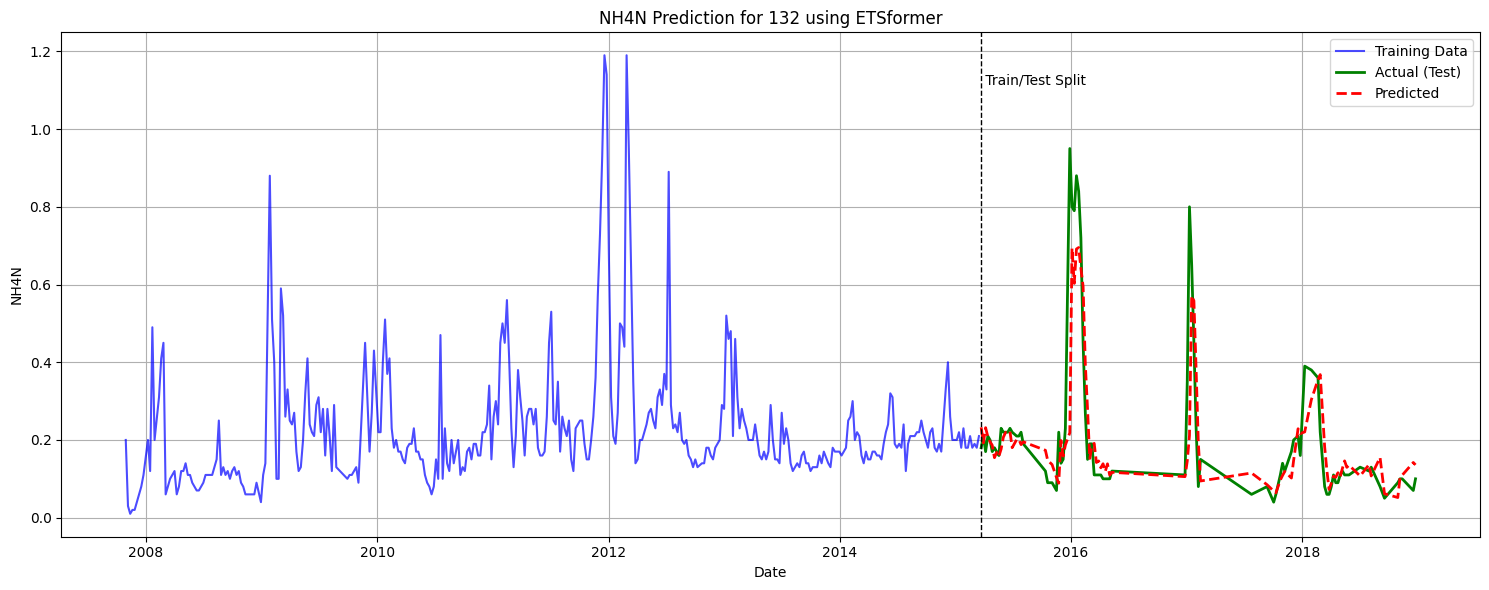

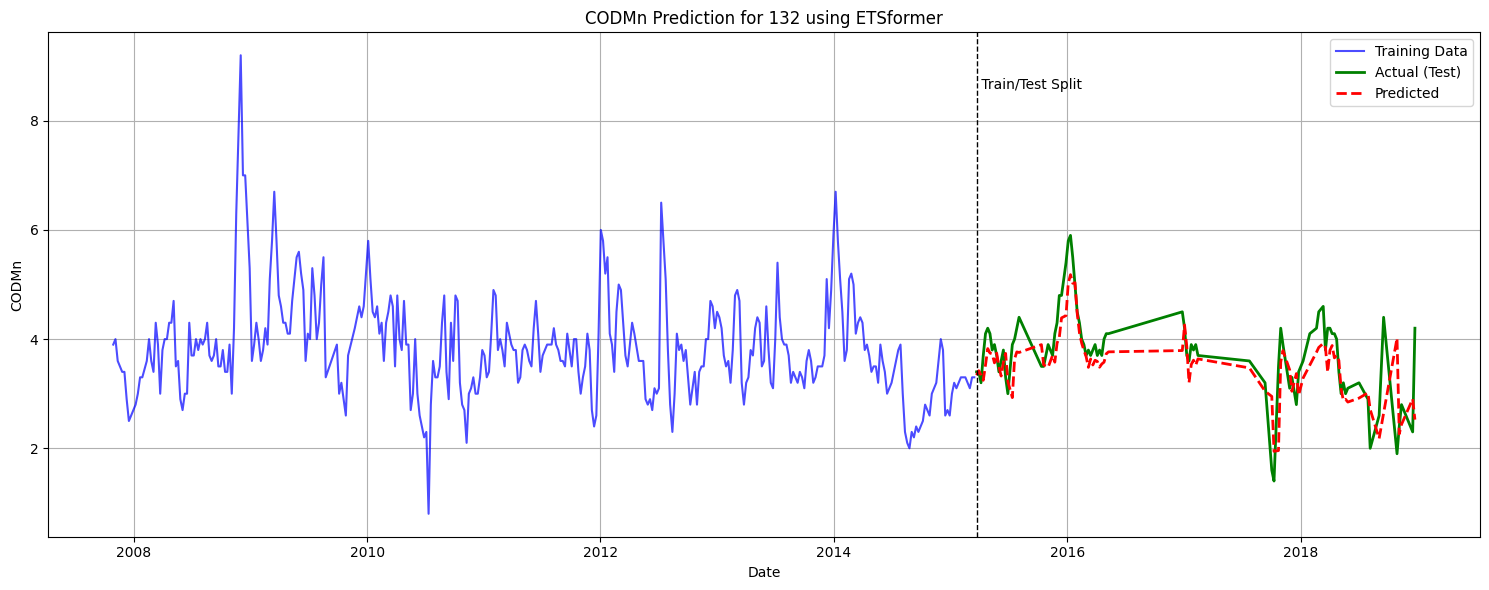

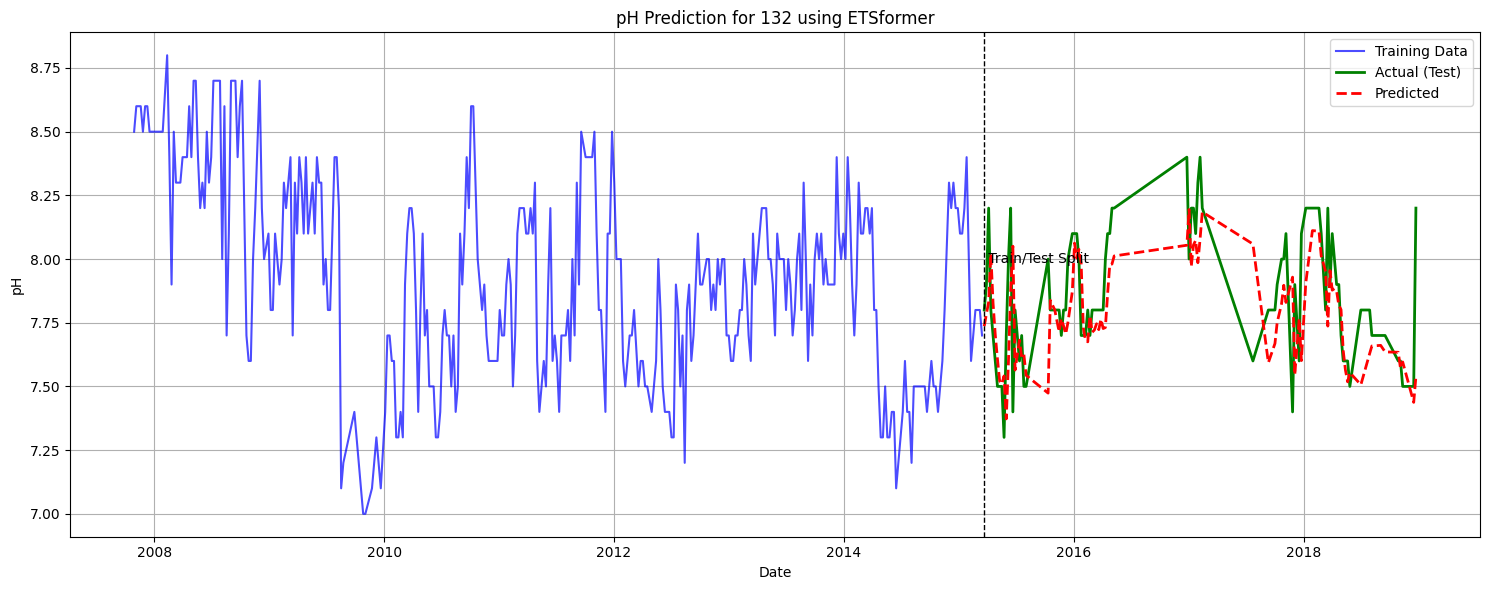

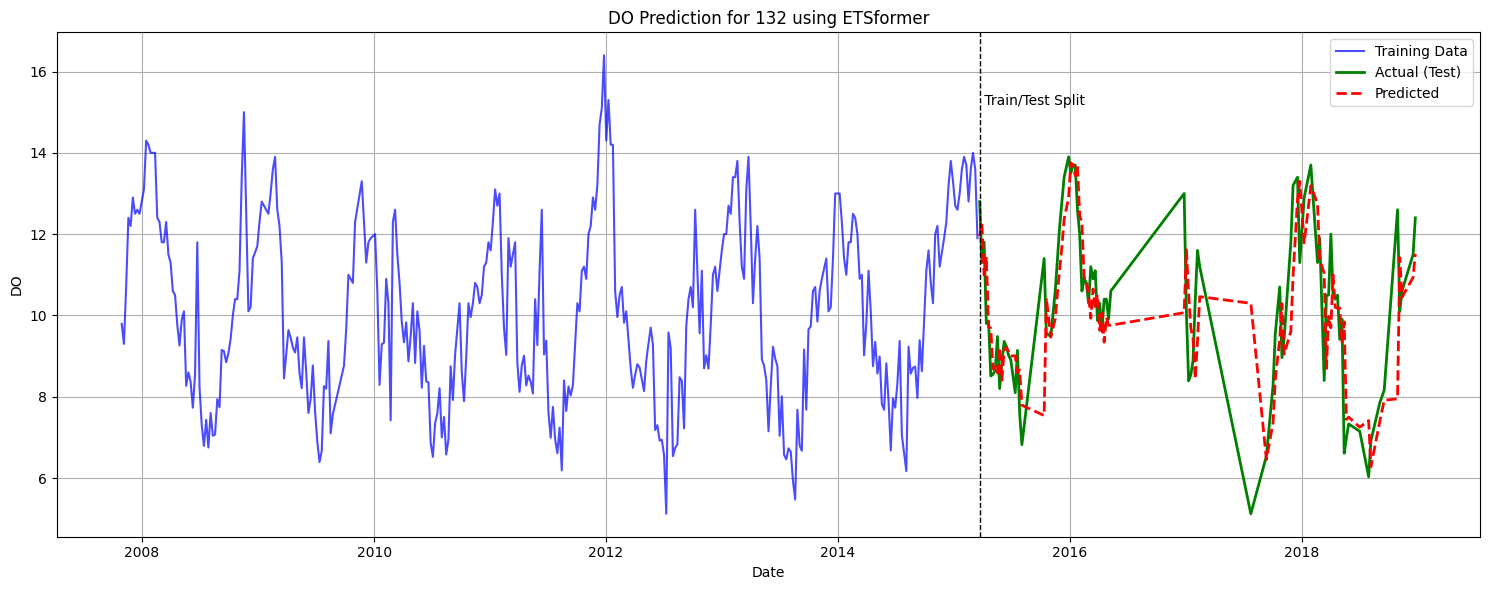

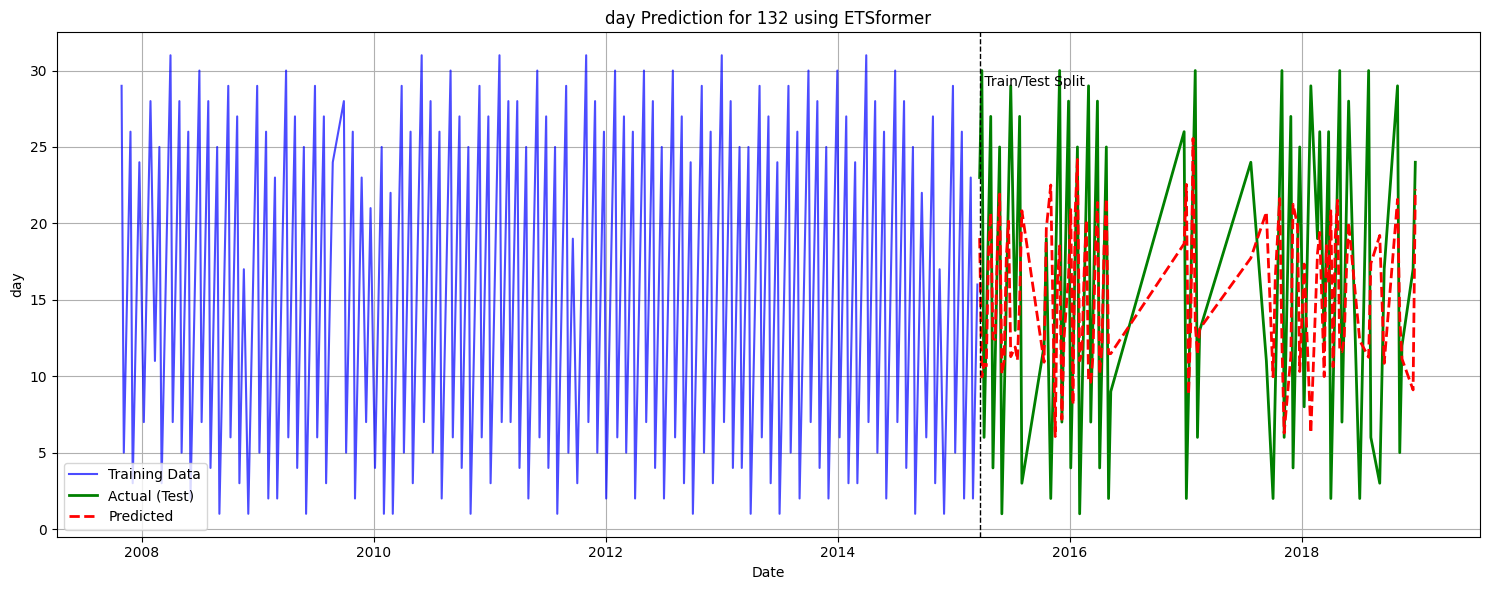

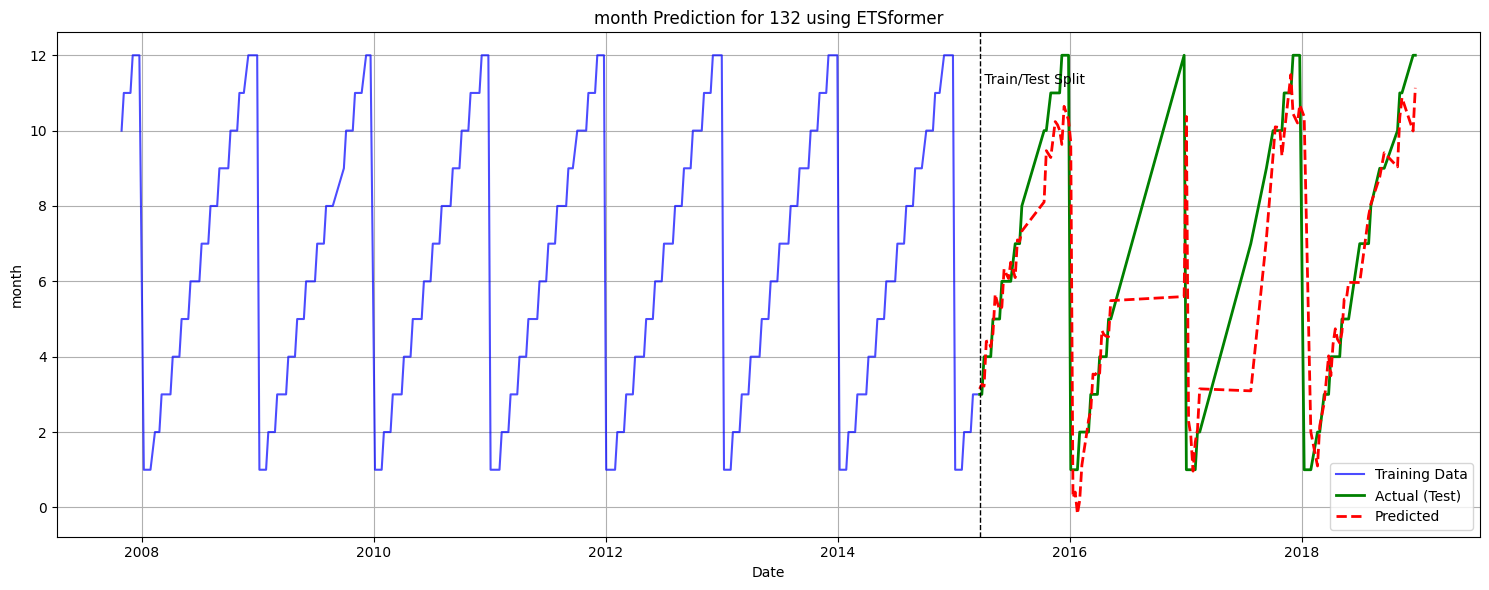

<ipython-input-10-f0cf2f07a8bb>:244: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


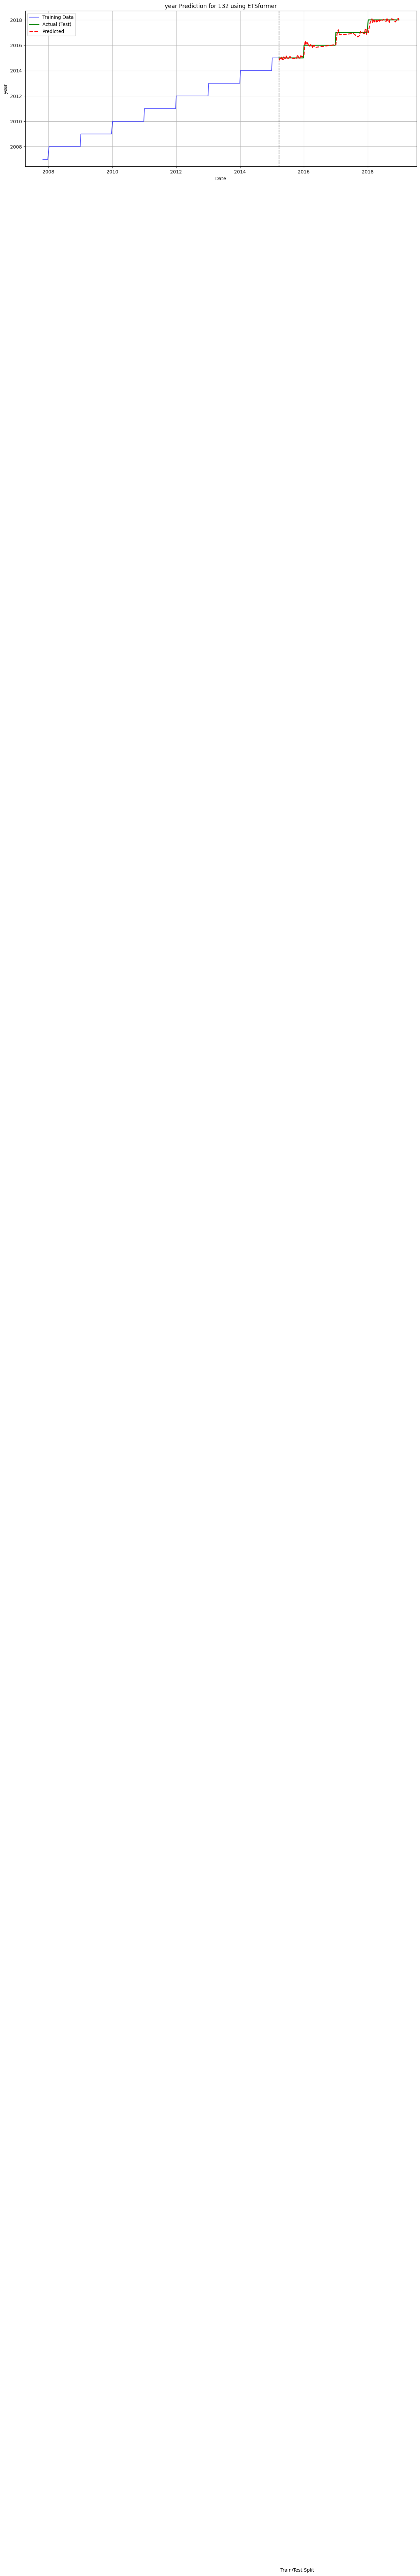

In [ ]:
# Define your features
features = ['NH4N', 'CODMn', 'pH', 'DO']

# Run the training and evaluation
results = train_etsformer_multivariate(pivot_df, features, seq_length=4, pred_length=1, epochs=120)